In [1]:
import math

import numpy as np
import pandas as pd

import yfinance as yf 

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import keras.backend as K
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import LSTM,GRU,Dense,BatchNormalization,Dropout

In [2]:
nifty_list = pd.read_csv('./NIFTY50_Sectorwise_List.csv')
nifty_list.head(3)

COMPANY           CODE           INDUSTRY
0          Asian Paints Ltd  ASIANPAINT.NS  Consumer Durables
1  Britannia Industries Ltd   BRITANNIA.NS               FMCG
2                 Cipla Ltd       CIPLA.NS         Healthcare

In [3]:
def plotSeries(company,data):
    plt.figure(figsize = (20,5))
    plt.plot(data,color='b')
    plt.title(company)
    plt.show()

def plot_prediction(test,pred_lstm,pred_gru):
    rmse_lstm = round(math.sqrt(mean_squared_error(test, pred_lstm)),4)
    rmse_gru = round(math.sqrt(mean_squared_error(test, pred_gru)),4)

    plt.figure(figsize=(20,5))
    plt.plot(range(120),test, label="test Price",color='b')
    plt.plot(range(120),pred_lstm, 'g--',label="predicted Price [LSTM]")
    plt.plot(range(120),pred_gru, 'k--',label="predicted Price [GRU]")

    plt.xlabel('\nLSTM : '+str(rmse_lstm)+'\nGRU : '+str(rmse_gru),fontsize=10)
    plt.legend()
    plt.show()

    return rmse_lstm,rmse_gru

def getSampledData(data,indices,seq_len):
    sampled_df = {str(i):[] for i in range(seq_len)}
    sampled_df['Target'] = []

    for i in range(len(data)-seq_len):
        for j in range(i,i+seq_len):
            sampled_df[str(j-i)].append(data[j])
        sampled_df['Target'].append(data[j+1])

    sampled_df = pd.DataFrame(sampled_df)
    sampled_df.index = indices[:len(sampled_df)]
    sampled_df.head()
    return sampled_df

def dataPreprocessing(company,code,seq_len,n_future):
    data = yf.download(code)
    indices = data.index
    plotSeries(company,data)

    df = np.array(data['Close'])
    df = getSampledData(df,indices,seq_len)

    scaler = StandardScaler()
    
    X = pd.DataFrame(scaler.fit_transform(df.drop(['Target'],axis=1)))
    Y = pd.DataFrame(scaler.fit_transform(pd.DataFrame(df['Target'])))

    X_train = X[:len(X)-n_future]
    Y_train = Y[:len(Y)-n_future]

    X_test = X[len(X)-n_future:]
    Y_test = Y[len(Y)-n_future:]

    return X_train,X_test,Y_train,Y_test

def trainLSTM(X_train,X_test,Y_train,Y_test,seq_len):
    K.clear_session()
    lstm = Sequential()
    lstm.add(LSTM(seq_len,input_shape=(X_train.shape[1],1),return_sequences=False,activation='relu'))
    lstm.add(Dense(64,activation='relu')) # best 64
    lstm.add(Dropout(0.3))
    lstm.add(Dense(1))

    early_stopping = EarlyStopping(
            min_delta=0.001,
            patience=5,
            restore_best_weights=True,
        )

    lstm.compile(loss='mse', optimizer='adam')
        
    history = lstm.fit(X_train, Y_train, 
                                batch_size=16,
                                epochs=10,
                                callbacks = [early_stopping],
                                verbose=1)

    prediction = lstm.predict(X_test)
    return prediction,Y_test

def trainGRU(X_train,X_test,Y_train,Y_test,seq_len):
    K.clear_session()
    gru = Sequential()
    gru.add(GRU(seq_len,input_shape=(X_train.shape[1],1),return_sequences=False,activation='relu'))
    gru.add(Dense(64,activation='relu')) # best 64
    gru.add(Dropout(0.3))
    gru.add(Dense(1))

    early_stopping = EarlyStopping(
            min_delta=0.001,
            patience=5,
            restore_best_weights=True,
        )

    gru.compile(loss='mse', optimizer='adam')
        
    history = gru.fit(X_train, Y_train, 
                                batch_size=16,
                                epochs=10,
                                callbacks = [early_stopping],
                                verbose=1)

    prediction = gru.predict(X_test)
    return prediction,Y_test
            

In [4]:
seq_len = 60    # length of the lookback window
n_future = 120  # number of future days to forecast

result = pd.read_csv('result.csv')
result.index = result['COMPANY']
result = result.drop(['COMPANY'],axis=1)

[*********************100%%**********************]  1 of 1 completed


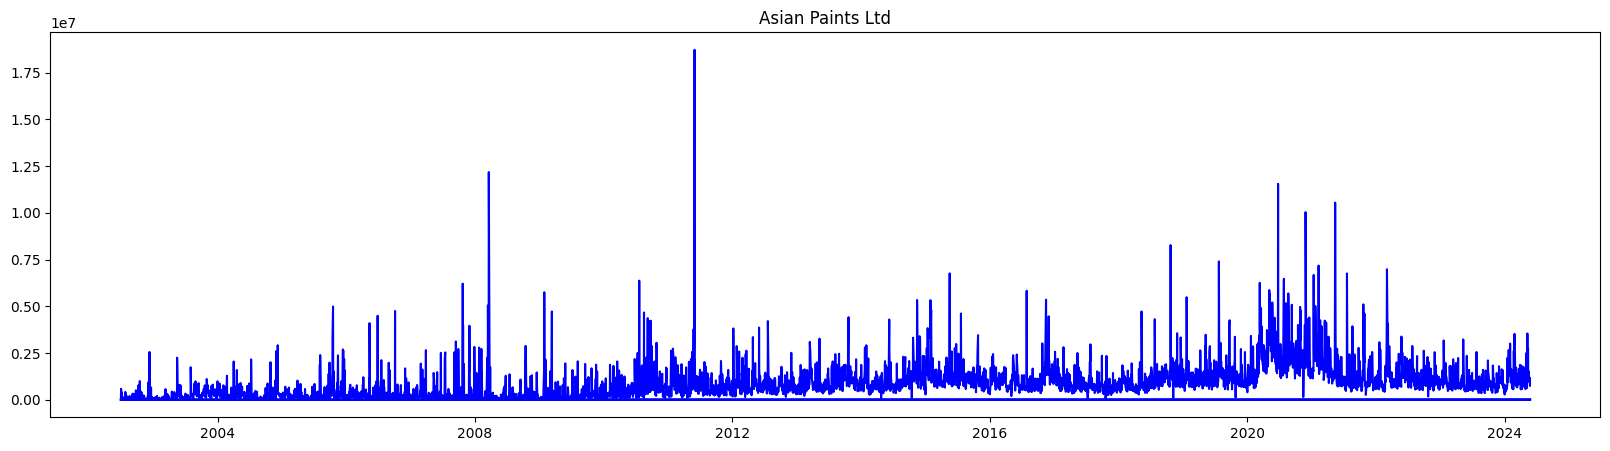


Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.1647
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0132

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0225
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0239
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0228
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0203
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0217
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0195
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0205
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0228
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0192
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.1885
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0238

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0231
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0217
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0221
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0203
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0202
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0211
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0232
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0227
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0199
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


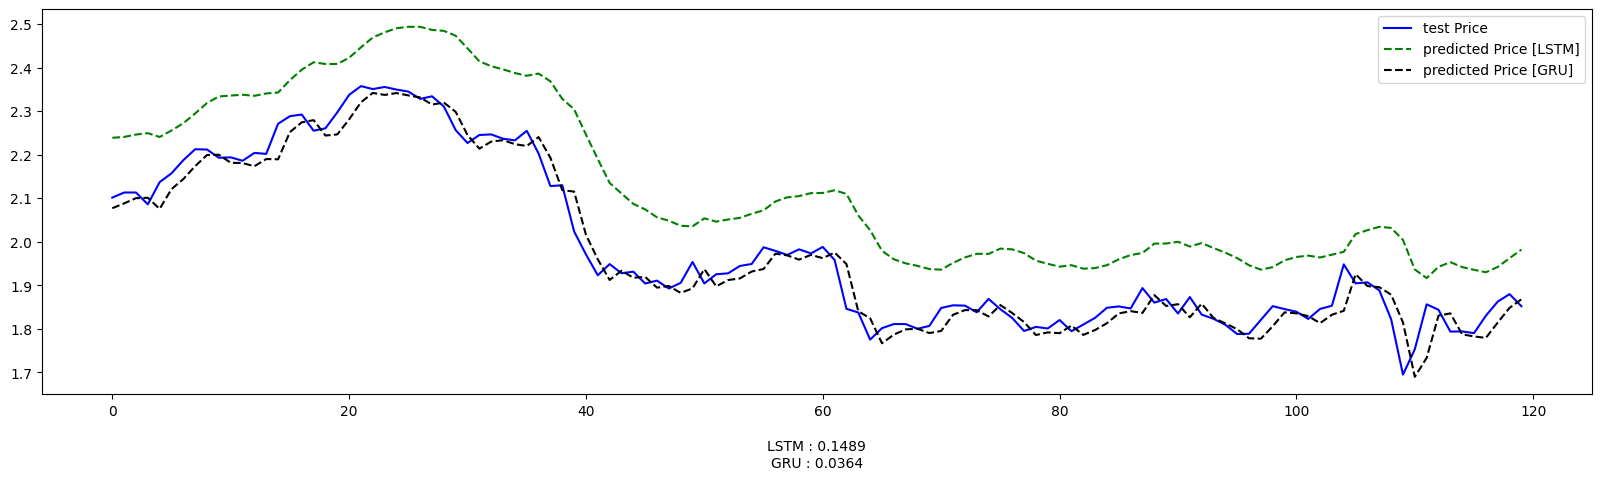

[*********************100%%**********************]  1 of 1 completed


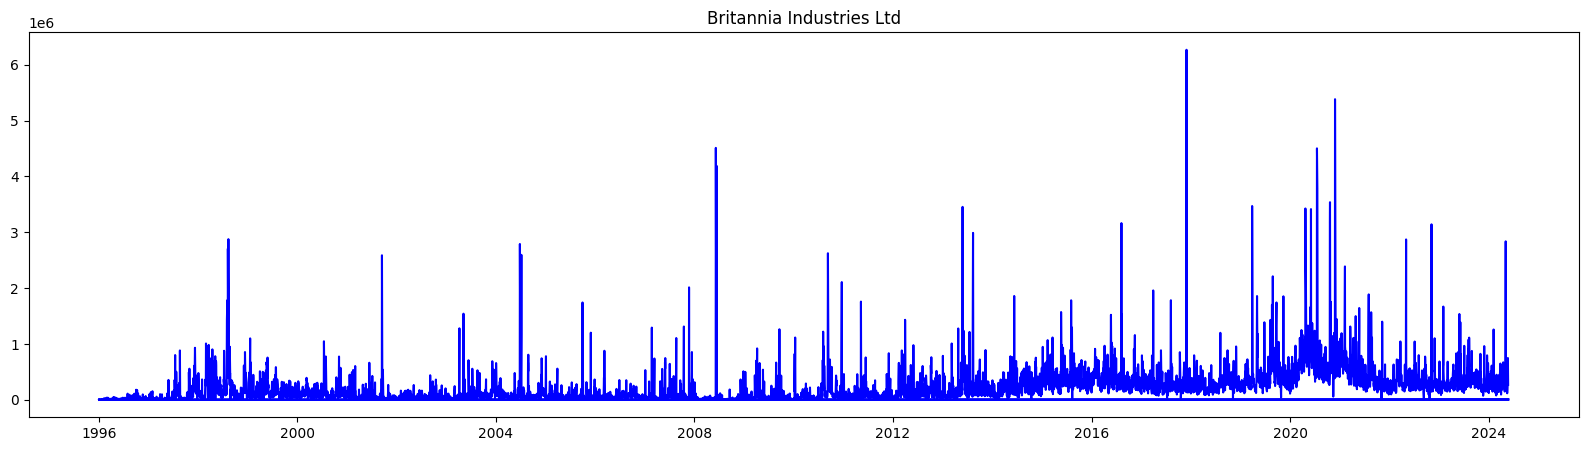

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1682
Epoch 2/10
  8/435 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0162

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0211
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0207
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0203
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0184
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0194
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0195
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0205
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0196
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0187
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/stepWARNING:tensorflow:6 out of the last 12 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000106896034C0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1603
Epoch 2/10
  4/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0335 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0214
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0195
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0211
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0186
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0190
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0179
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0180
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0181
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0188
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


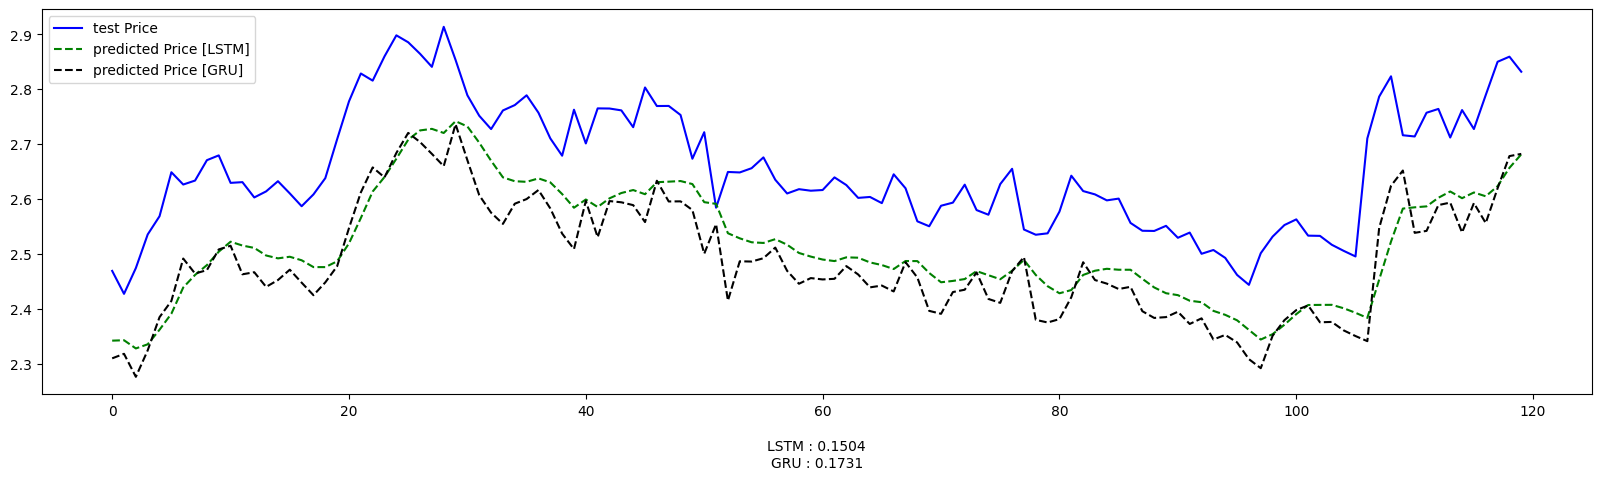

[*********************100%%**********************]  1 of 1 completed


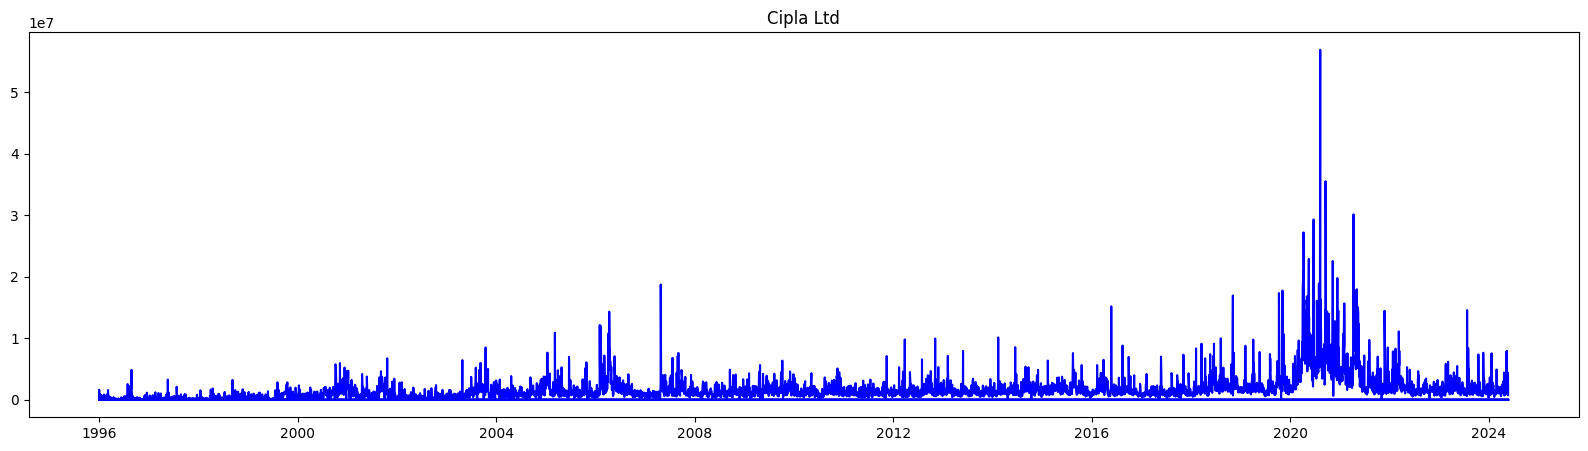

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 1.4668
Epoch 2/10
  6/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0192 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0244
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0200
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0213
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0194
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0176
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0193
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0188
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0190
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0177
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.1345
Epoch 2/10
  5/435 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0164

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0216
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0208
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0221
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0217
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0202
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0211
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0194
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0206
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.0192
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


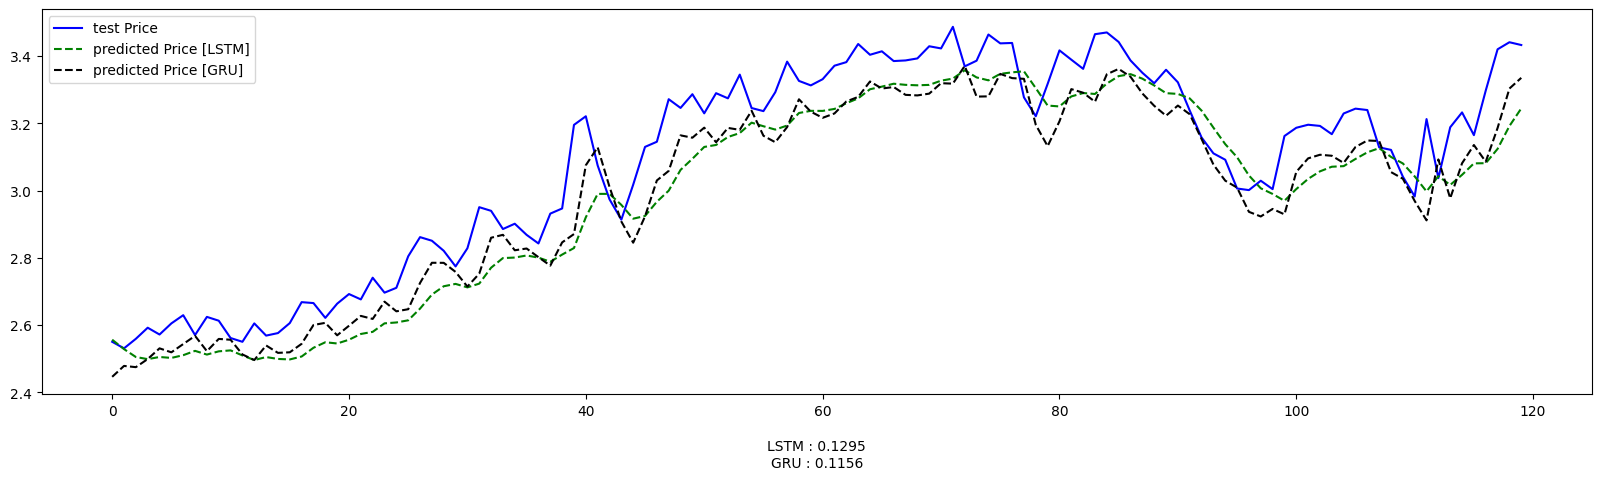

[*********************100%%**********************]  1 of 1 completed


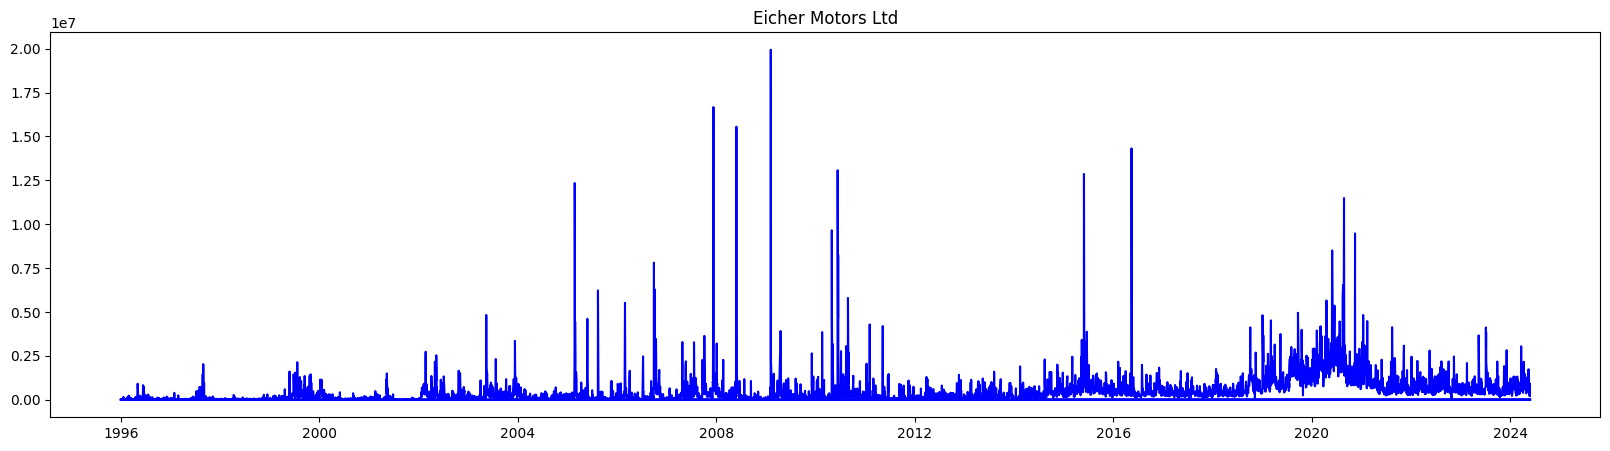

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 18ms/step - loss: 0.1416
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0212

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0217
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0196
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0199
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0201
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0201
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0194
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0191
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0201
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0197
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1731
Epoch 2/10
  4/435 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0191 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0250
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0233
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0233
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0211
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0223
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0227
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0238
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0223
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0218
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


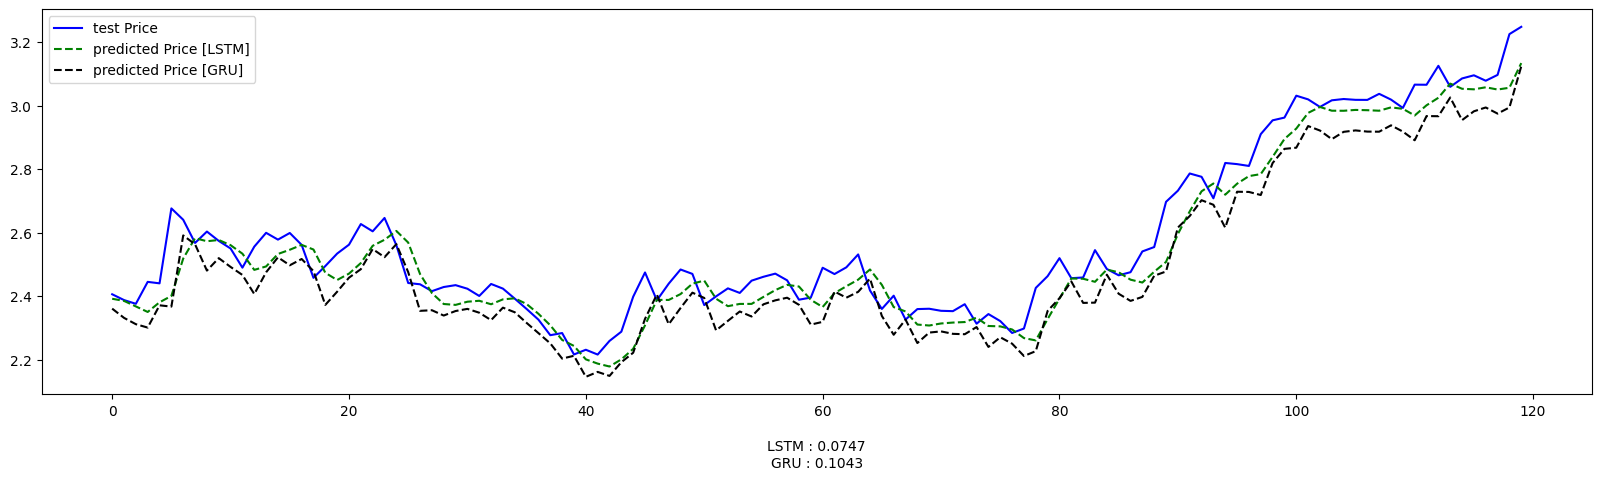

[*********************100%%**********************]  1 of 1 completed


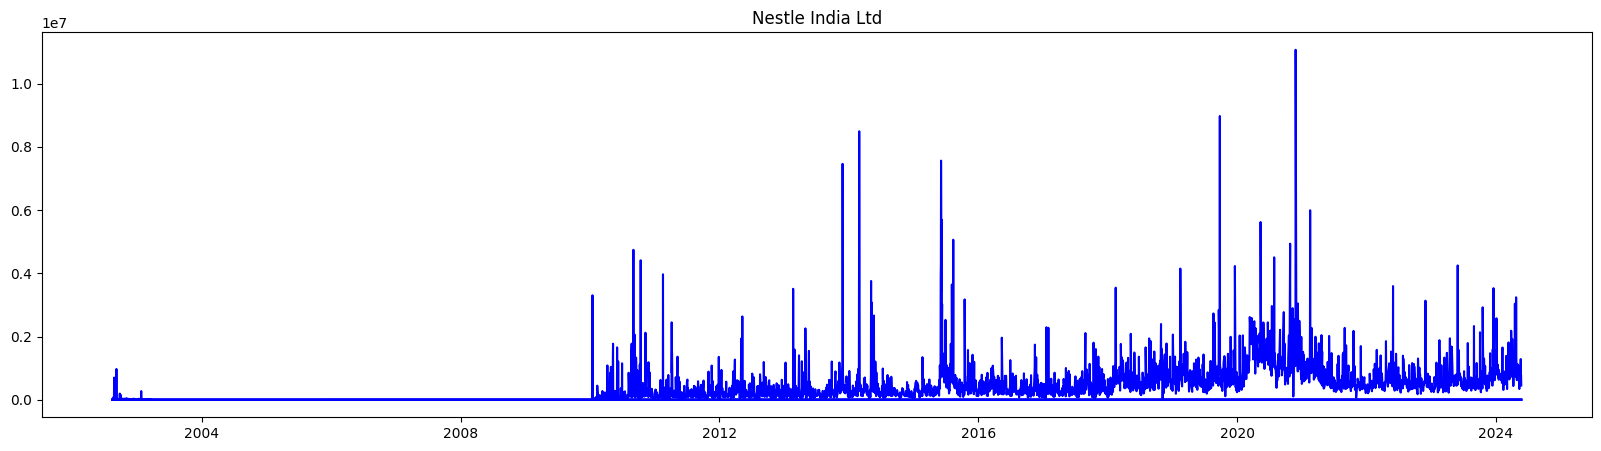

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 169.7374
Epoch 2/10
  7/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0303

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0286
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0232
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0212
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0191
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0189
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0177
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0204
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0184
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0167
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1779
Epoch 2/10
  4/327 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0174 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0200
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0194
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0185
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0187
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0188
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0188
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0182
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0167
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0183
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


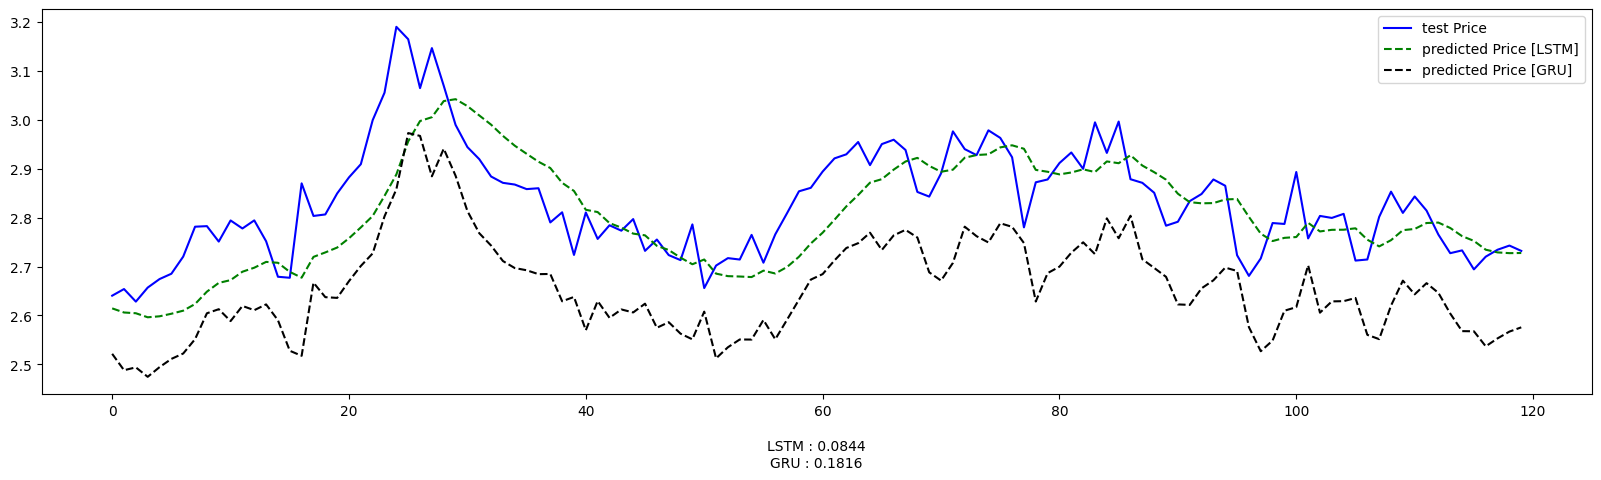

[*********************100%%**********************]  1 of 1 completed


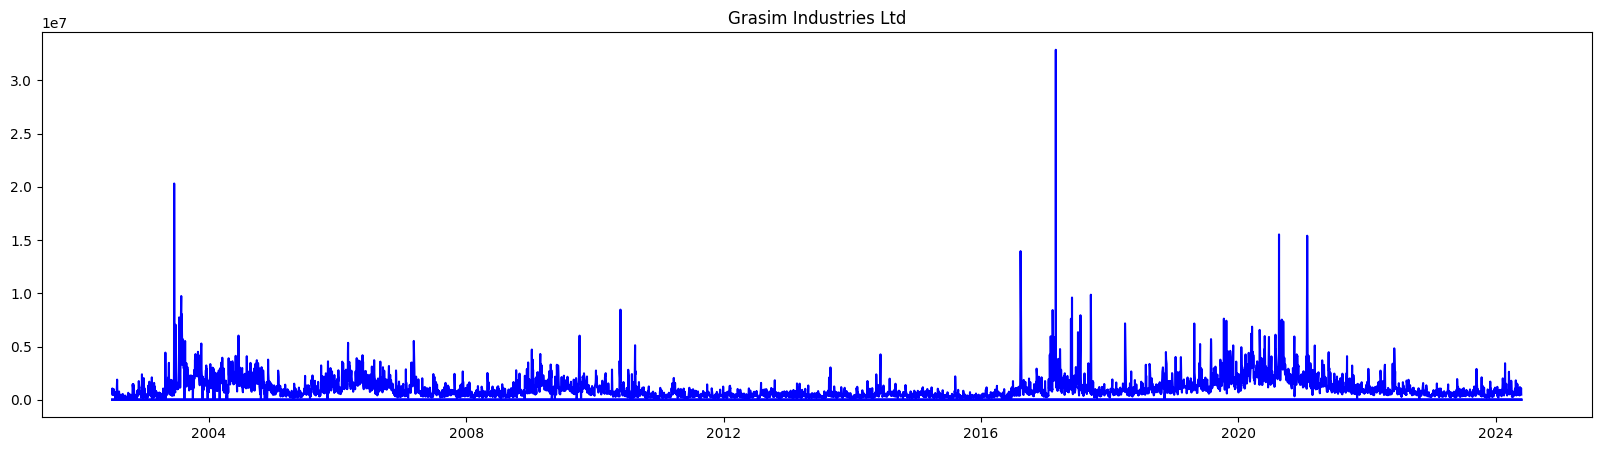

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.1606
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0199

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0192
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0188
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0187
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0199
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0198
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0209
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0217
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0190
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0201
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 0.1470
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0162

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 23ms/step - loss: 0.0211
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0196
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0206
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0179
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0196
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0210
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0207
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0206
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0188
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


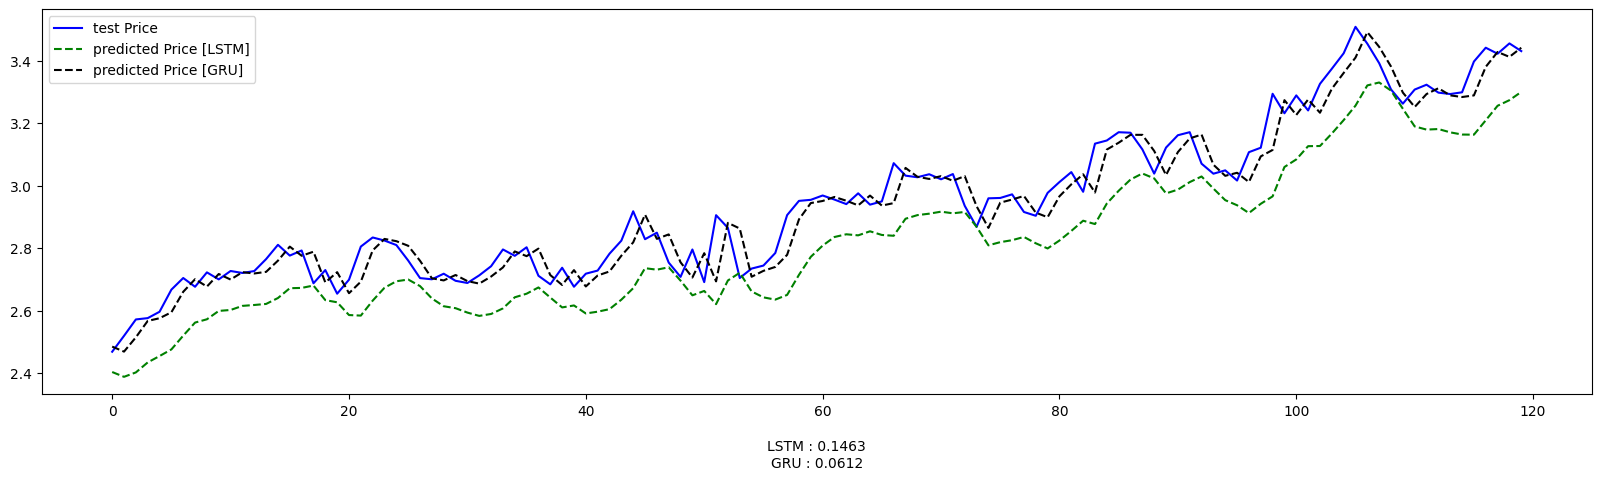

[*********************100%%**********************]  1 of 1 completed


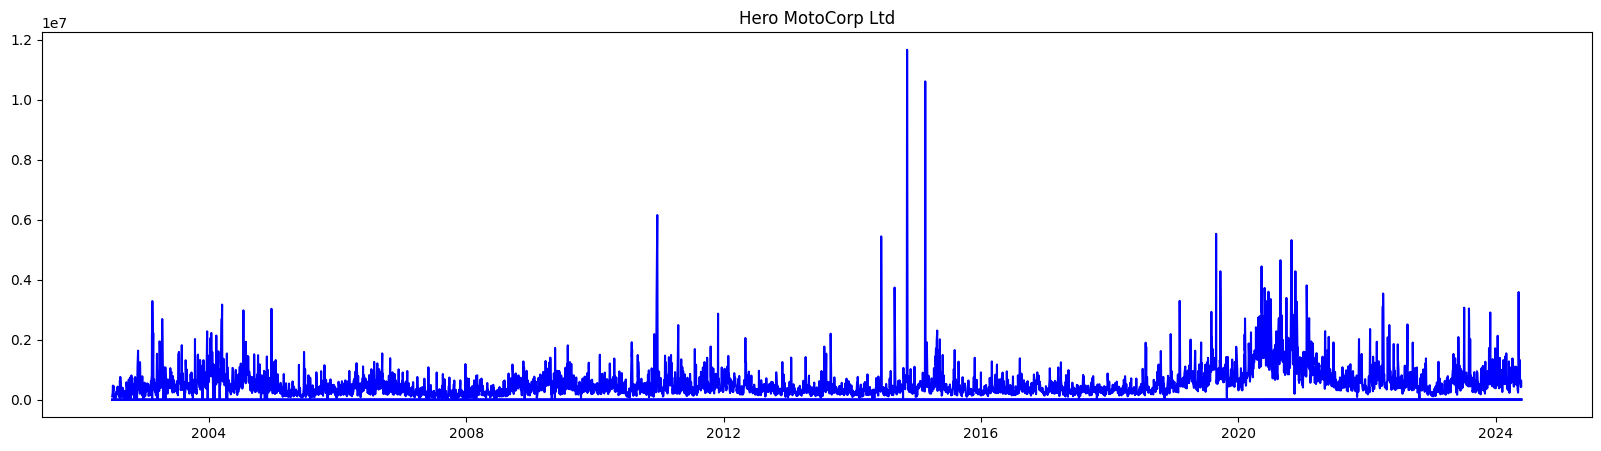

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.1804
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0199

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0247
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0225
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0254
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0223
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0220
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0230
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0229
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0223
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0227
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.1867
Epoch 2/10
  4/329 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0210 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0226
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0206
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0212
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0206
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0213
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0207
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0230
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0208
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0206
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


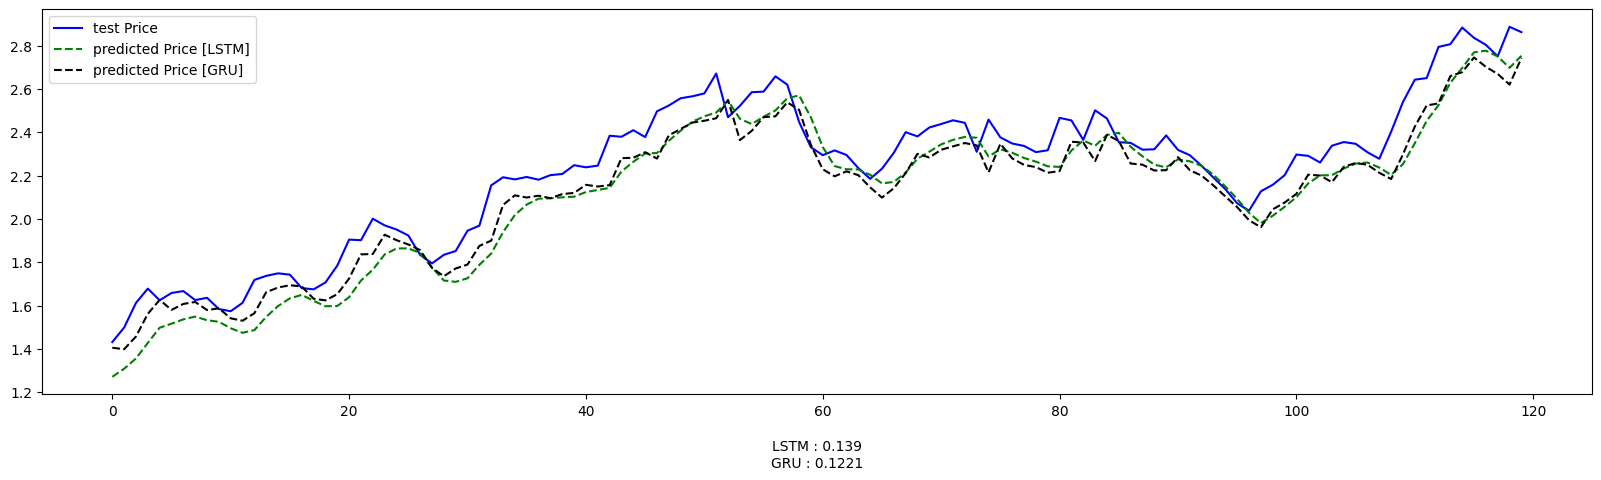

[*********************100%%**********************]  1 of 1 completed


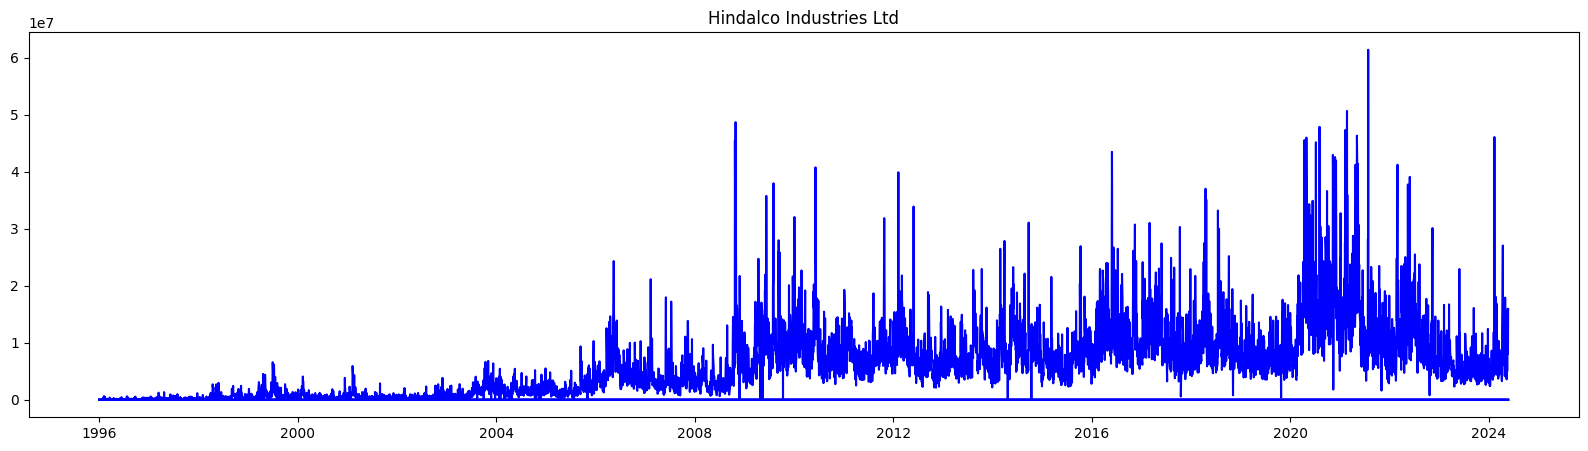

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 17ms/step - loss: 0.1692
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0375

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0238
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0210
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0197
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0184
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0198
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0184
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0188
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0170
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0191
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - loss: 0.1202
Epoch 2/10
  6/435 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0308

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0214
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0224
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0206
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0208
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0221
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0209
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0202
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0202
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0183
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


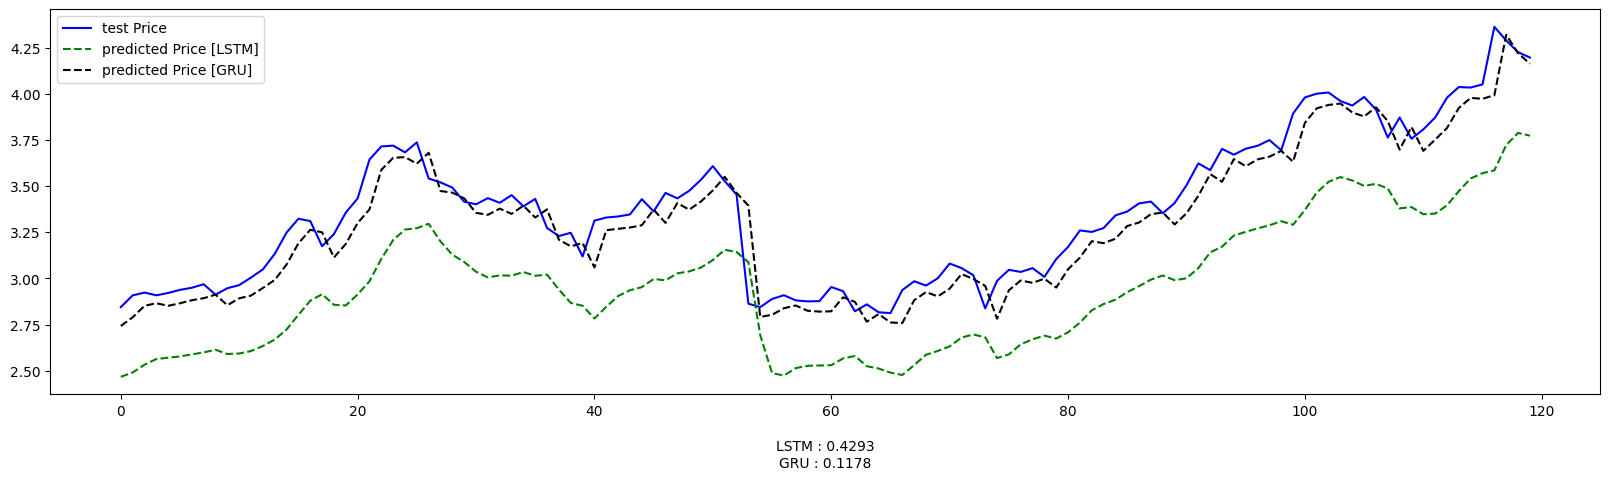

[*********************100%%**********************]  1 of 1 completed


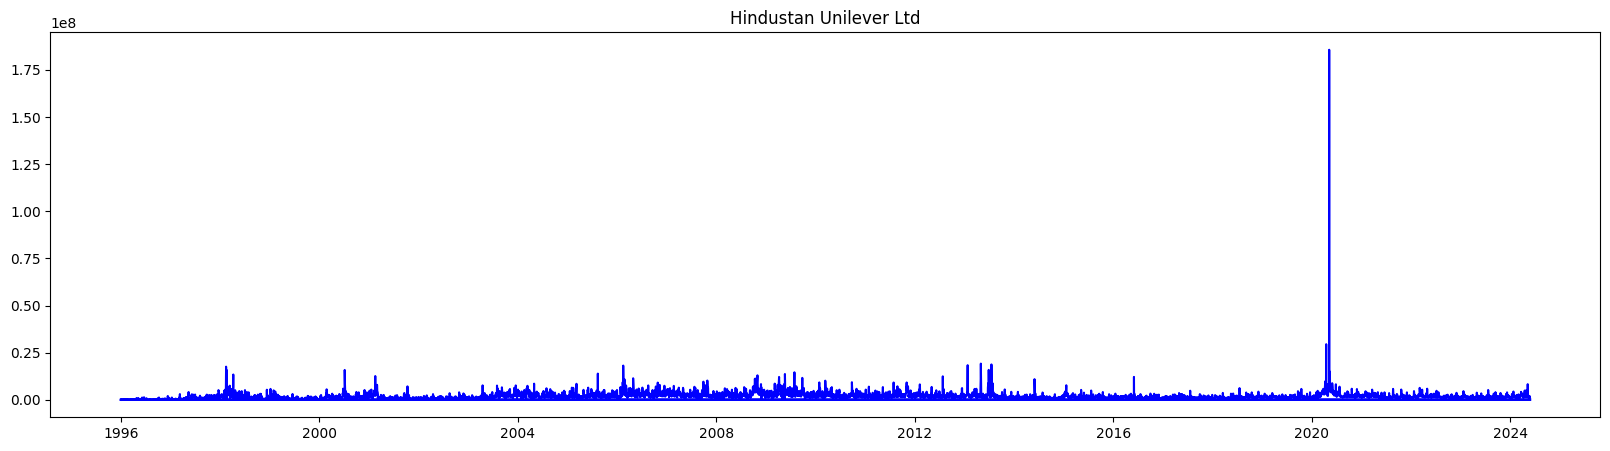

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1709
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0211

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0225
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0221
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0233
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0219
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0212
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0205
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0207
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0218
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1456
Epoch 2/10
  4/435 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0201 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0220
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0206
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0191
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0202
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0186
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0181
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0209
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0203
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0216
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


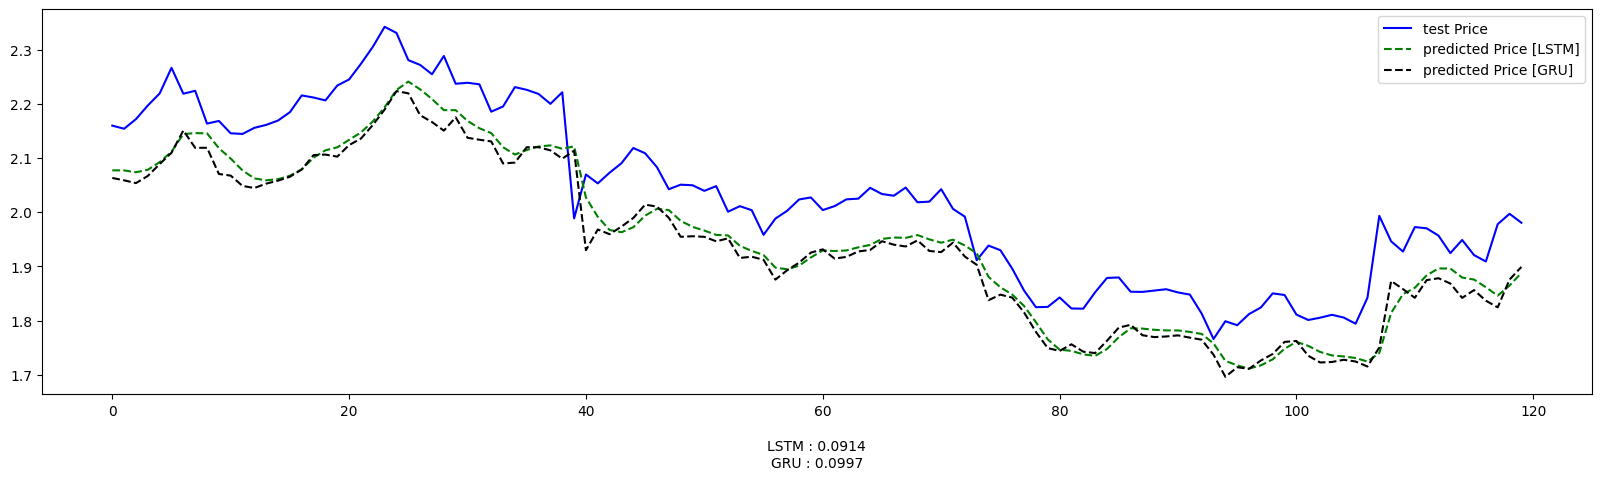

[*********************100%%**********************]  1 of 1 completed


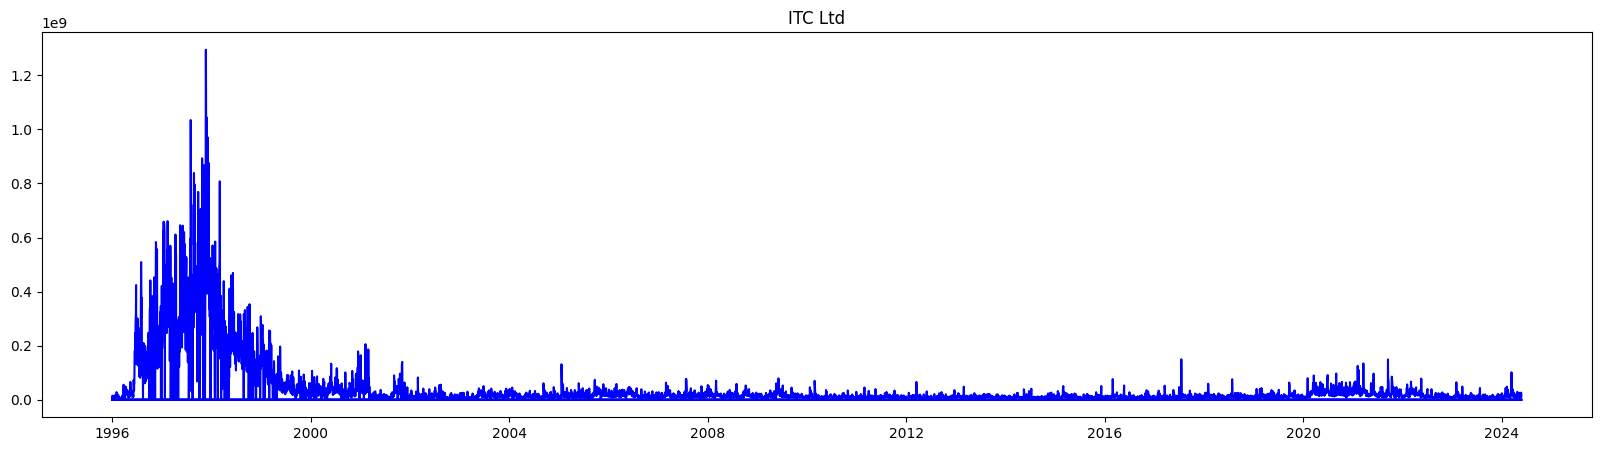

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.2132
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0309

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0296
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0282
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0279
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0268
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0262
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0260
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0261
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0251
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0268
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.1556
Epoch 2/10
  6/435 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0277

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0238
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0248
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0235
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0222
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0210
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0215
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0233
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0222
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0216
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


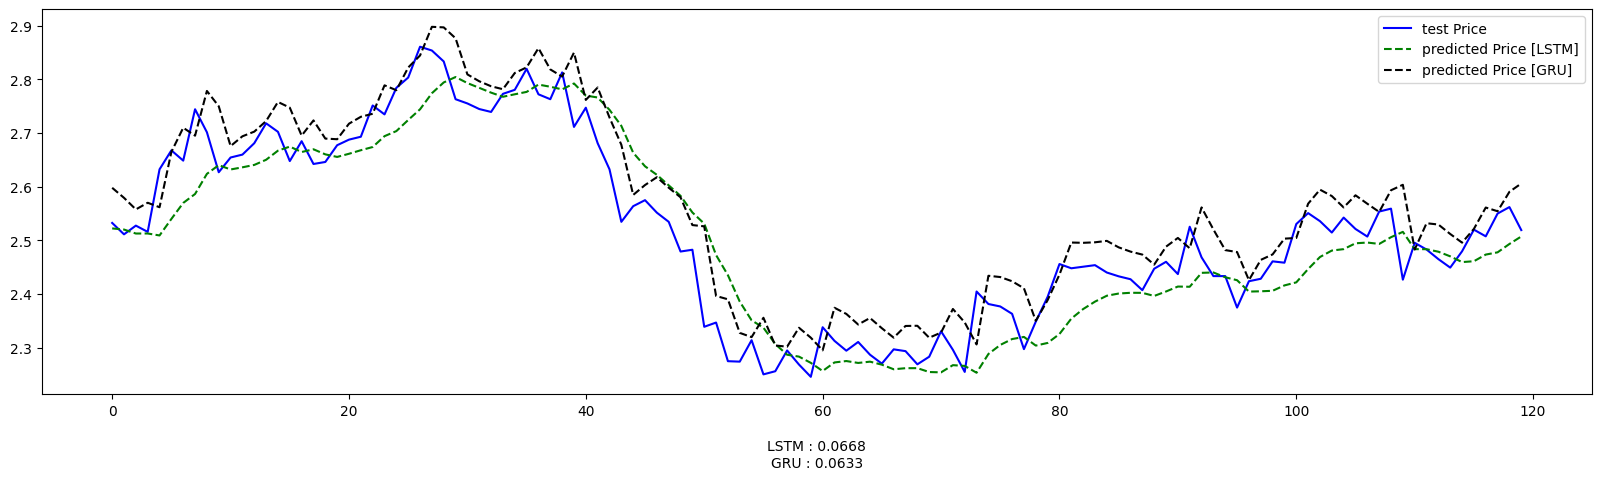

[*********************100%%**********************]  1 of 1 completed


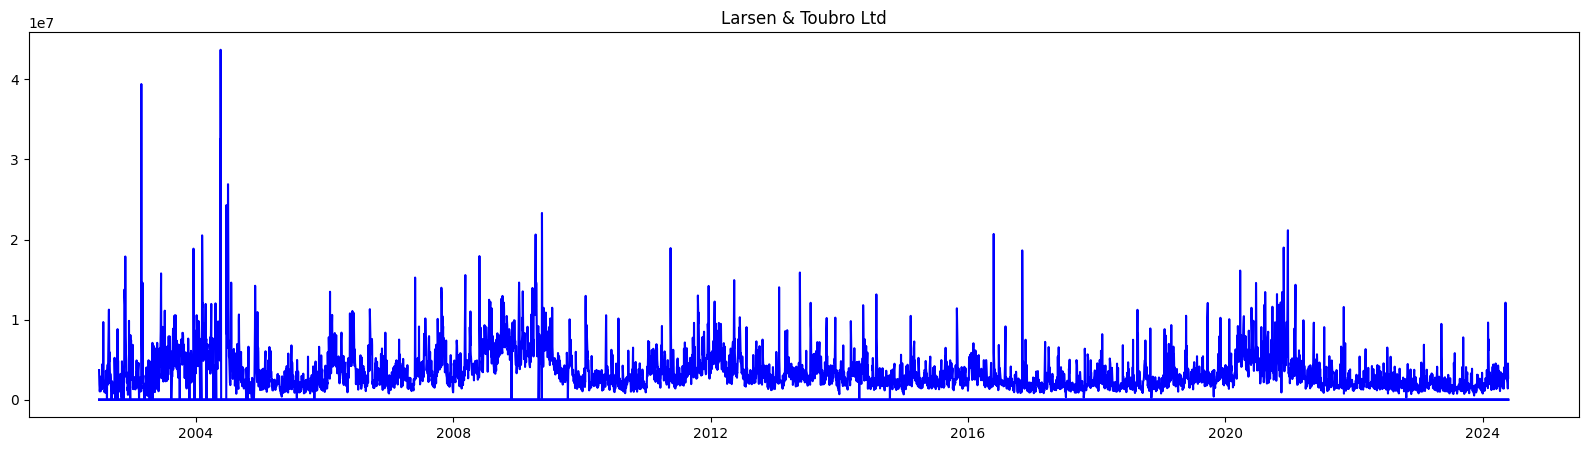

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.1281
Epoch 2/10
  8/329 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0187

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0204
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0164
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0167
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0156
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0160
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0178
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0145
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0157
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0154
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.1635
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0177

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0166
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0156
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0159
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0160
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0152
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0151
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0157
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0174
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


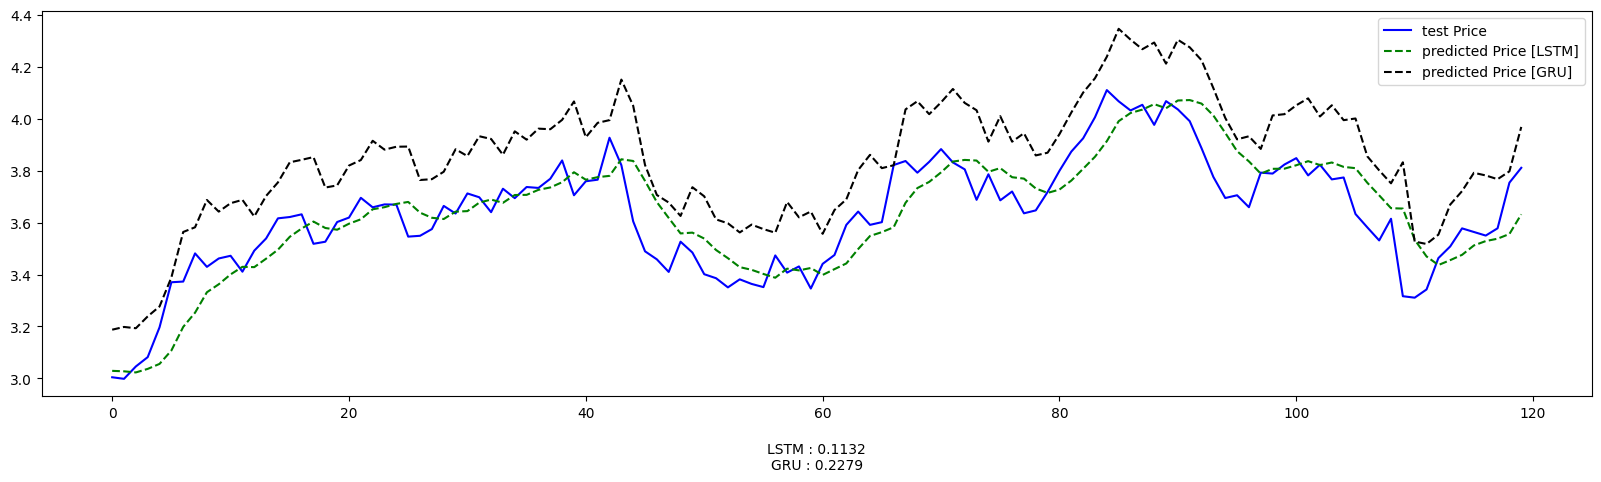

[*********************100%%**********************]  1 of 1 completed


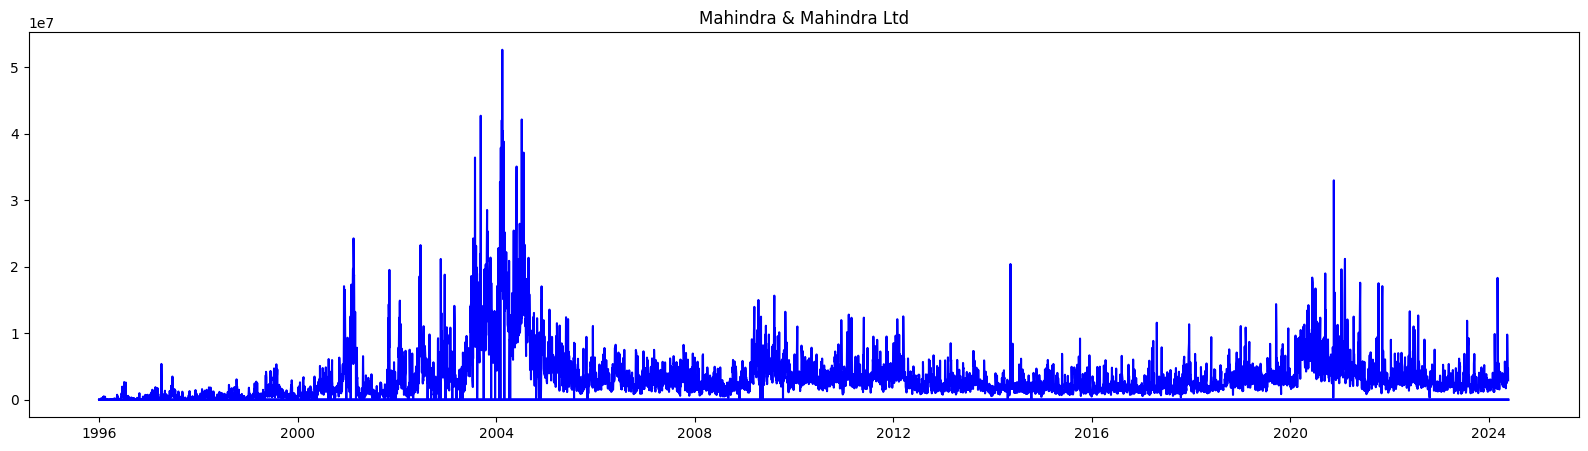

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 165.0619
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0198

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0302
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0359
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0250
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0239
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0242
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0229
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0203
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0235
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0220
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1481
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0181

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0216
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0211
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0200
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0195
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0190
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0187
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0195
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0190
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0197
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


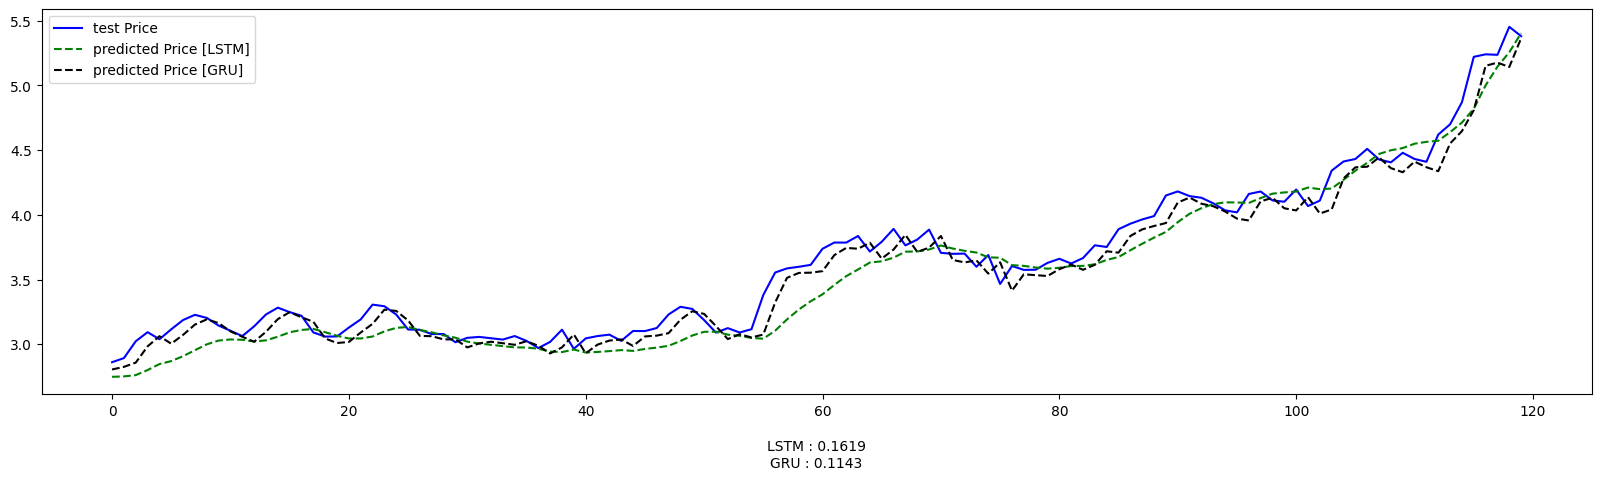

[*********************100%%**********************]  1 of 1 completed


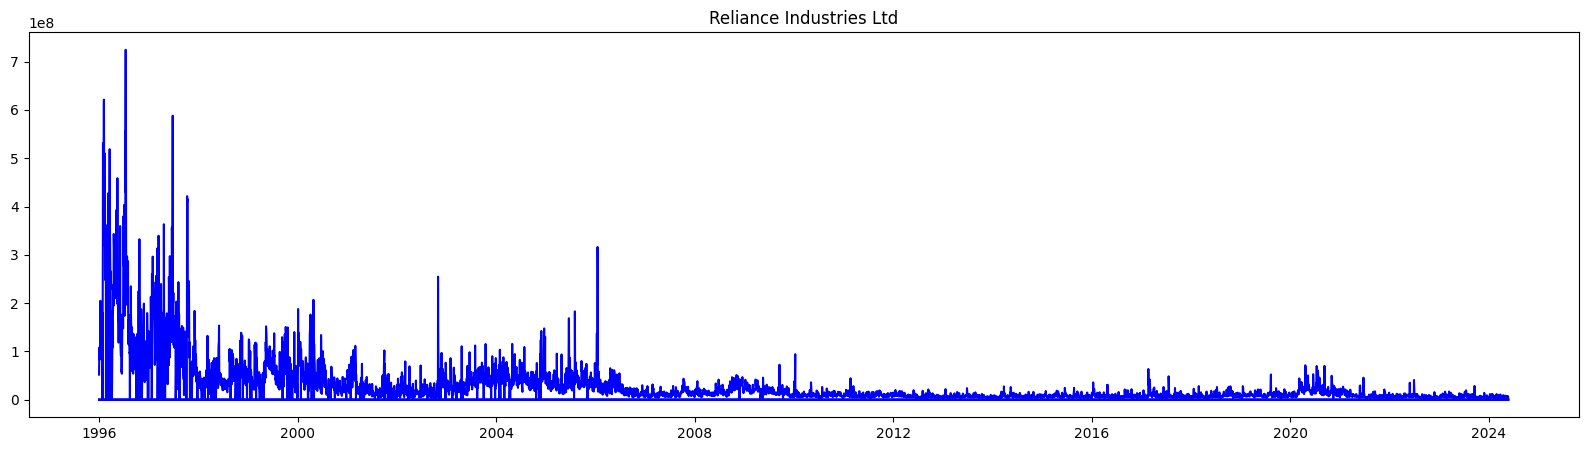

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 2.3931
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0236

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0262
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0245
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0234
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0217
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0244
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0217
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0214
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0213
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0225
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1423
Epoch 2/10
  4/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0108 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0214
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0224
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0200
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0196
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0204
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0199
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0193
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0192
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0195
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


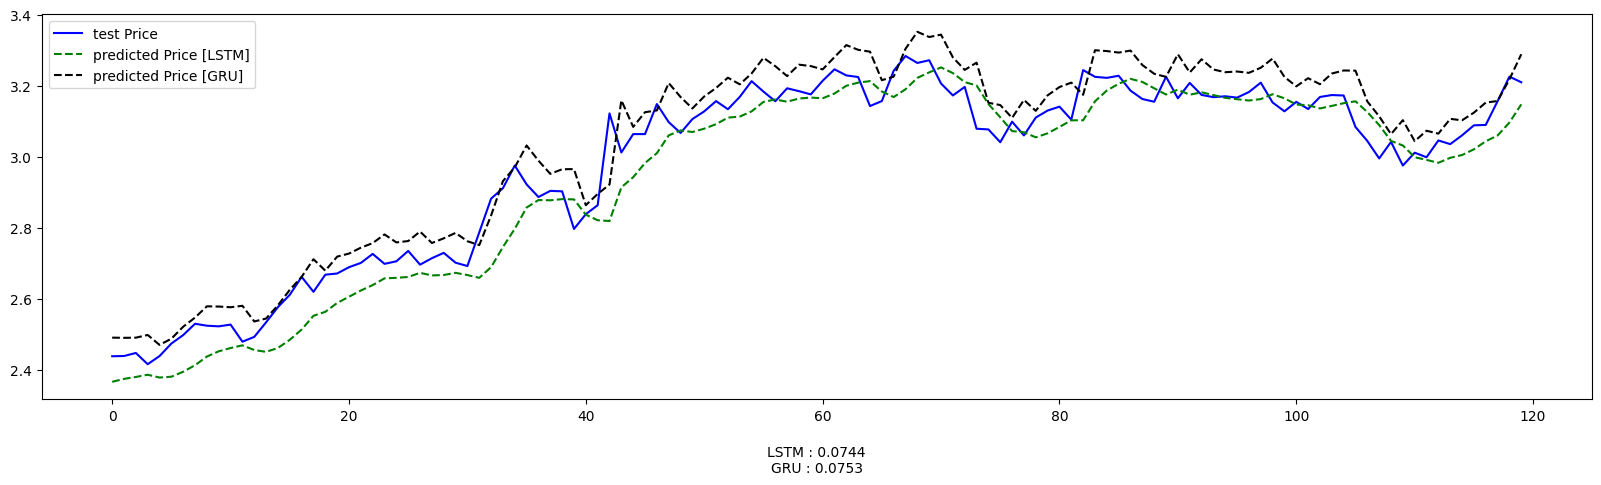

[*********************100%%**********************]  1 of 1 completed


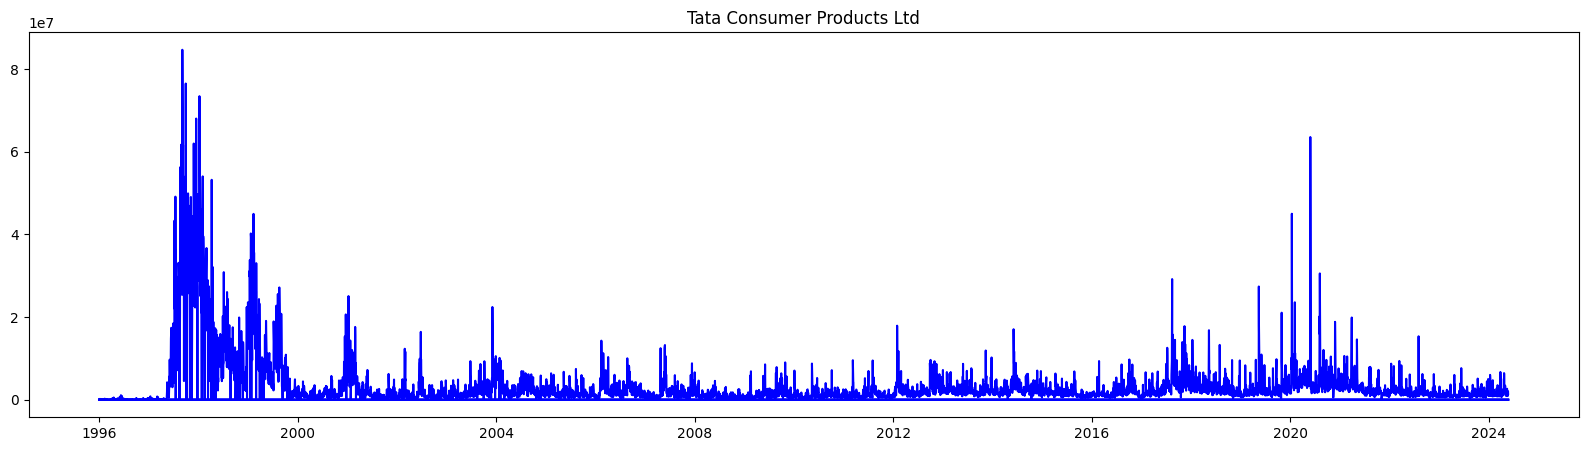

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1840
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0139

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0194
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0176
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0180
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0207
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0170
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0168
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0186
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0174
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0165
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1088
Epoch 2/10
  4/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0220 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0218
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0191
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0182
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0196
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0189
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0179
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0178
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0165
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0166
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


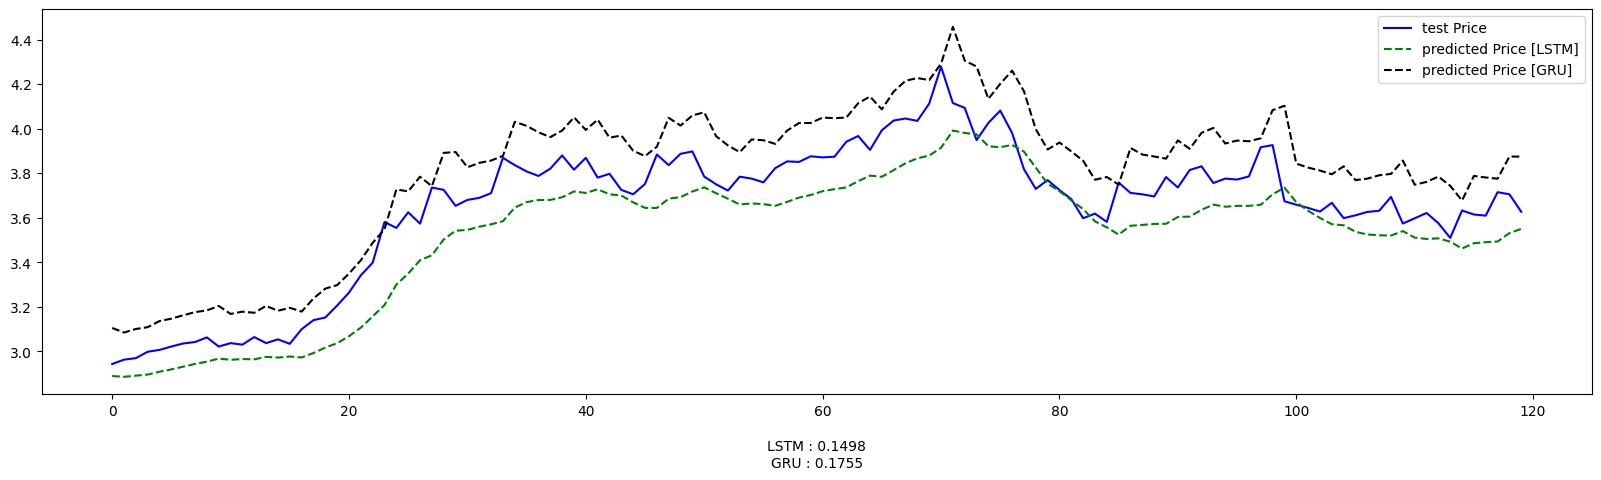

[*********************100%%**********************]  1 of 1 completed


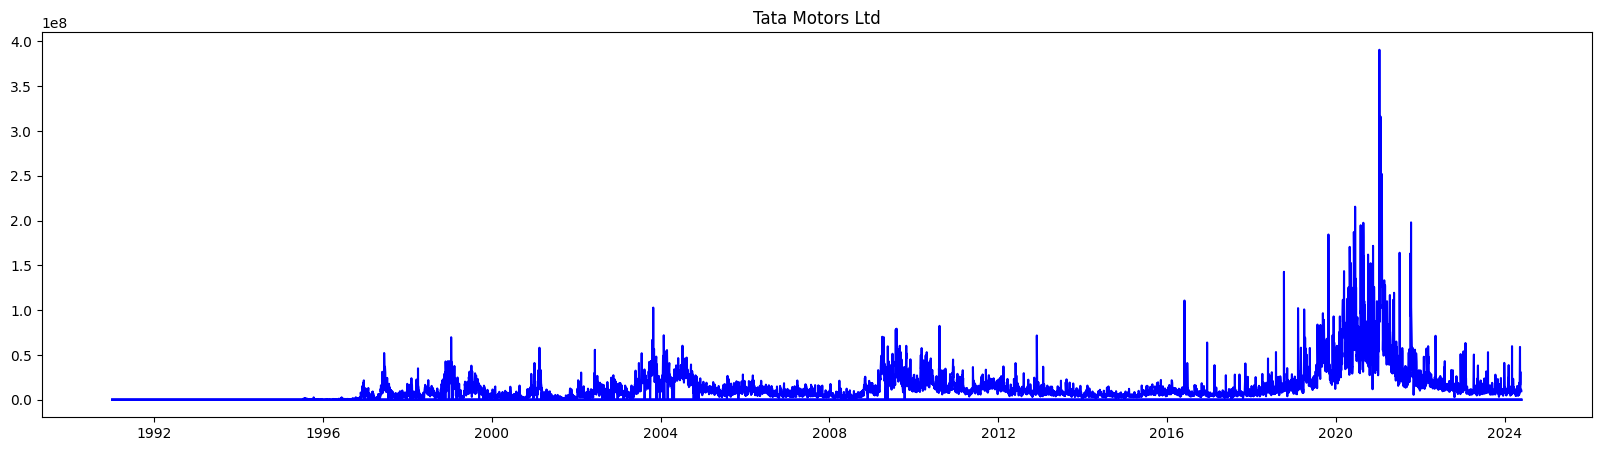

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


517/517 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - loss: 0.0941
Epoch 2/10
  7/517 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - loss: 0.0176

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0215
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0195
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0196
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0204
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0206
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0201
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.0188
Epoch 9/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0195
Epoch 10/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0179
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


517/517 ━━━━━━━━━━━━━━━━━━━━ 13s 21ms/step - loss: 0.1307
Epoch 2/10
  4/517 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.0174

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0234
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0215
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0219
Epoch 5/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0214
Epoch 6/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0226
Epoch 7/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0216
Epoch 8/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0227
Epoch 9/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0244
Epoch 10/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.0209
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


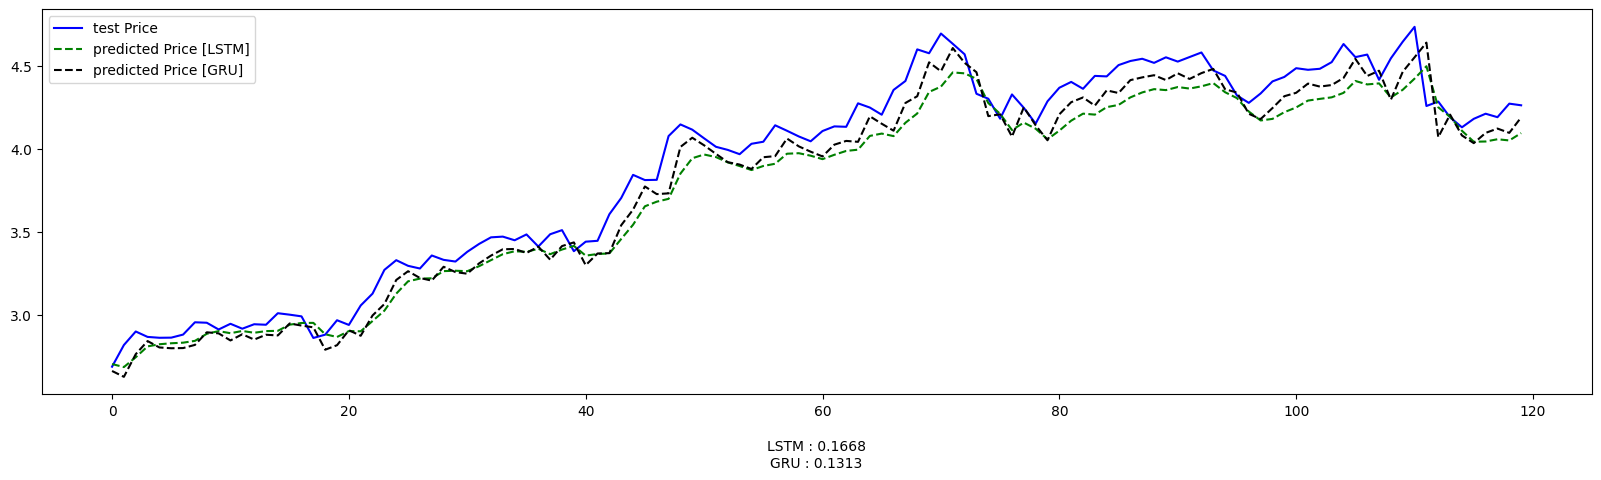

[*********************100%%**********************]  1 of 1 completed


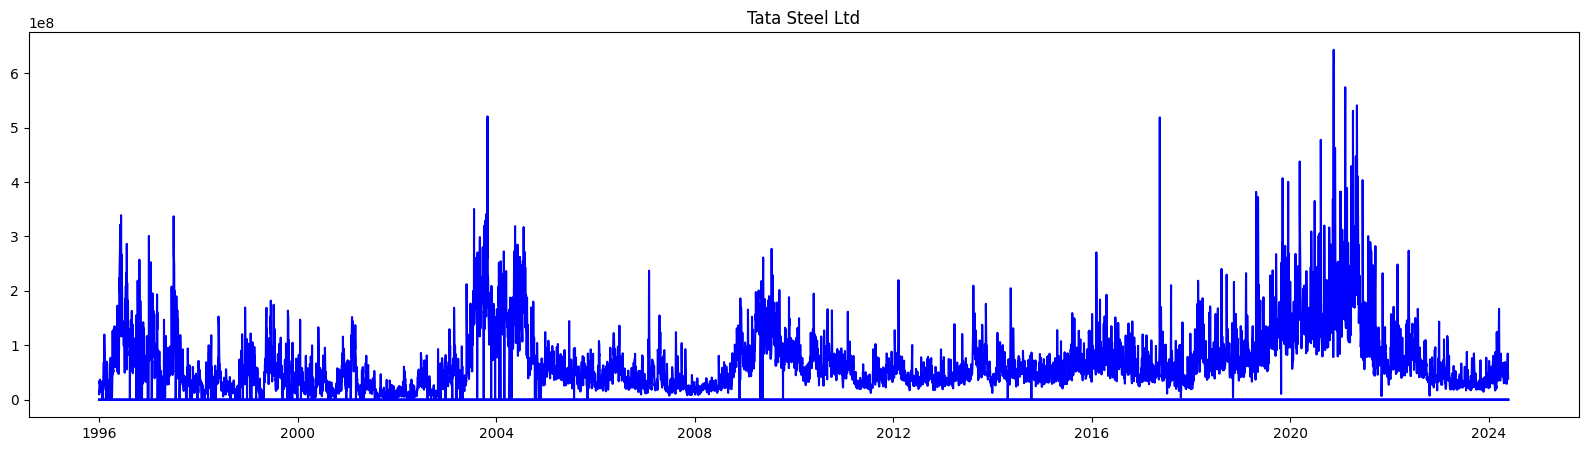

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1494
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0484

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0338
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0284
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0315
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0384
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0459
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0342
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0343
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0289
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0330
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.1233
Epoch 2/10
  4/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0201 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0302
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0329
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0321
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0308
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0361
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0289
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0235
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0283
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0281
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


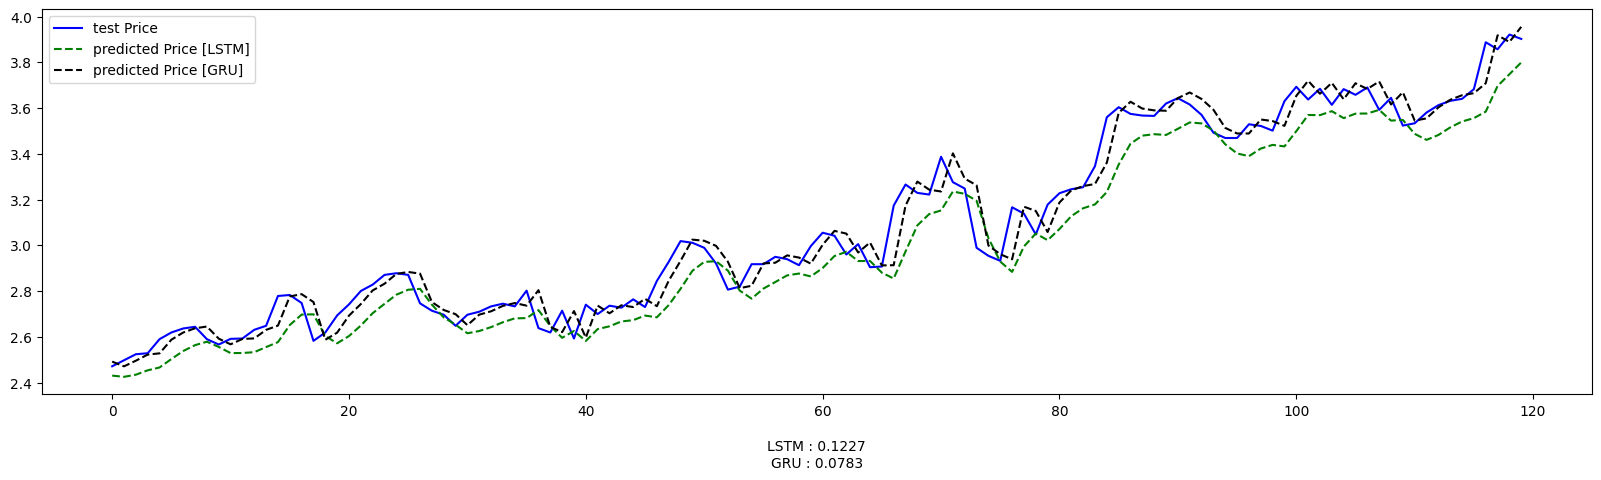

[*********************100%%**********************]  1 of 1 completed


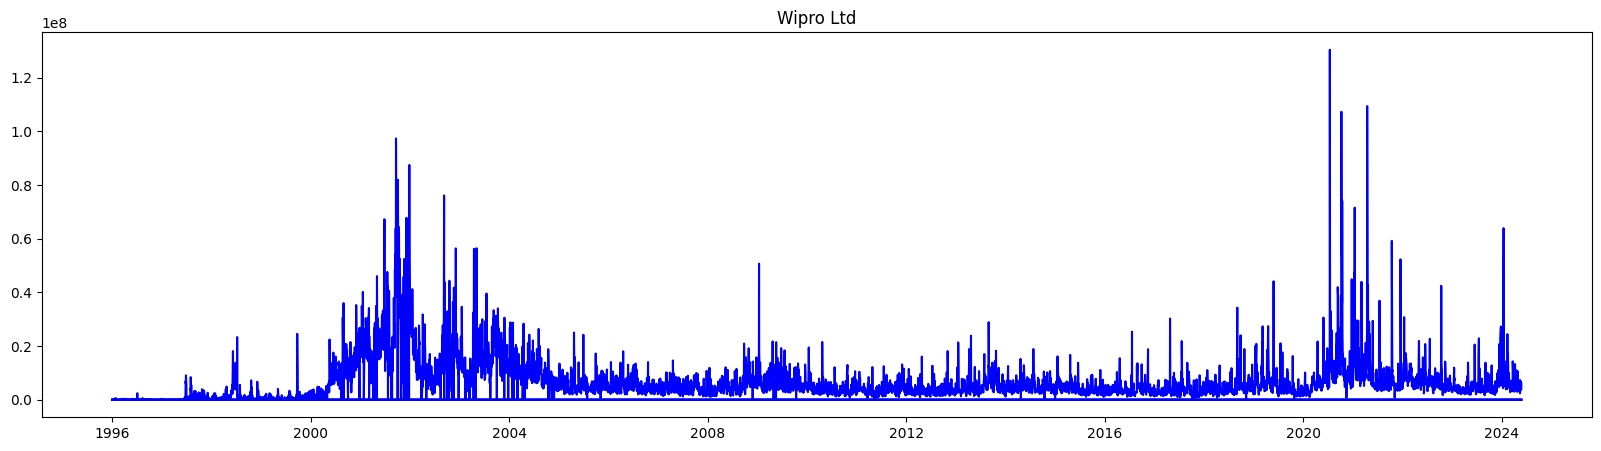

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 9428832256.0000
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 1530098.1250

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 1362613.5000
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 702754.1250
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 221837.2031
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 73167.9531
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 7054104.5000
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 6670560.0000
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 4567934.5000
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3701542.7500
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 3010902.0000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.1329
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0238

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0207
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0240
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0207
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0206
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0208
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0187
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0198
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0203
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


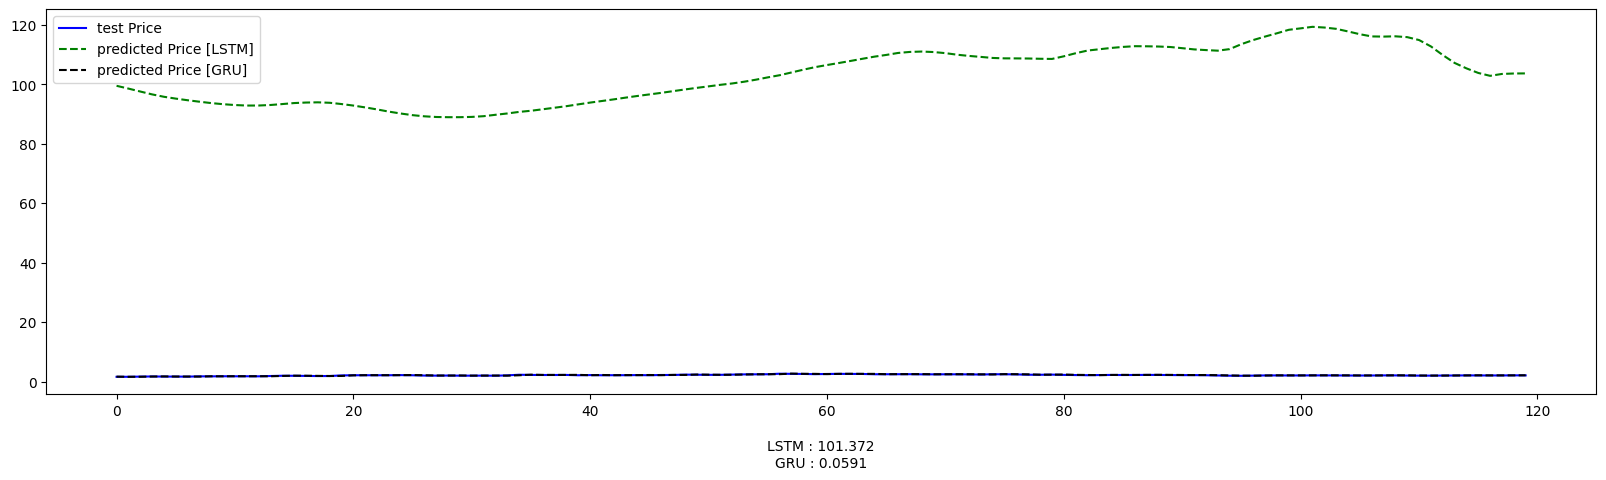

[*********************100%%**********************]  1 of 1 completed


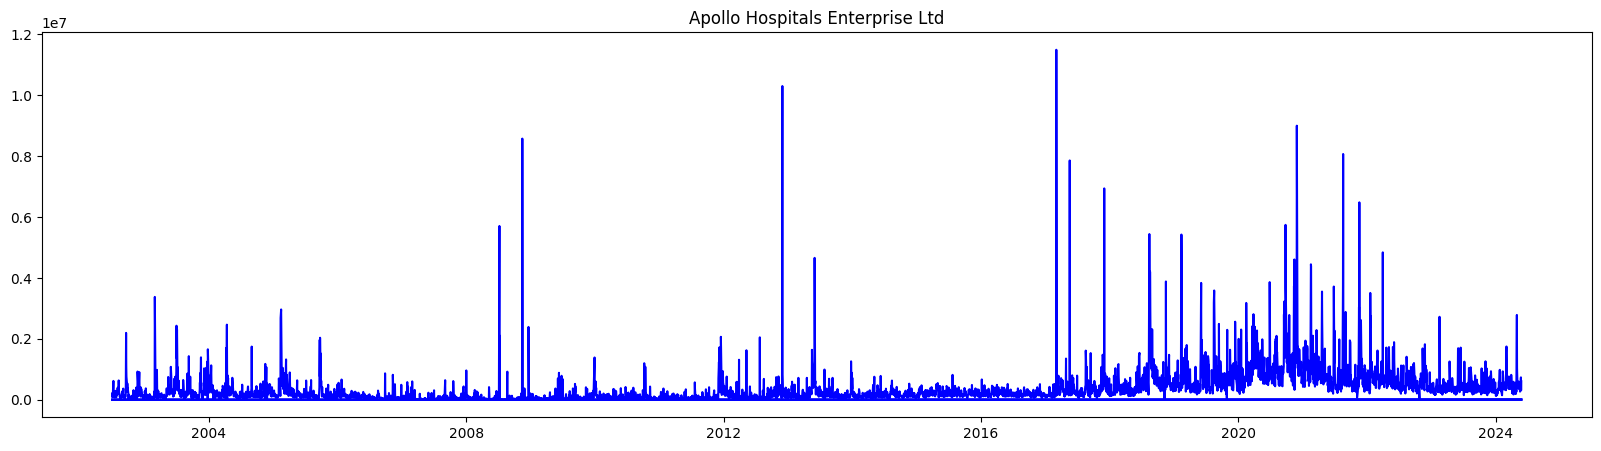

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.1699
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0394

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0205
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0185
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0171
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0173
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0203
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0172
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0185
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0179
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0168
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.1562
Epoch 2/10
  4/329 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0104 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0191
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0163
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0168
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0183
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0174
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0173
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0169
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0164
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0178
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


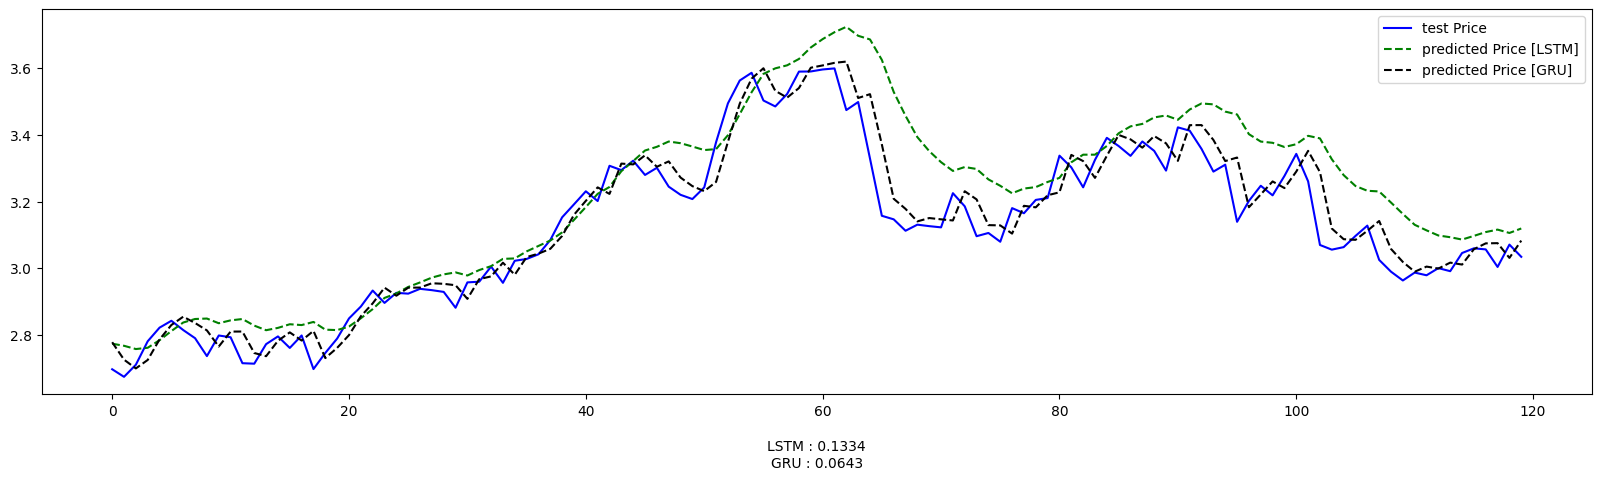

[*********************100%%**********************]  1 of 1 completed


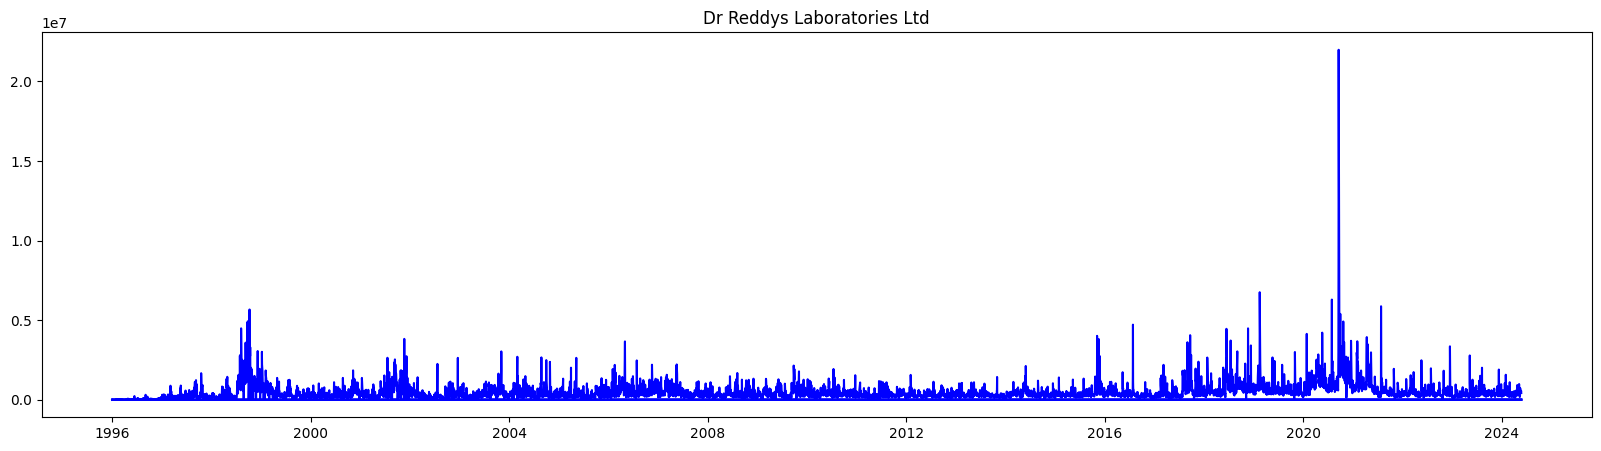

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.2258
Epoch 2/10
  6/435 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0299

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0260
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0245
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0211
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0210
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0204
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0217
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0219
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0203
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0185
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1489
Epoch 2/10
  6/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0255 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0267
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0255
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0273
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0260
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0245
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0235
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0254
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0244
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0275
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


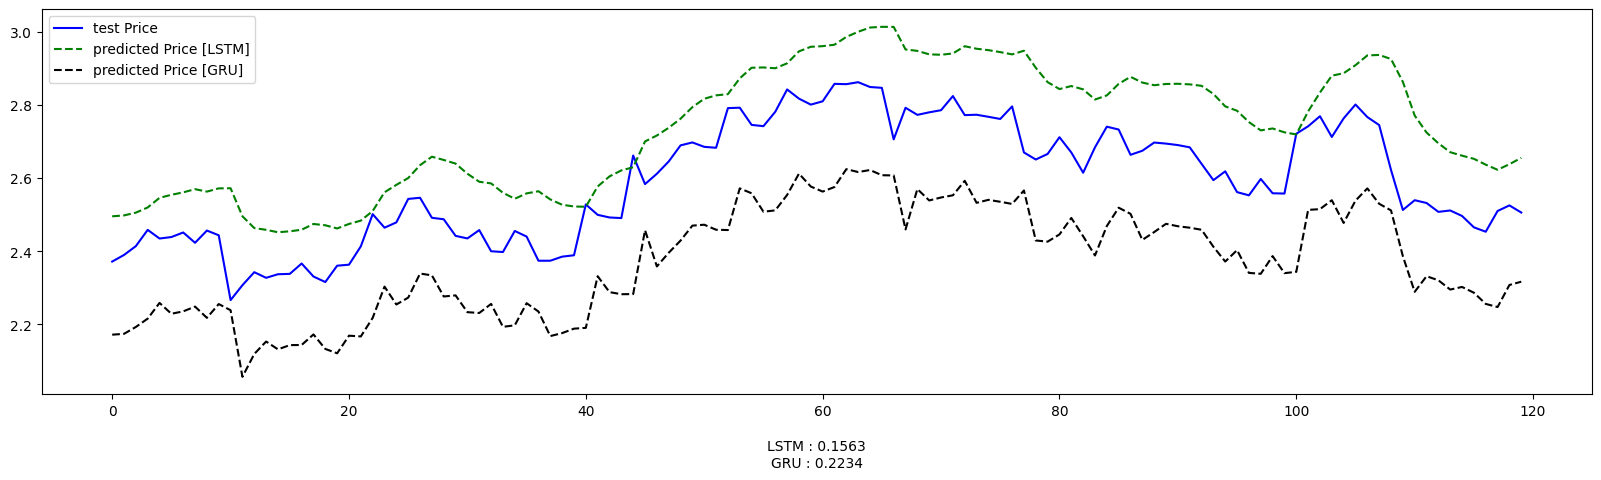

[*********************100%%**********************]  1 of 1 completed


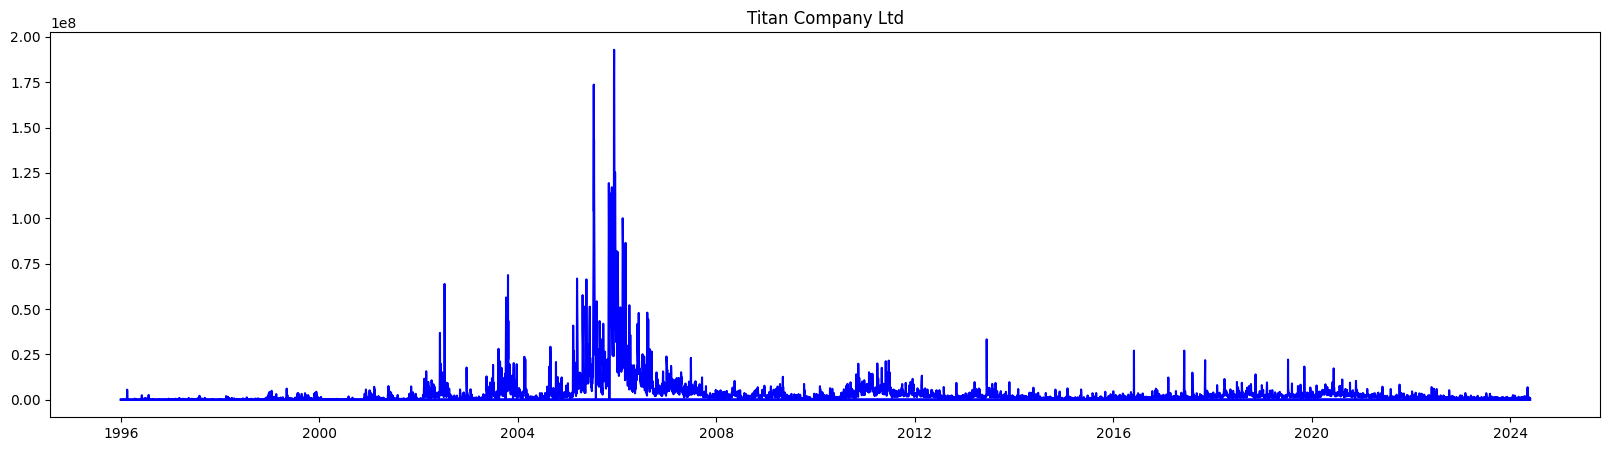

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 1118.7850
Epoch 2/10
  5/435 ━━━━━━━━━━━━━━━━━━━━ 12s 29ms/step - loss: 0.0266

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0245
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0215
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0201
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0189
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0180
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0170
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0180
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0166
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0163
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1250
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0408 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0257
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0227
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0241
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0258
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0221
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0235
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0232
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0238
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0209
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


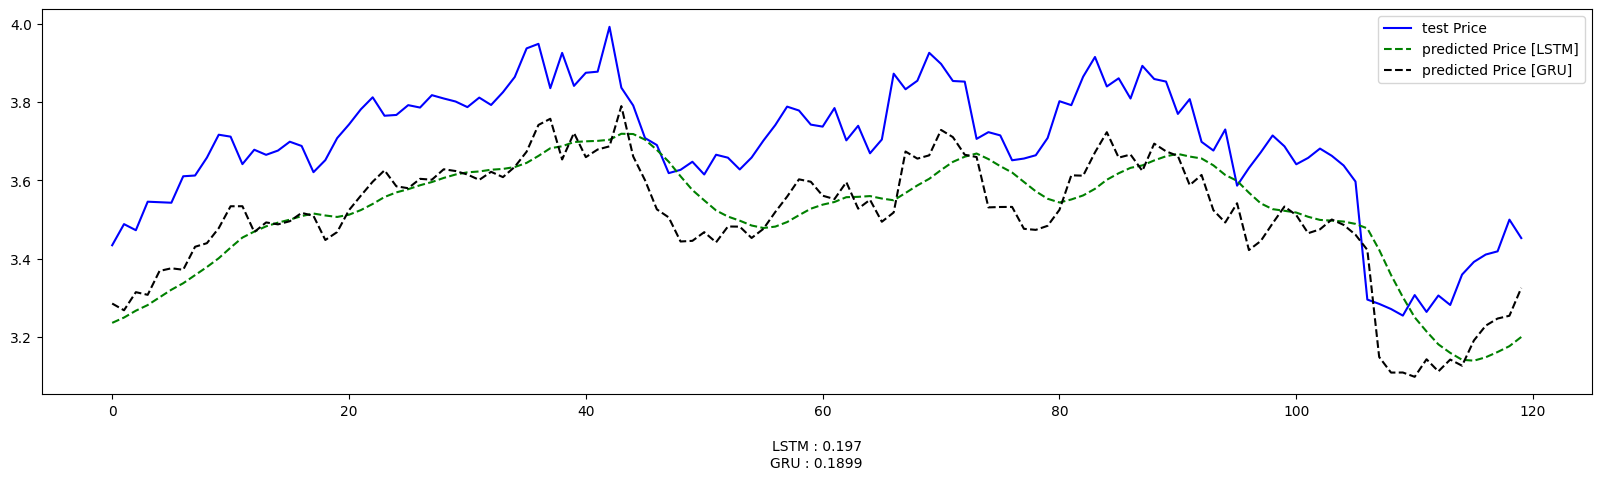

[*********************100%%**********************]  1 of 1 completed


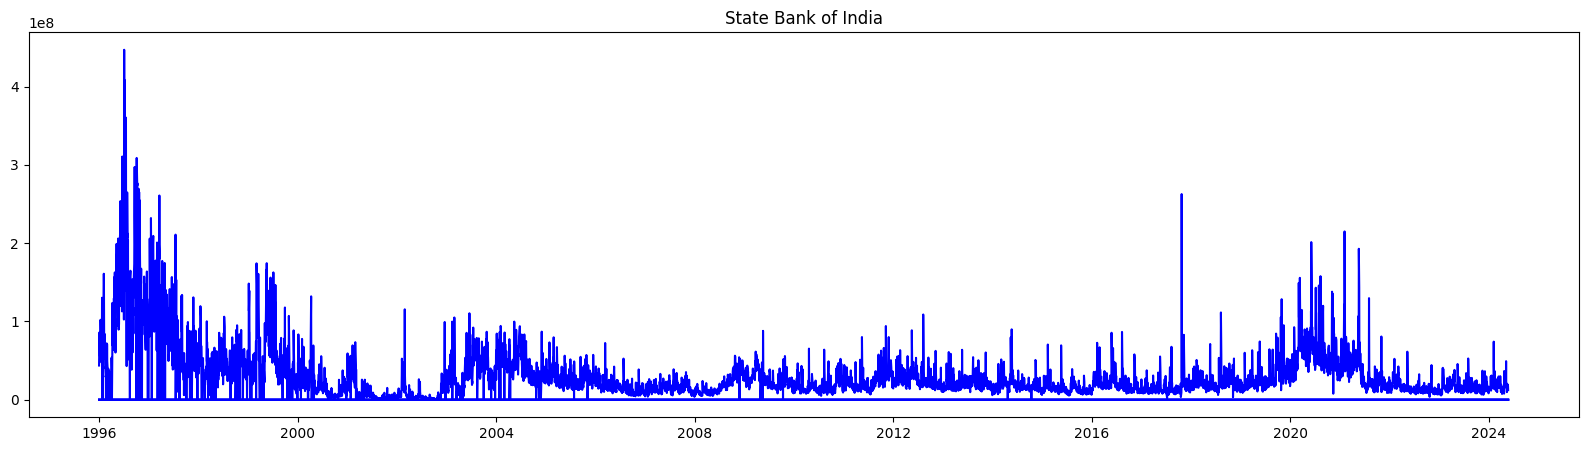

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.1453
Epoch 2/10
  4/435 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0321 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0224
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0212
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0194
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0200
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0212
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0199
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0220
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0195
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0189
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 12s 21ms/step - loss: 0.1615
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0383

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0242
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0198
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0196
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0211
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0182
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0218
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0203
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0198
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0209
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


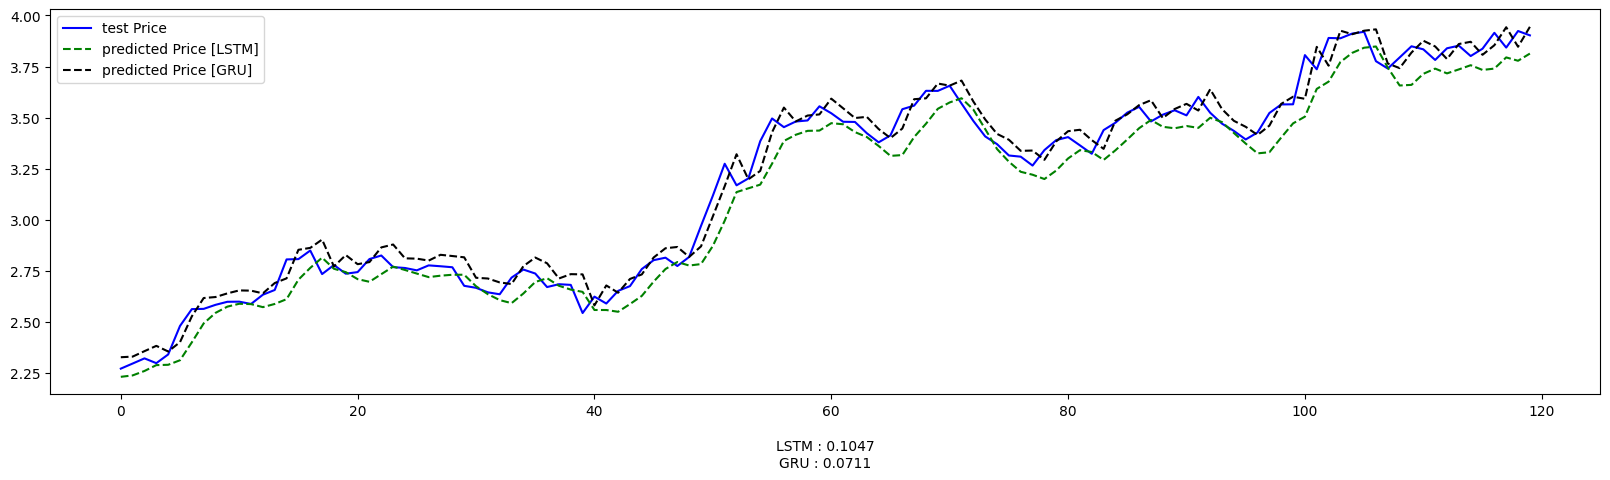

[*********************100%%**********************]  1 of 1 completed


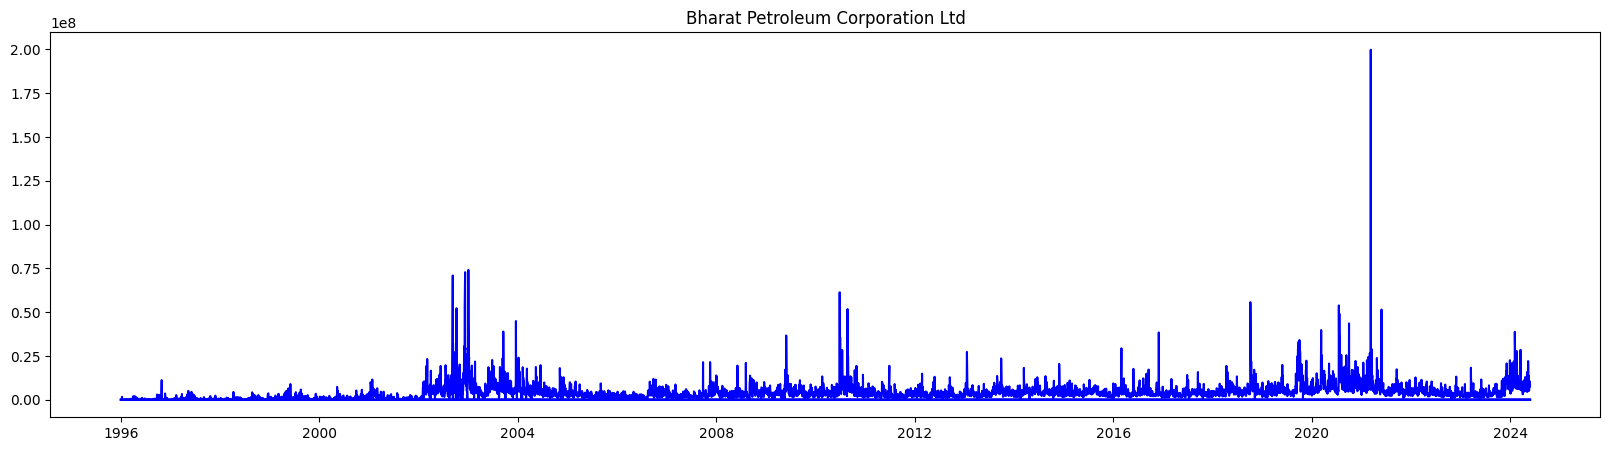

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 0.1374
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0227

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0251
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0232
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0257
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0254
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0234
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0250
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0225
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0221
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0220
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1139
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0150

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0186
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - loss: 0.0194
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0179
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0191
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0200
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0199
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0195
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0184
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0172
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


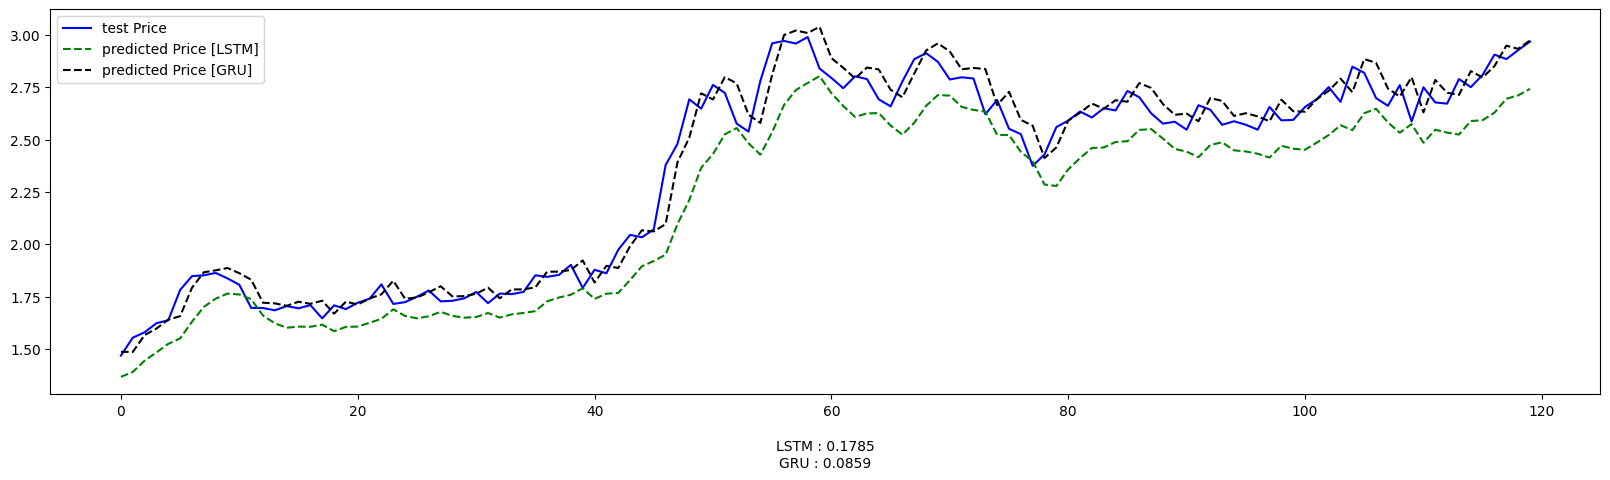

[*********************100%%**********************]  1 of 1 completed


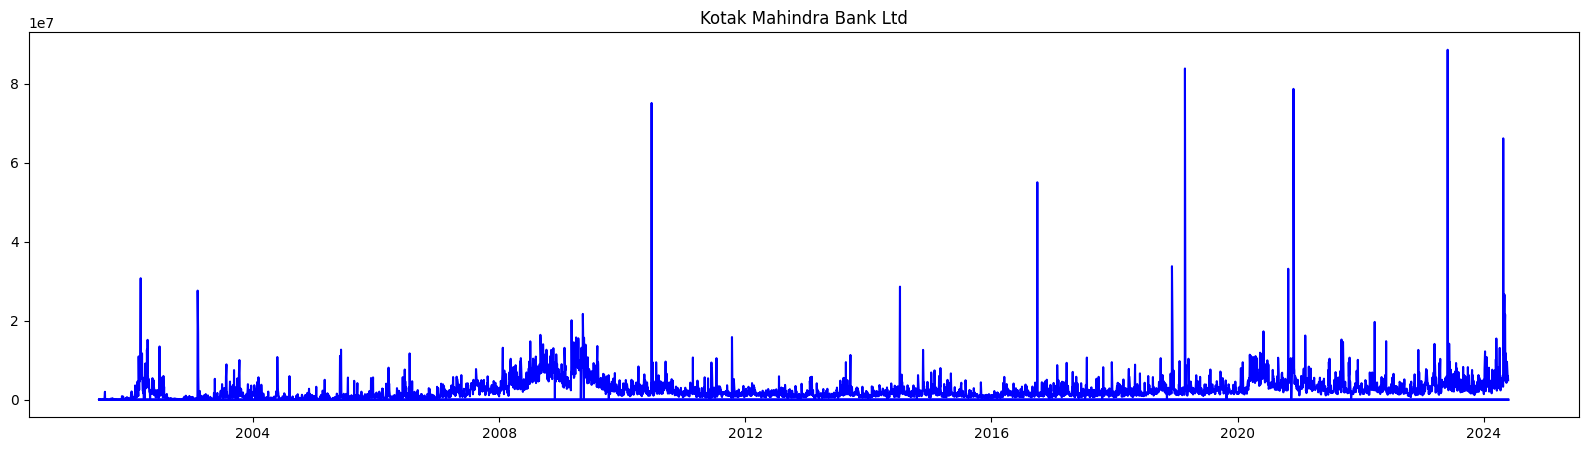

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 21.8324
Epoch 2/10
  4/345 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0637 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0361
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0295
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0285
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0240
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0249
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0238
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0222
Epoch 9/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0234
Epoch 10/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 0.0226
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.2293
Epoch 2/10
  6/345 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - loss: 0.0223 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0231
Epoch 3/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0214
Epoch 4/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0219
Epoch 5/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0198
Epoch 6/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0220
Epoch 7/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0208
Epoch 8/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0211
Epoch 9/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0197
Epoch 10/10
345/345 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 0.0221
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


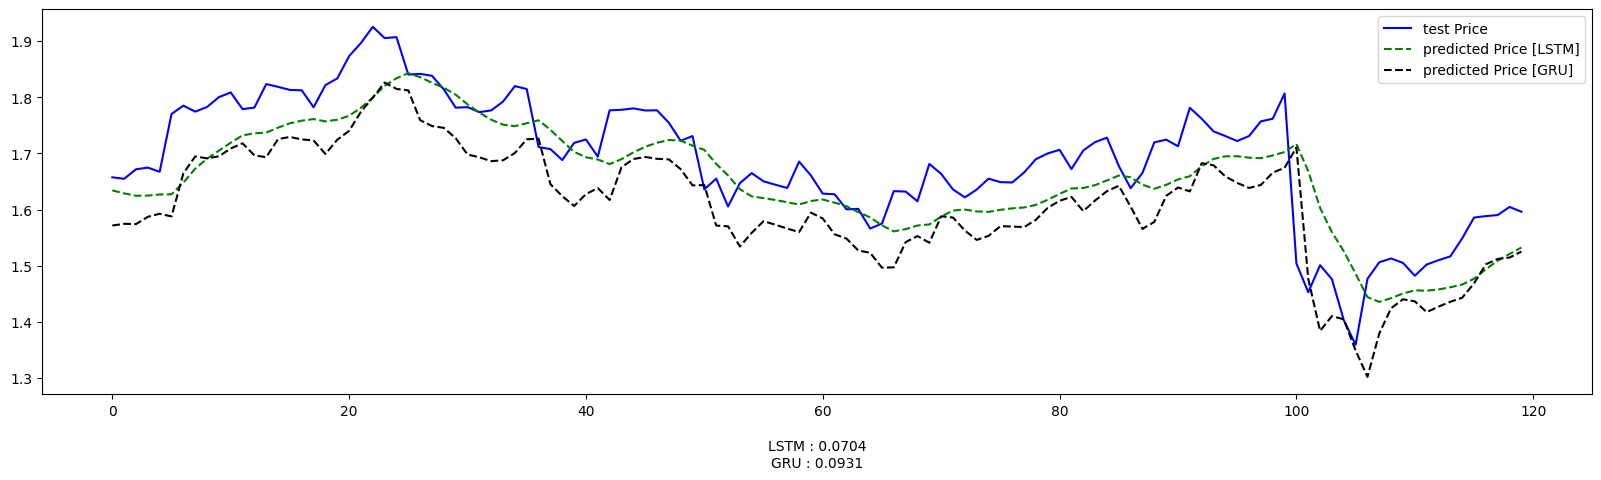

[*********************100%%**********************]  1 of 1 completed


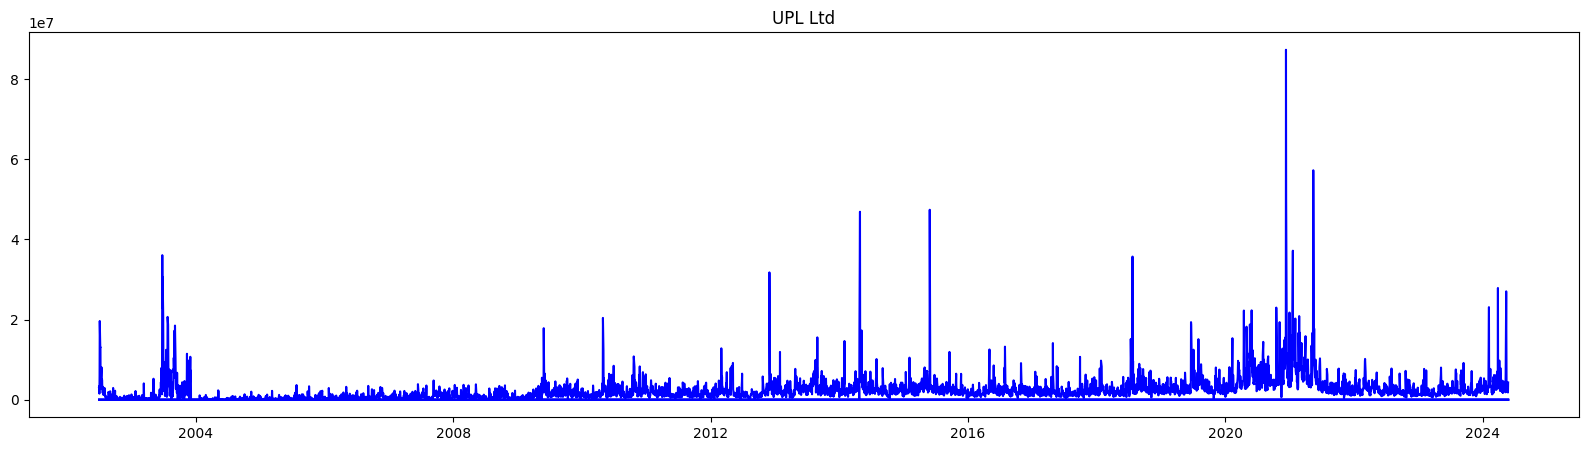

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 94.1817
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0250

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0349
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0321
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0314
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0286
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0281
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0280
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0286
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0290
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0267
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.2239
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0329

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0230
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0203
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0231
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0220
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0201
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0208
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0233
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0225
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0225
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


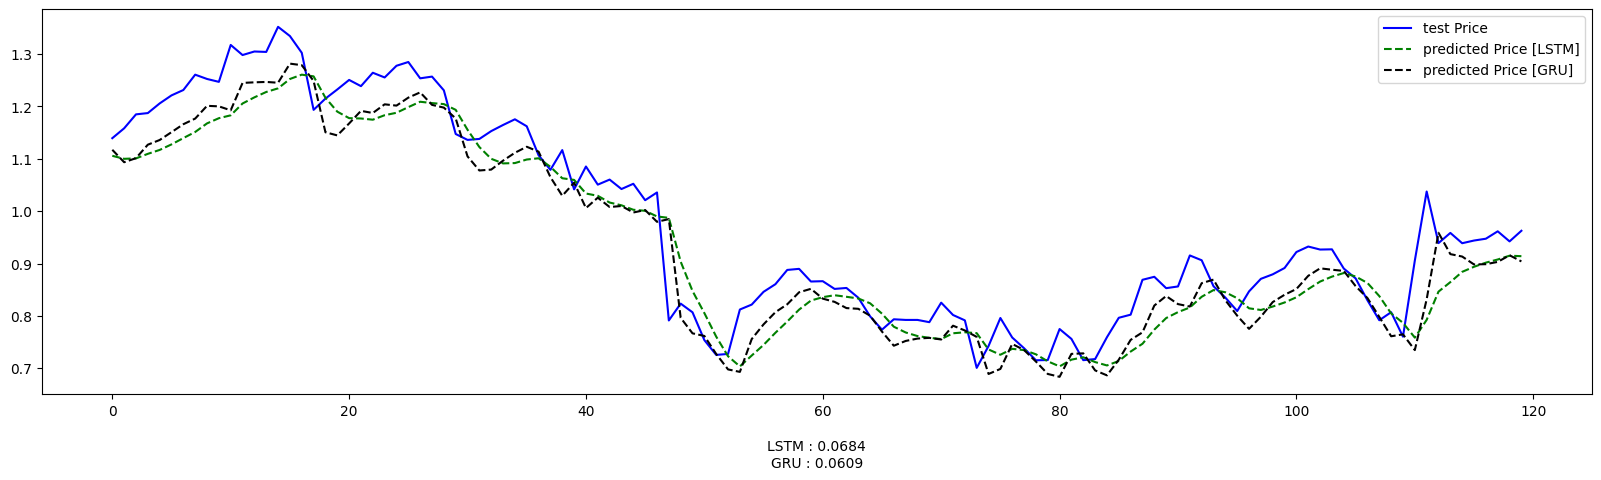

[*********************100%%**********************]  1 of 1 completed


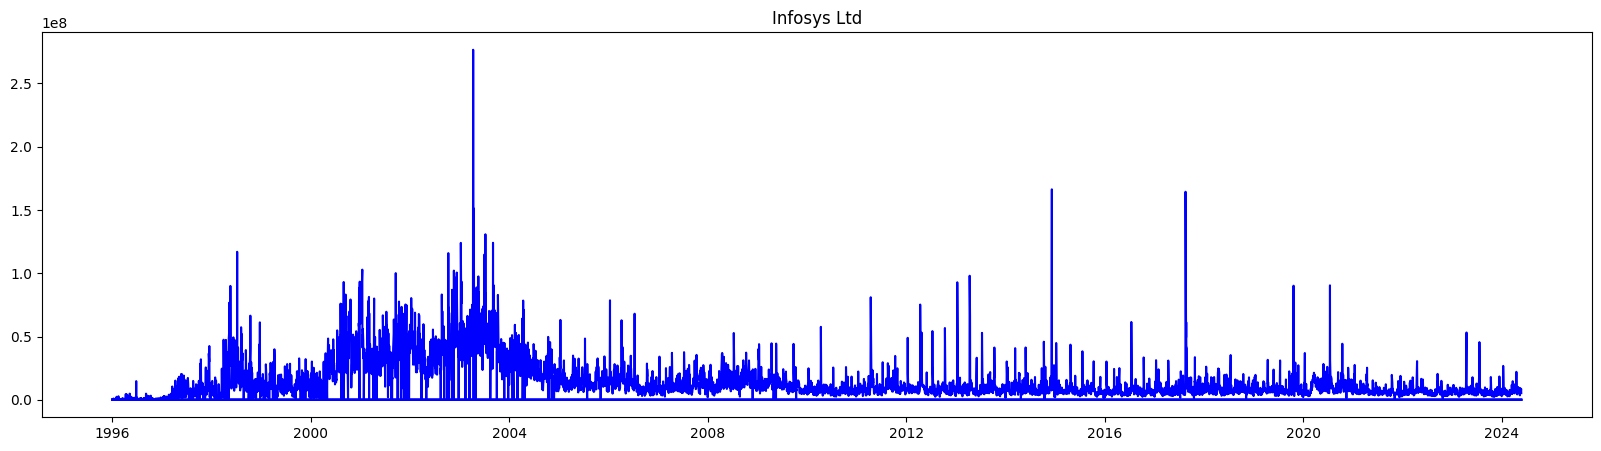

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - loss: 8.8752
Epoch 2/10
  6/435 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - loss: 0.0638

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0339
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0279
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0244
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0208
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0204
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.0211
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0192
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0217
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0203
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 20ms/step - loss: 0.1283
Epoch 2/10
  6/435 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - loss: 0.0202

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0205
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0207
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0186
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0216
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0189
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0215
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0198
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0192
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0205
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


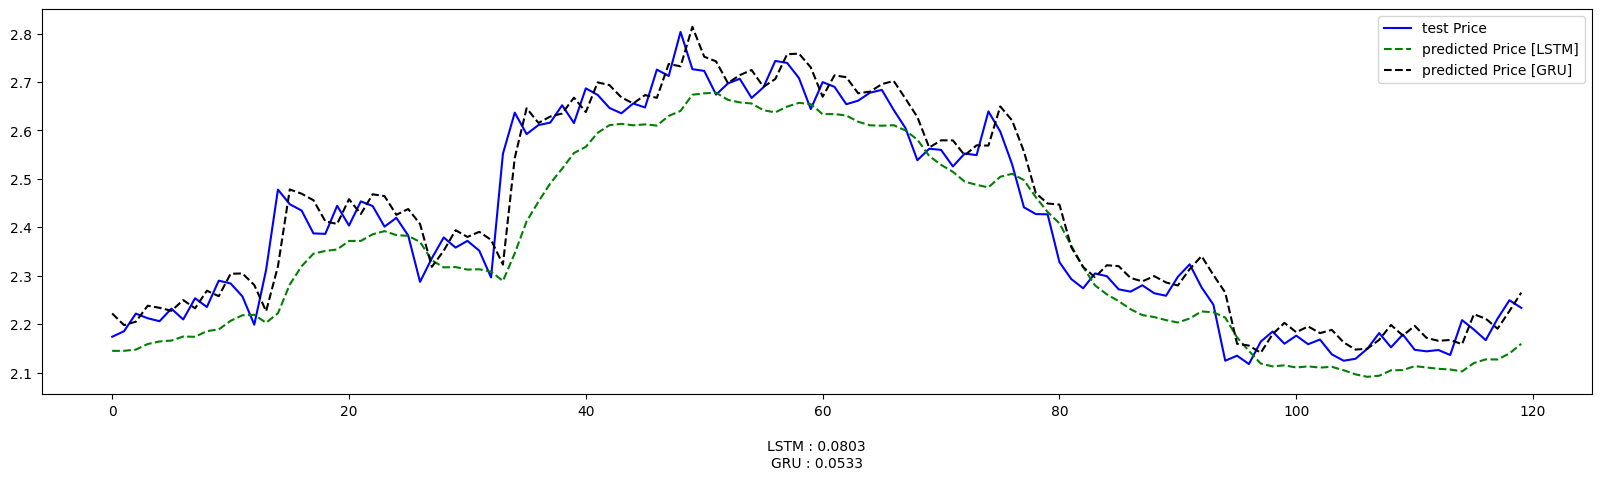

[*********************100%%**********************]  1 of 1 completed


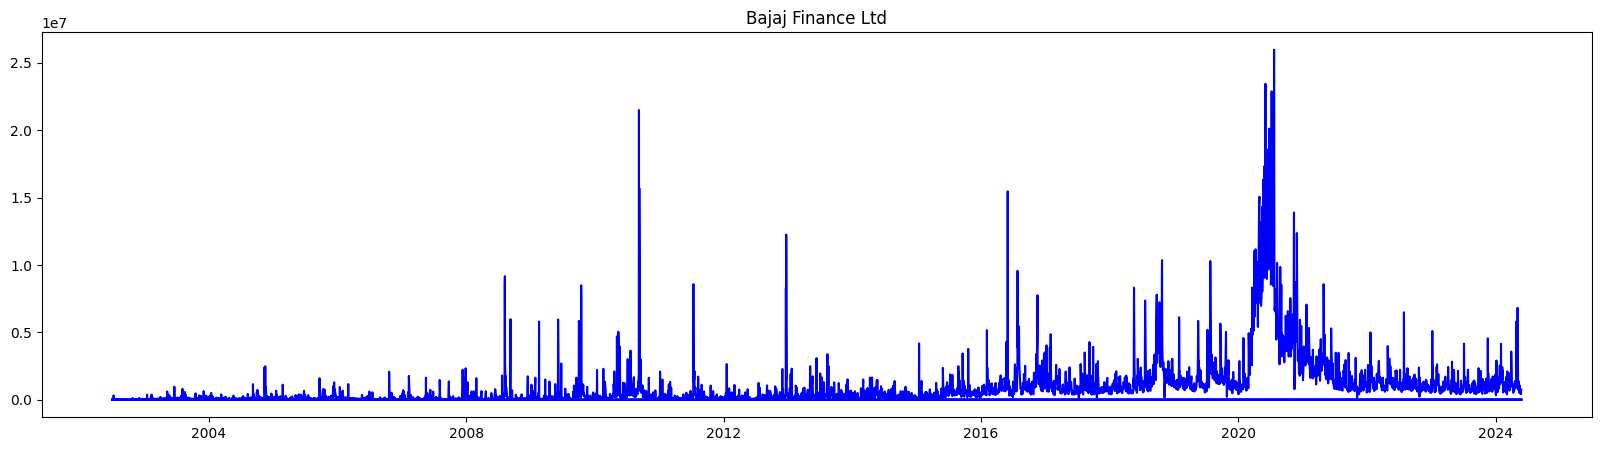

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.1632
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0218

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0213
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0196
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0193
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0185
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0194
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0181
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0193
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0194
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0187
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1799
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0236

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0243
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0222
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0221
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0206
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0212
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0196
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0205
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0232
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0192
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


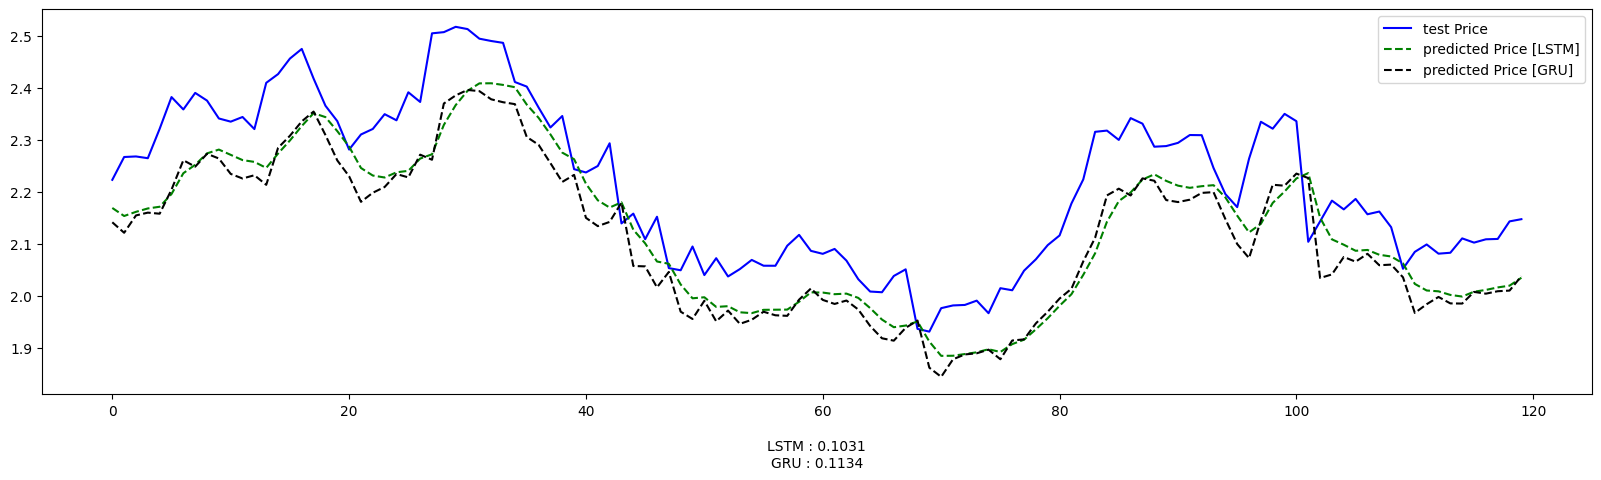

[*********************100%%**********************]  1 of 1 completed


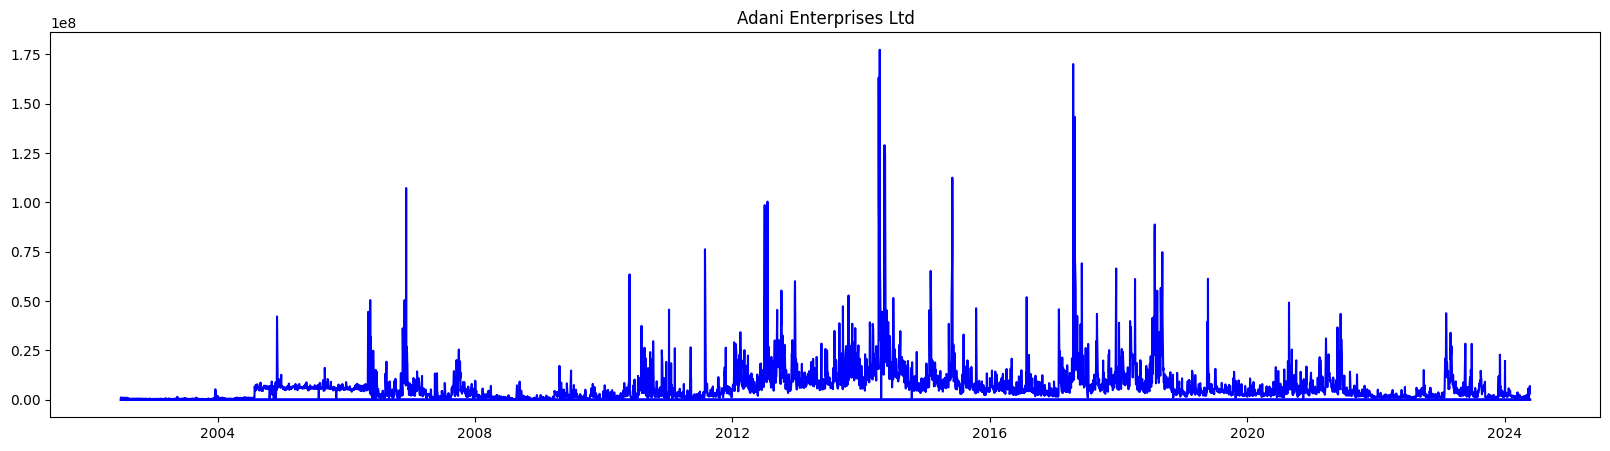

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 261507.1094
Epoch 2/10
  6/329 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0595

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0814
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0446
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0246
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0195
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0215
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0178
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0161
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0160
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0144
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.1814
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0499

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0306
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0223
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0221
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0193
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0205
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0194
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0174
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0257
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0230
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


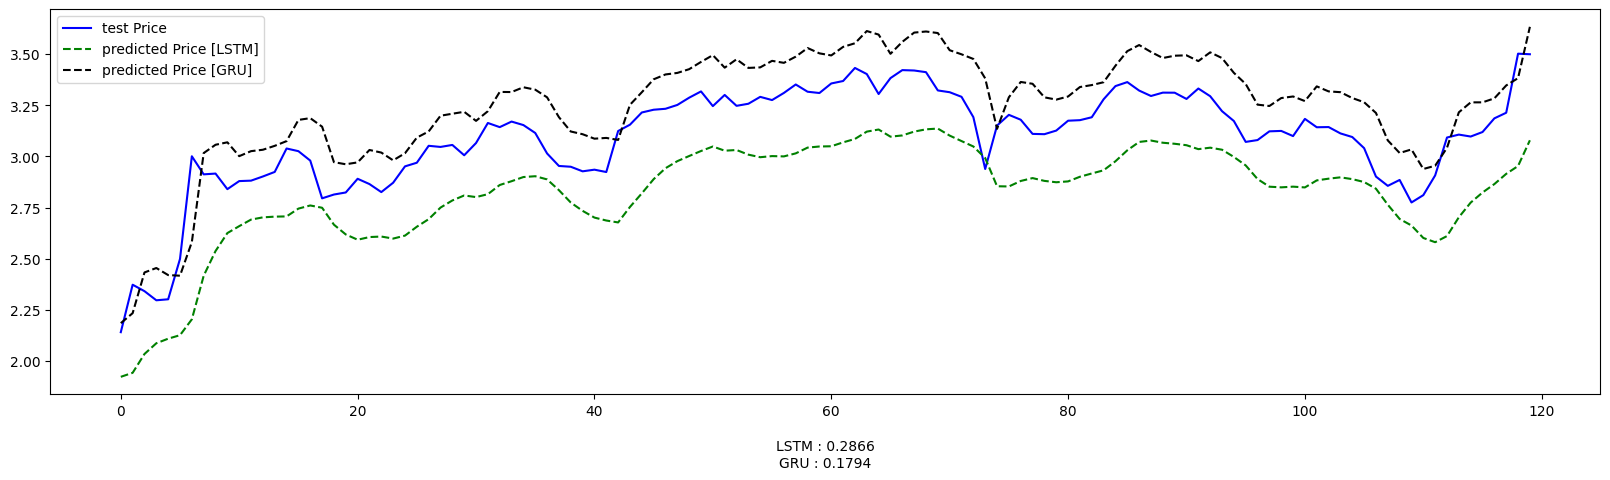

[*********************100%%**********************]  1 of 1 completed


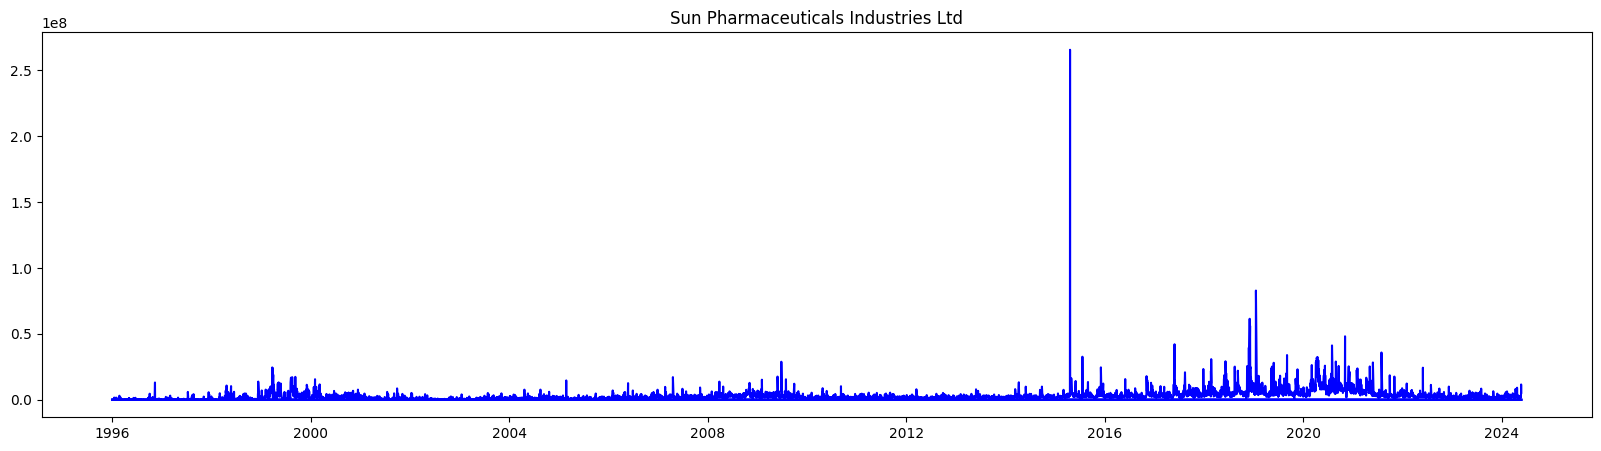

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 47282.9648
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0382

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0500
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0372
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0341
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0291
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0301
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0258
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0236
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0241
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0228
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1403
Epoch 2/10
  4/435 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0177 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0194
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - loss: 0.0174
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0171
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0188
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0166
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0164
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0162
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0160
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0167
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


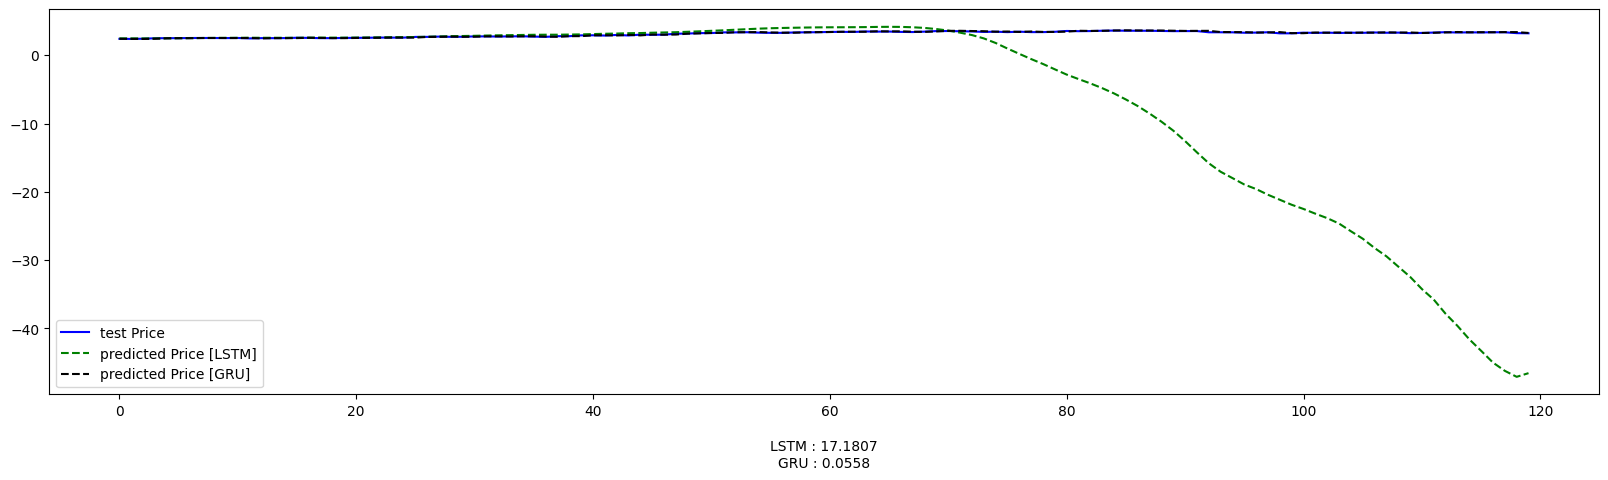

[*********************100%%**********************]  1 of 1 completed


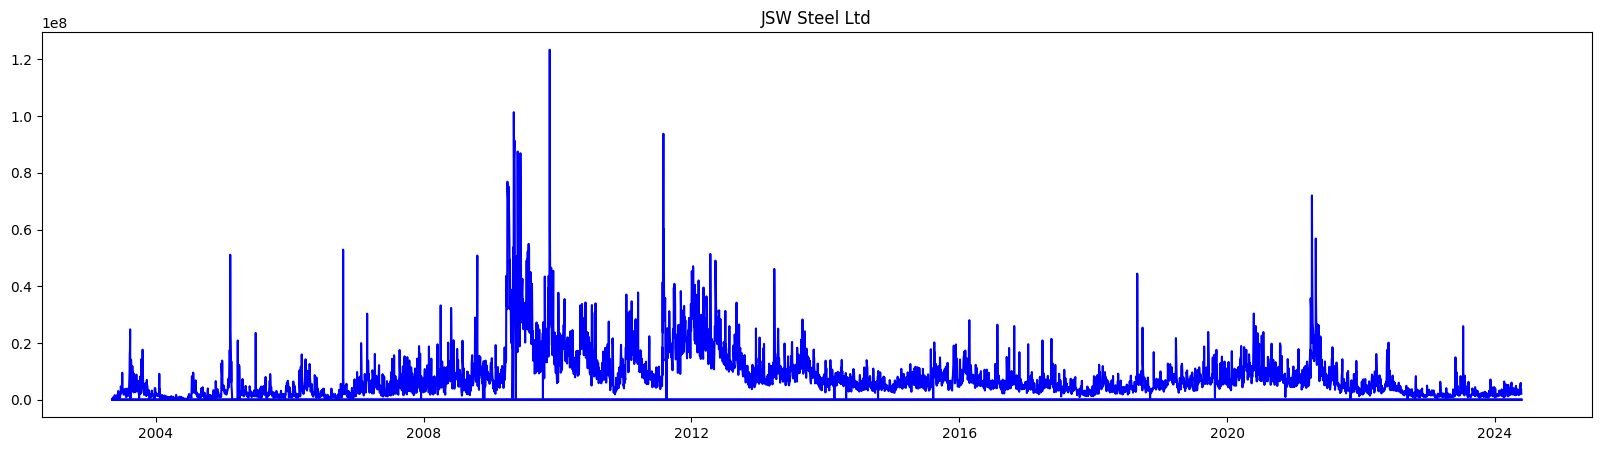

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.1255
Epoch 2/10
  7/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0358

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0198
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0181
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0185
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0164
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0186
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0170
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0172
Epoch 9/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0195
Epoch 10/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0184
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.1051
Epoch 2/10
  7/315 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0408

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0209
Epoch 3/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0193
Epoch 4/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0177
Epoch 5/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0205
Epoch 6/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0173
Epoch 7/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0180
Epoch 8/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0182
Epoch 9/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0182
Epoch 10/10
315/315 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0184
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


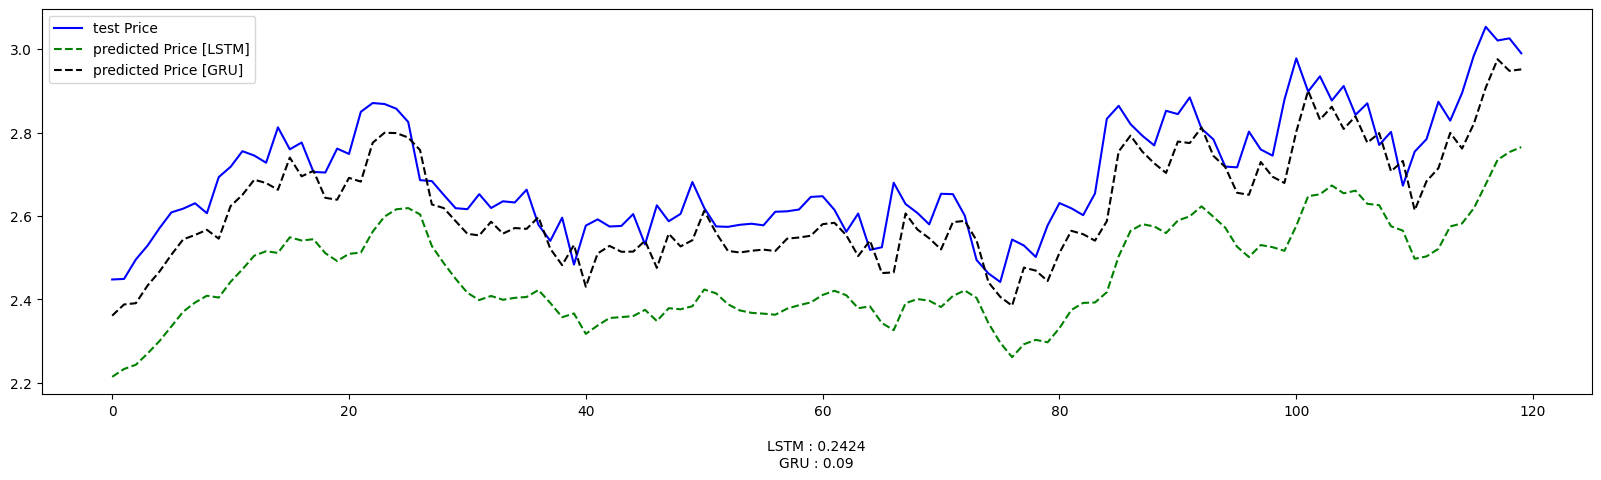

[*********************100%%**********************]  1 of 1 completed


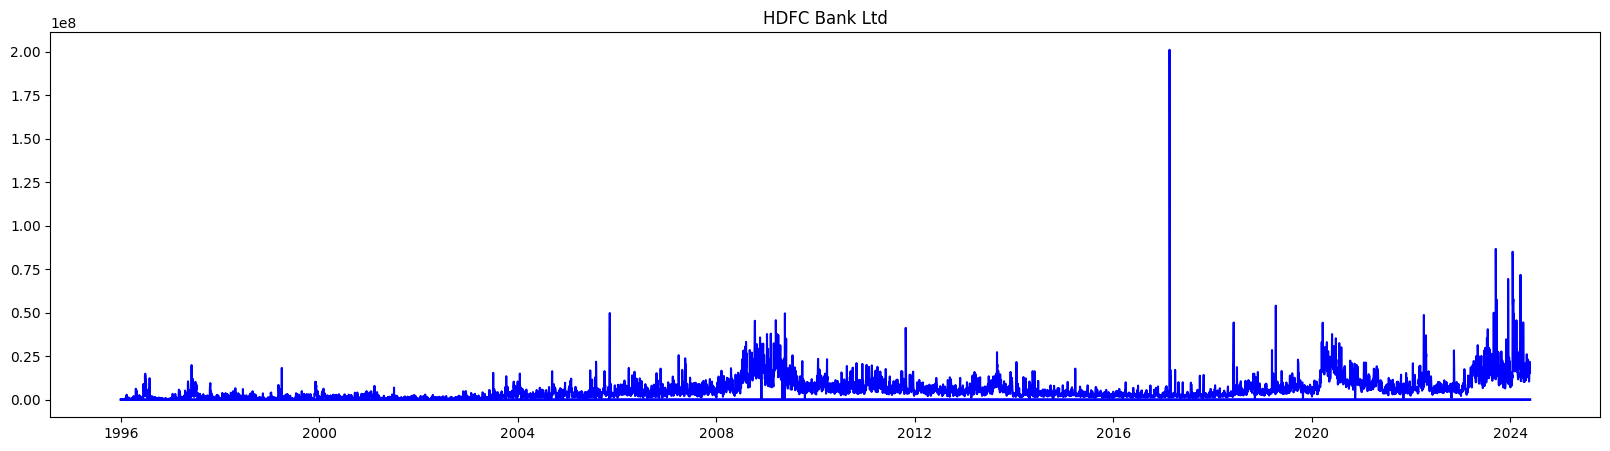

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.1129
Epoch 2/10
  4/435 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.0303 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0217
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0195
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0194
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.0205
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0198
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0208
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0207
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0204
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0203
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1699
Epoch 2/10
  4/435 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - loss: 0.0215 

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0213
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.0198
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0206
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0190
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0188
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0186
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0192
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0190
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0201
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


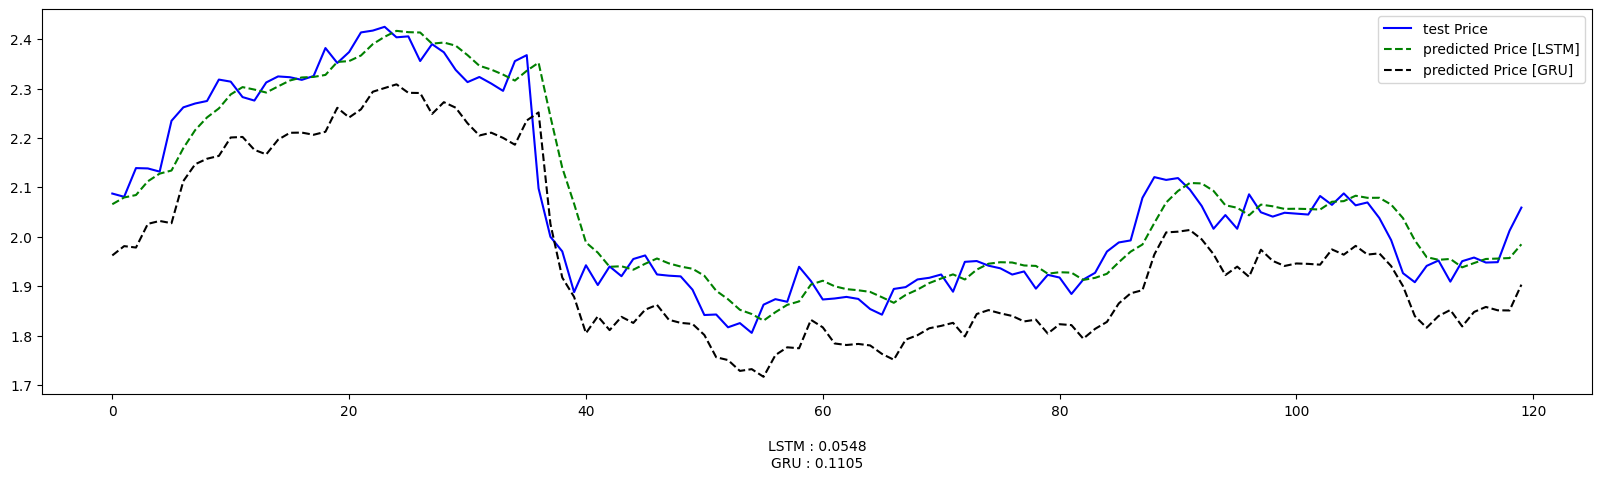

[*********************100%%**********************]  1 of 1 completed


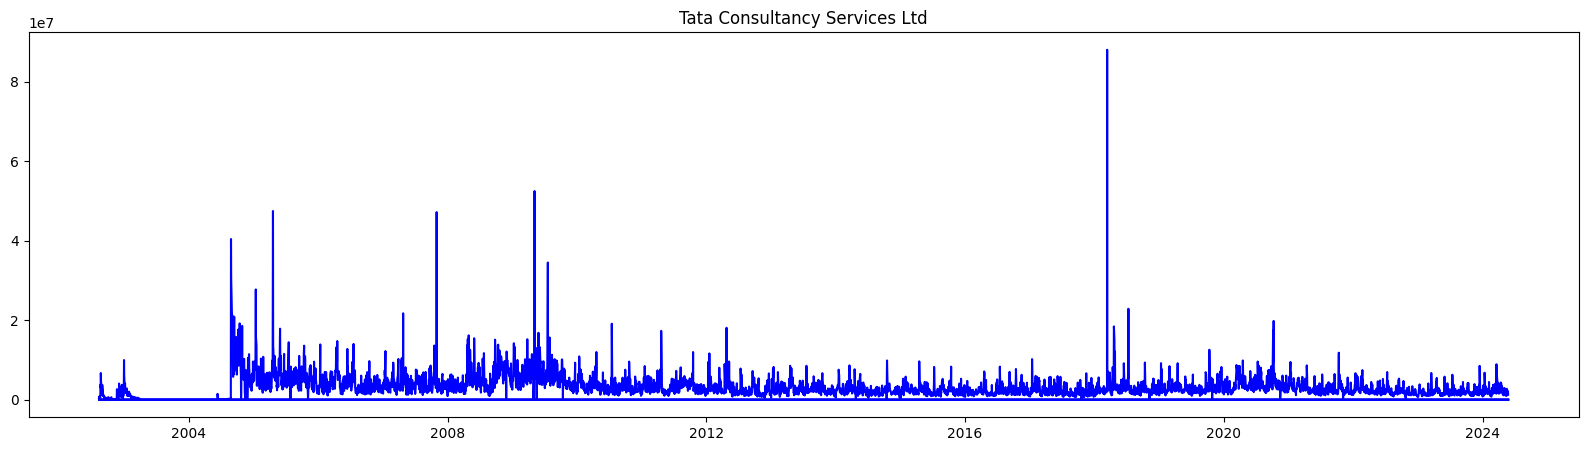

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 348.6830
Epoch 2/10
  7/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0623

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0480
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0439
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0347
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0247
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0246
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0217
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0226
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0212
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0210
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1722
Epoch 2/10
  6/327 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0248

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0220
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0205
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0203
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0201
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0191
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0186
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0202
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0212
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0183
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


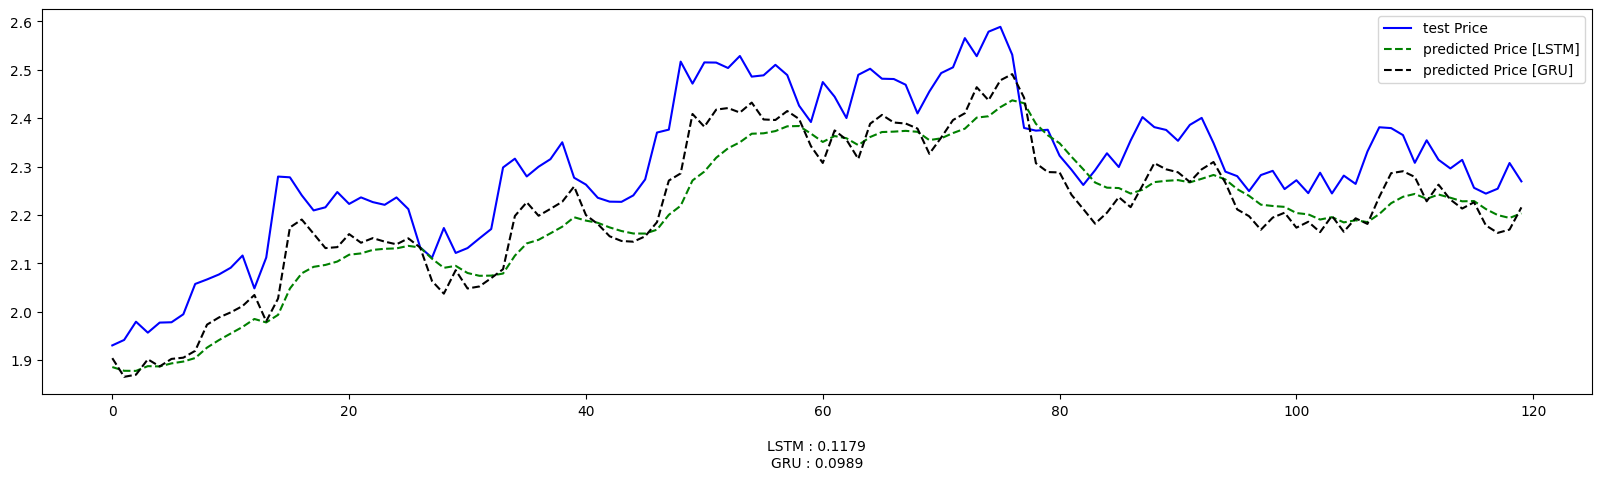

[*********************100%%**********************]  1 of 1 completed


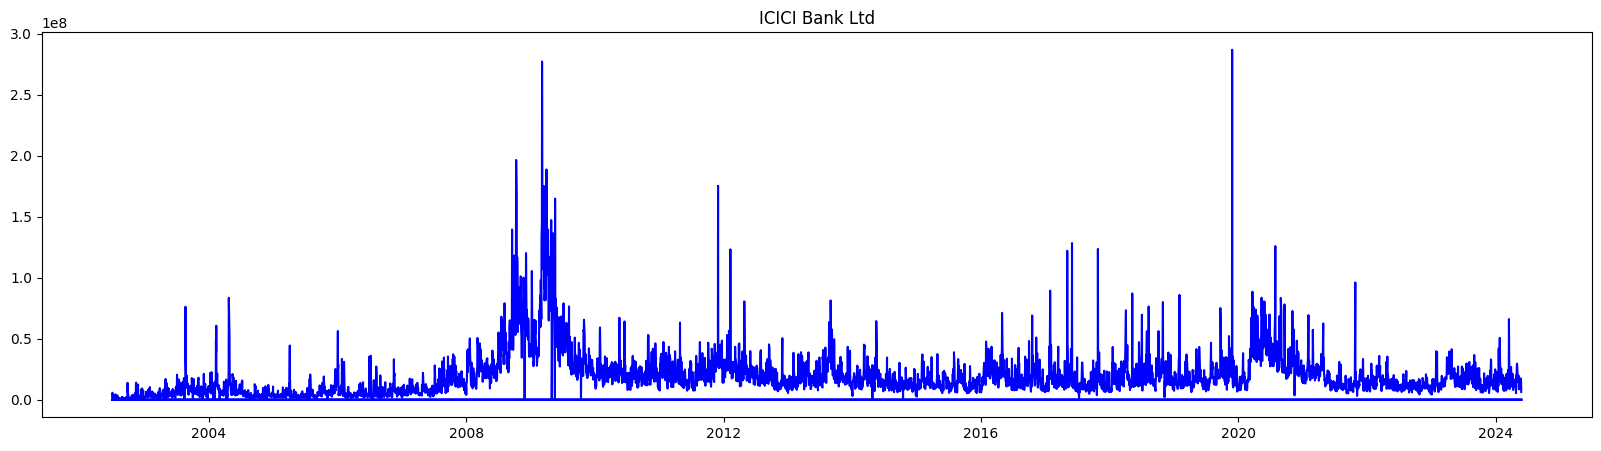

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.1458
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0339

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0231
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0197
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0191
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0180
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0182
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0170
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0188
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0191
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0171
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1582
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0179

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0204
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0203
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0193
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0165
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0185
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0173
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0183
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0199
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0191
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


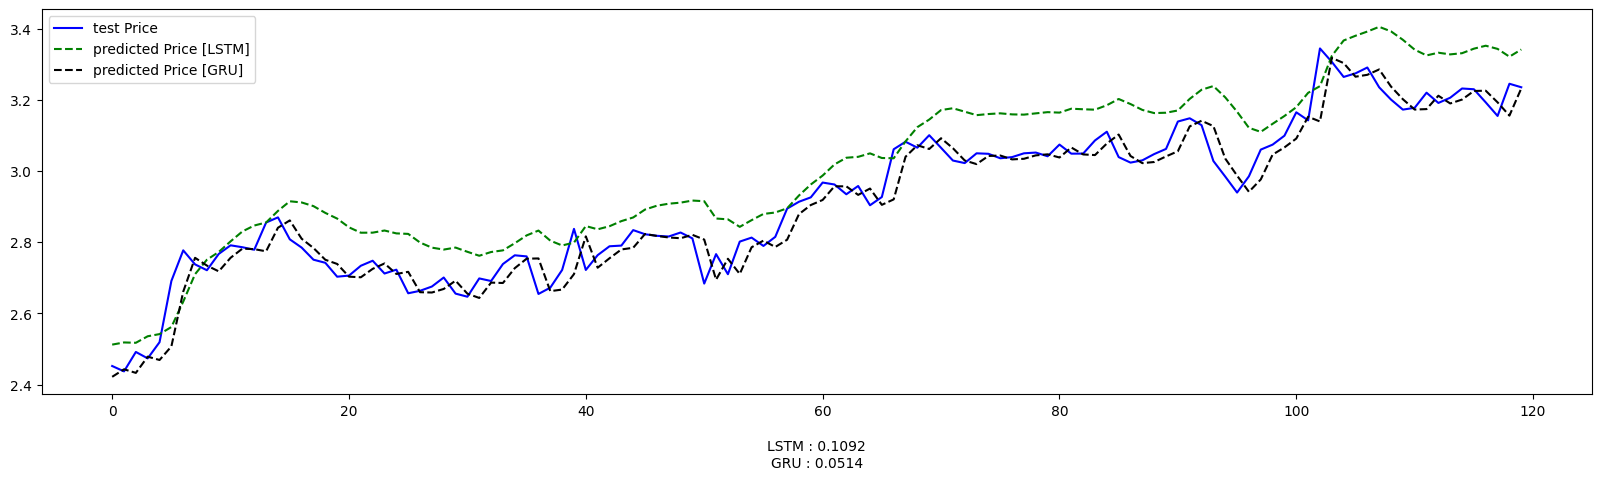

[*********************100%%**********************]  1 of 1 completed


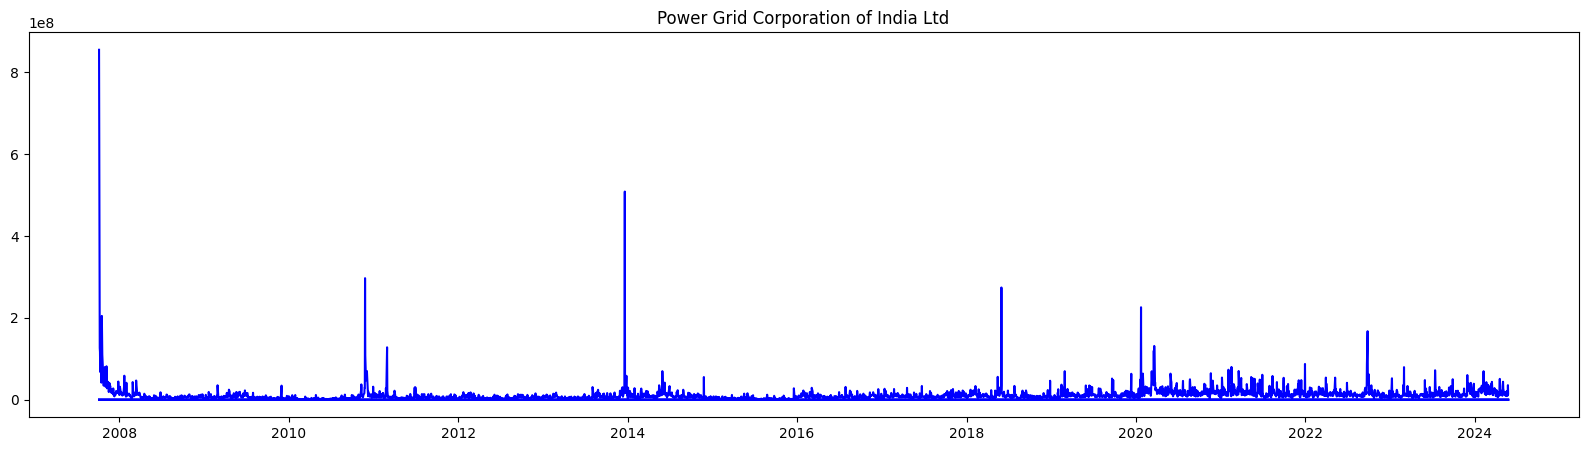

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.1601
Epoch 2/10
  7/245 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0174

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0182
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0167
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0154
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0148
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0129
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0134
Epoch 8/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0143
Epoch 9/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0134
Epoch 10/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0133
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.1427
Epoch 2/10
  7/245 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0206

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0208
Epoch 3/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0176
Epoch 4/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0164
Epoch 5/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0165
Epoch 6/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0161
Epoch 7/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0143
Epoch 8/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0149
Epoch 9/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0155
Epoch 10/10
245/245 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0164
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


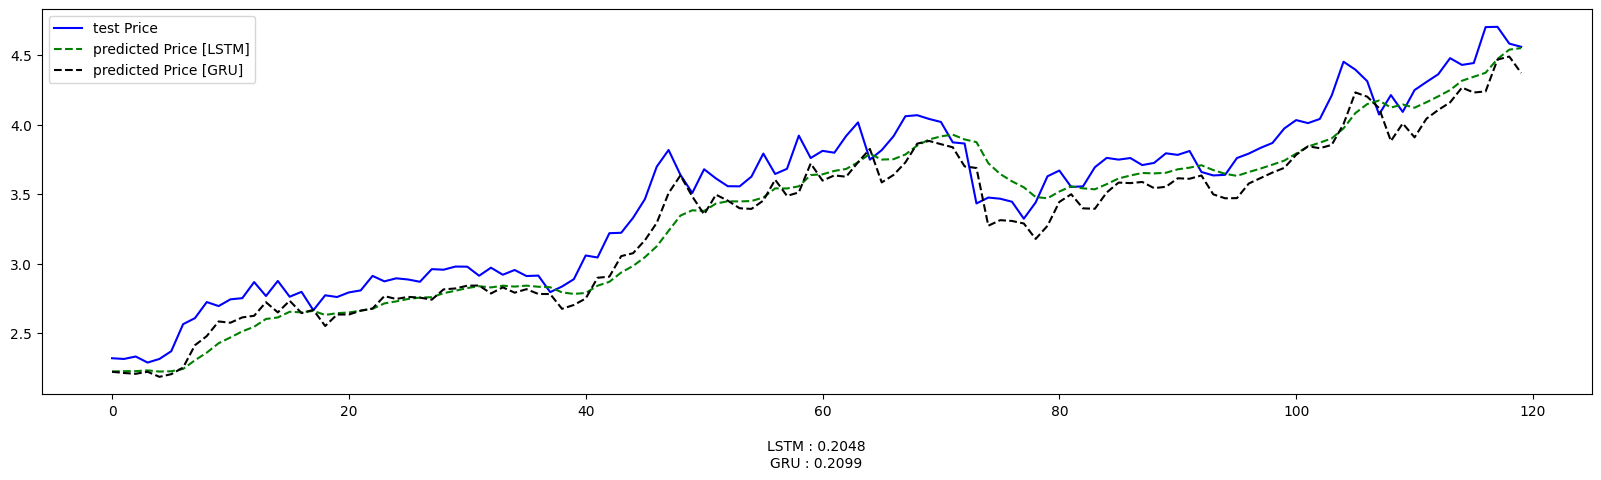

[*********************100%%**********************]  1 of 1 completed


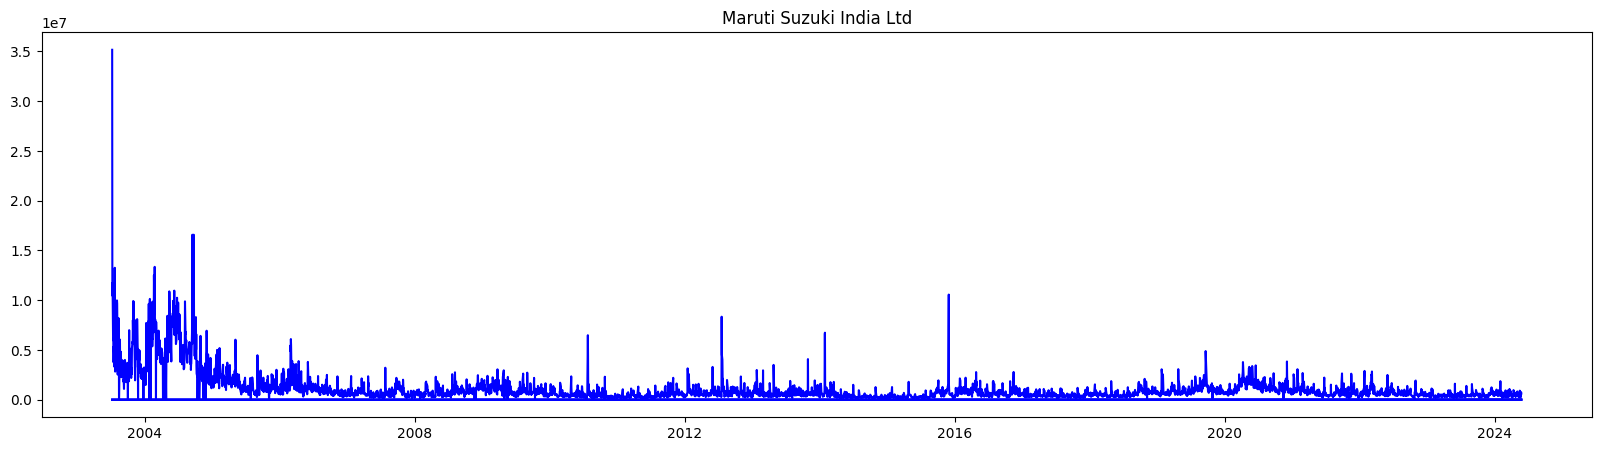

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 11.3086
Epoch 2/10
  9/312 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0340

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0276
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0248
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0245
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0229
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0219
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0209
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0198
Epoch 9/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.0222
Epoch 10/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0196
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.1958
Epoch 2/10
 12/312 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 0.0211

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0221
Epoch 3/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0219
Epoch 4/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0225
Epoch 5/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0233
Epoch 6/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0217
Epoch 7/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0217
Epoch 8/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0228
Epoch 9/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0212
Epoch 10/10
312/312 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.0206
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


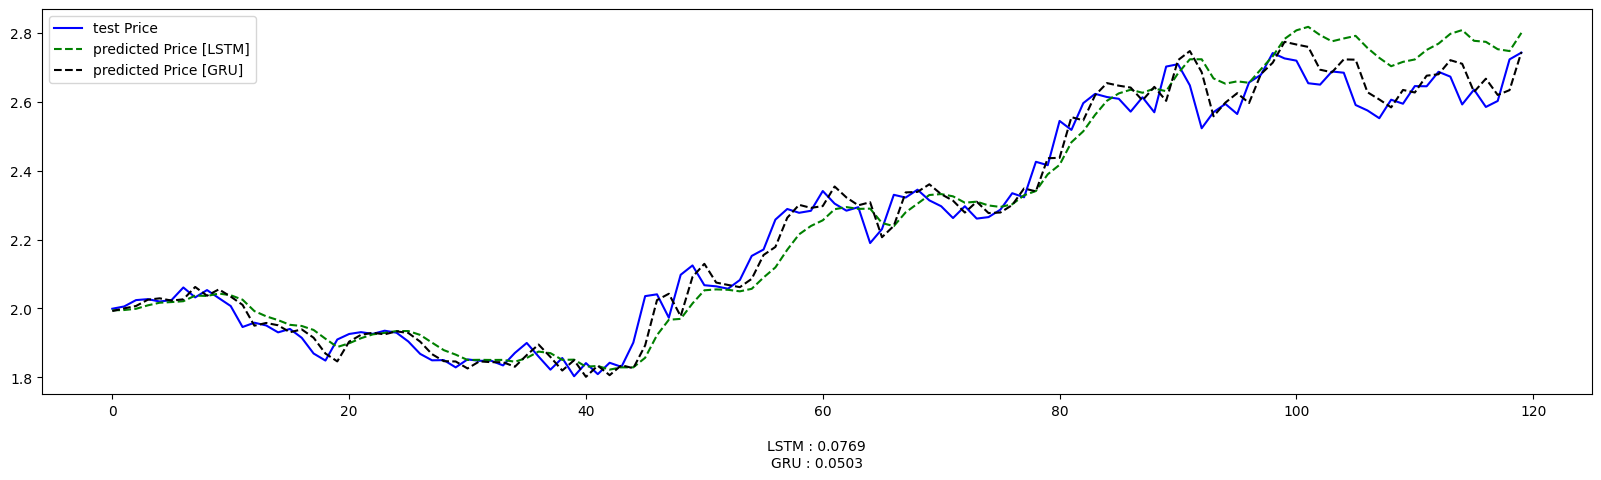

[*********************100%%**********************]  1 of 1 completed


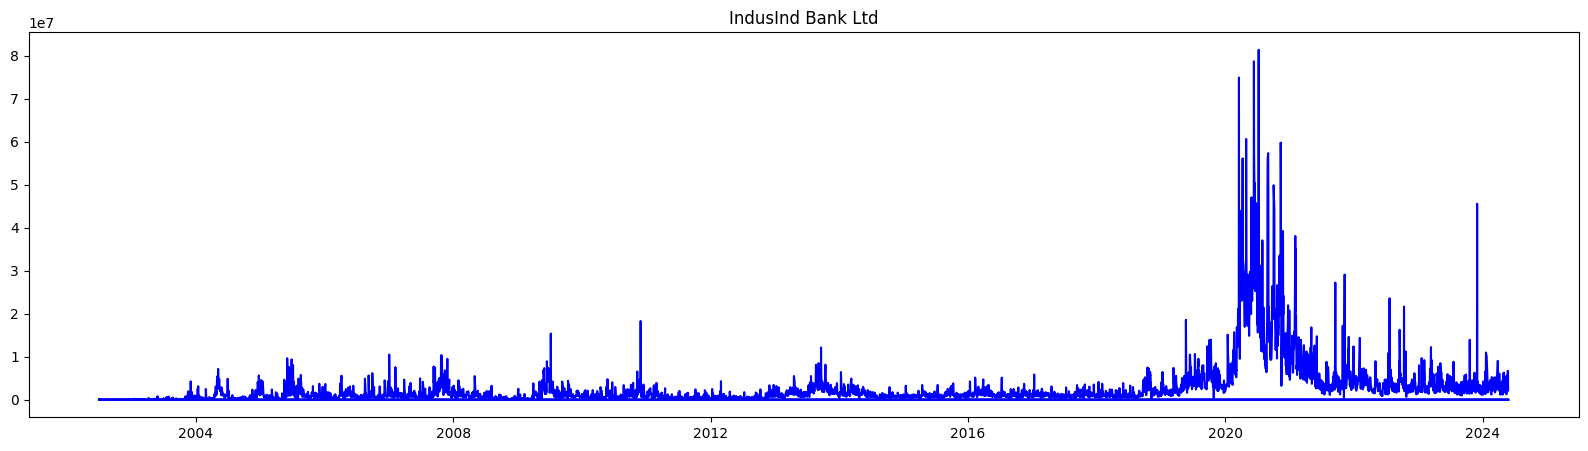

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.1702
Epoch 2/10
 10/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0200

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0255
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0216
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0229
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0213
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0219
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0212
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0192
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0199
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0206
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1762
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0311

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0250
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0241
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0259
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0234
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0244
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0227
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0223
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0224
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0245
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


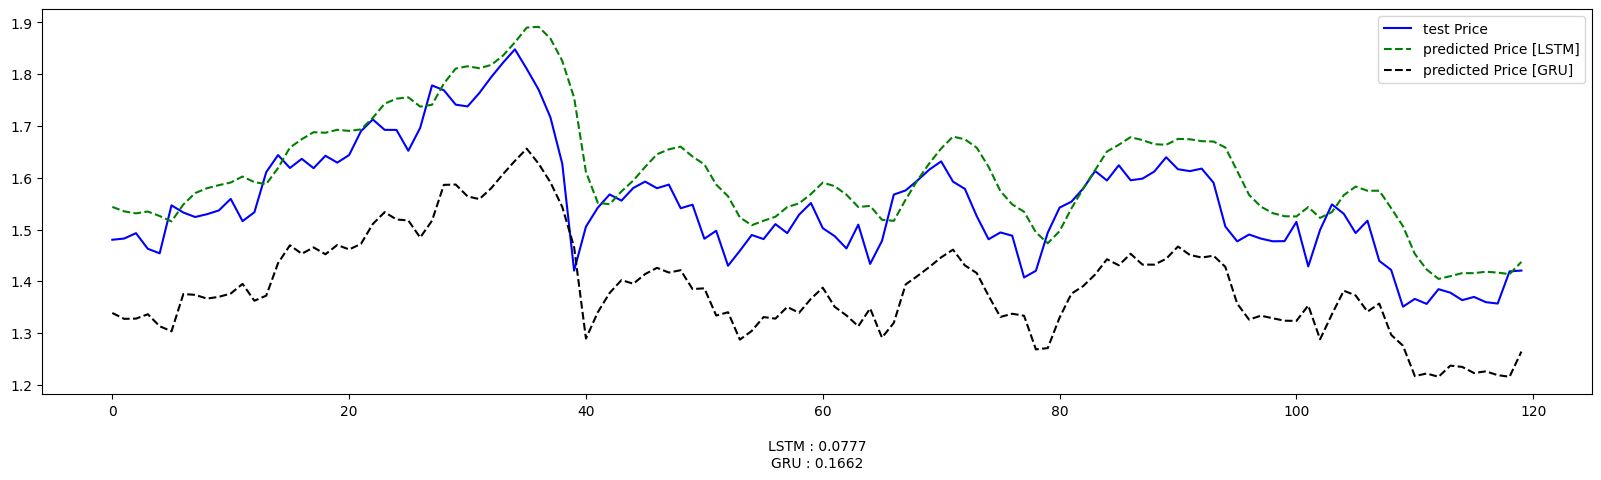

[*********************100%%**********************]  1 of 1 completed


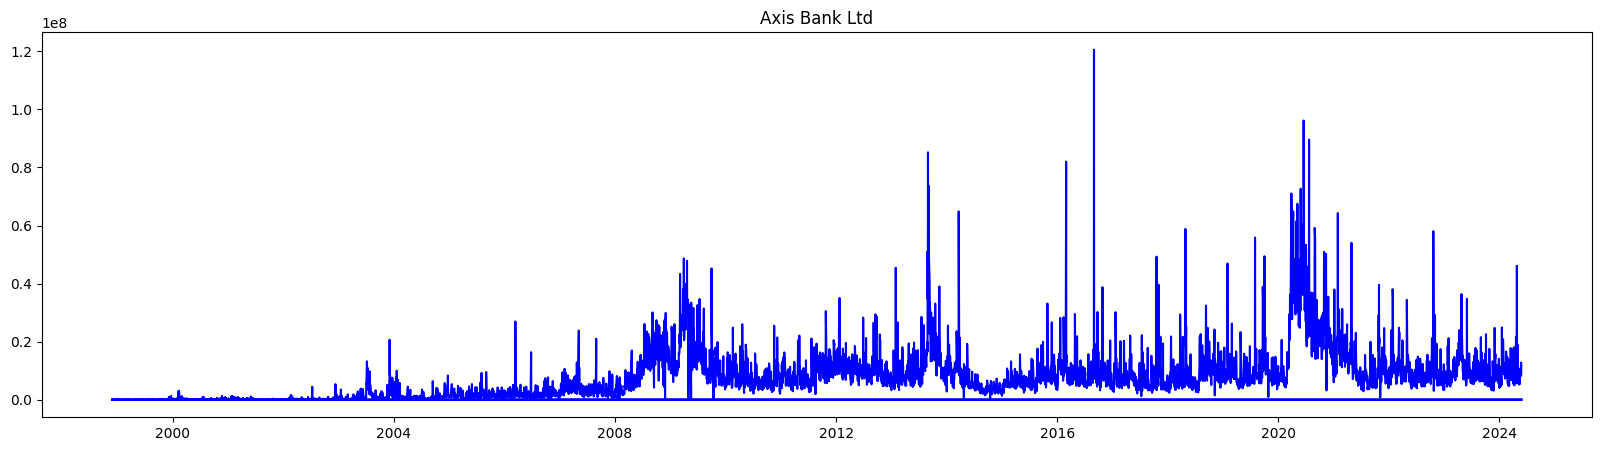

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 7s 14ms/step - loss: 10.1063
Epoch 2/10
  9/387 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.0363

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0263
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0252
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0248
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0239
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0239
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0236
Epoch 8/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0208
Epoch 9/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0219
Epoch 10/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0211
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 0.1751
Epoch 2/10
  8/387 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0303

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


387/387 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0266
Epoch 3/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0240
Epoch 4/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0224
Epoch 5/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0228
Epoch 6/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0233
Epoch 7/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0222
Epoch 8/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0213
Epoch 9/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0233
Epoch 10/10
387/387 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.0239
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


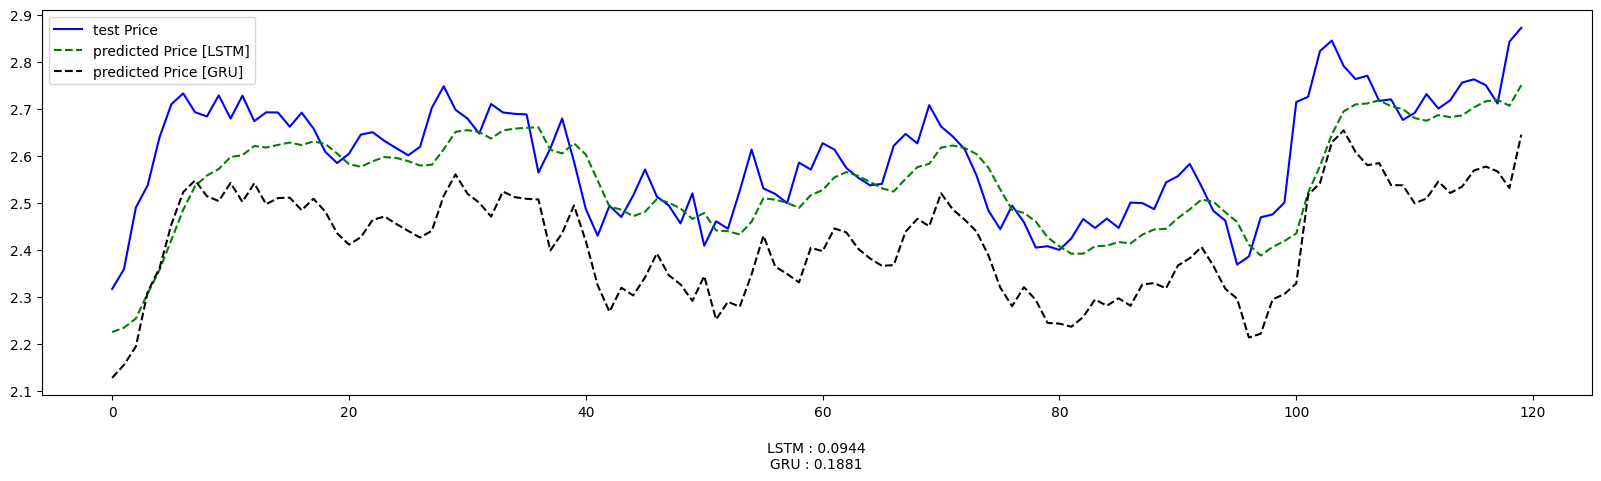

[*********************100%%**********************]  1 of 1 completed


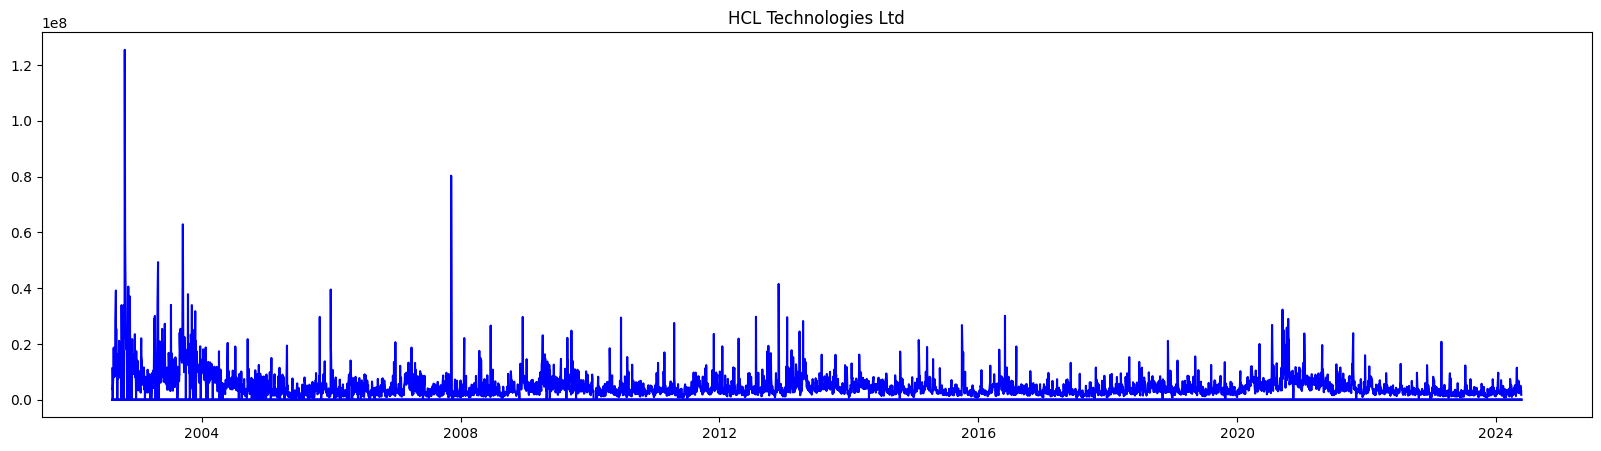

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 0.1499
Epoch 2/10
  7/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0287

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0216
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0217
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0191
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0189
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0186
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0193
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0183
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0207
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0207
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.1402
Epoch 2/10
  7/327 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0193

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0186
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0187
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0168
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0163
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0177
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0178
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0181
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0156
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0155
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


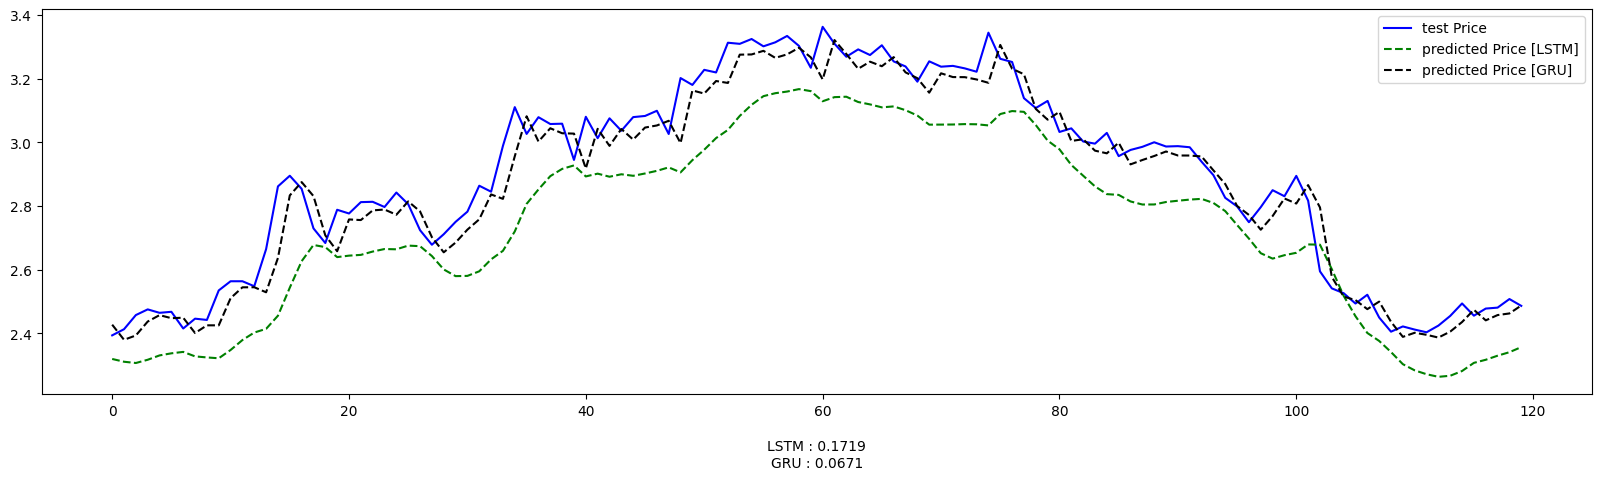

[*********************100%%**********************]  1 of 1 completed


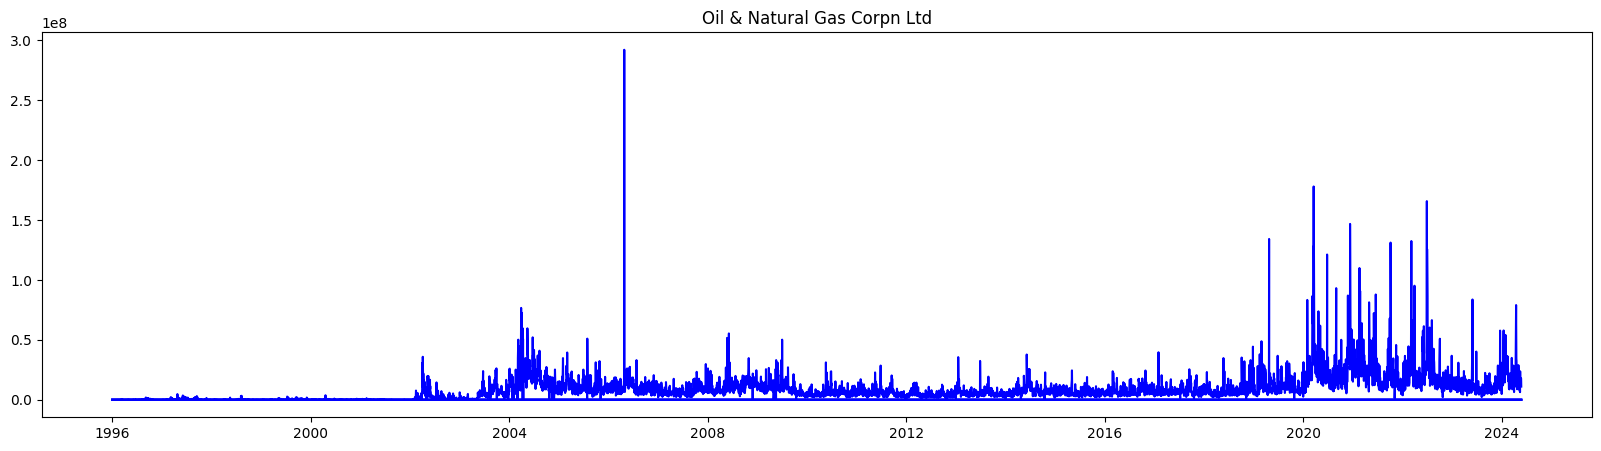

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 10s 18ms/step - loss: 0.1284
Epoch 2/10
  4/435 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0269  

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0246
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0245
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0244
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0241
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0242
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0247
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0227
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0222
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.0229
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 11s 21ms/step - loss: 0.1809
Epoch 2/10
  7/435 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0364

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0334
Epoch 3/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0318
Epoch 4/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0307
Epoch 5/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0295
Epoch 6/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0274
Epoch 7/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0279
Epoch 8/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0252
Epoch 9/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0262
Epoch 10/10
435/435 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.0263
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


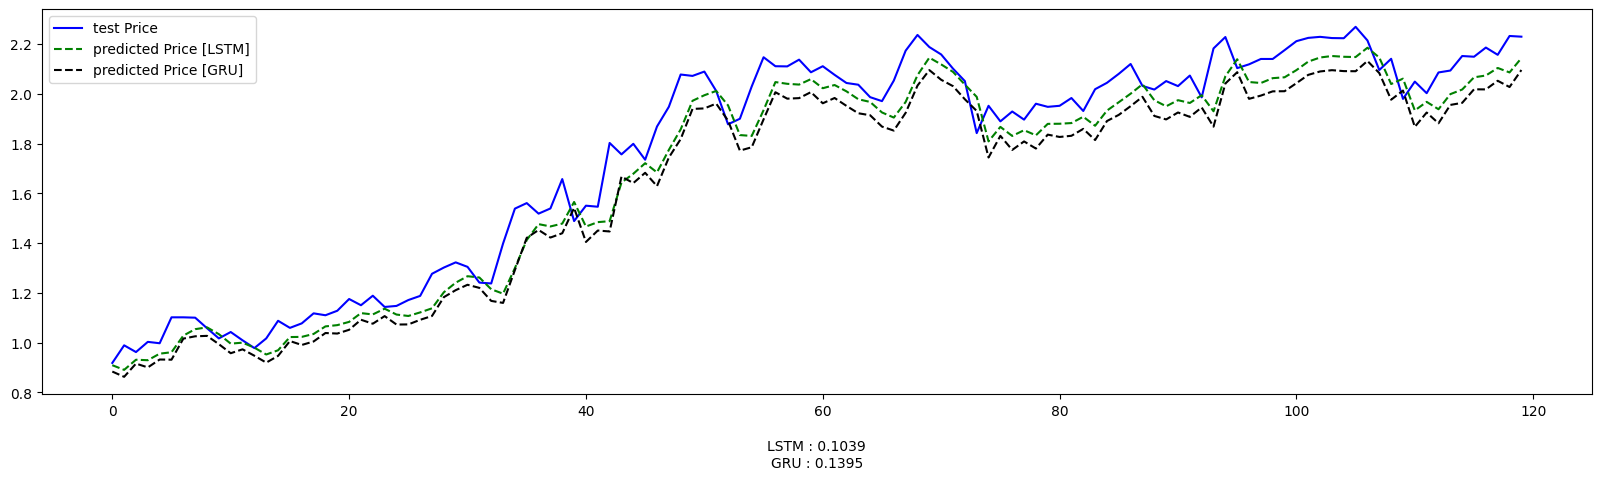

[*********************100%%**********************]  1 of 1 completed


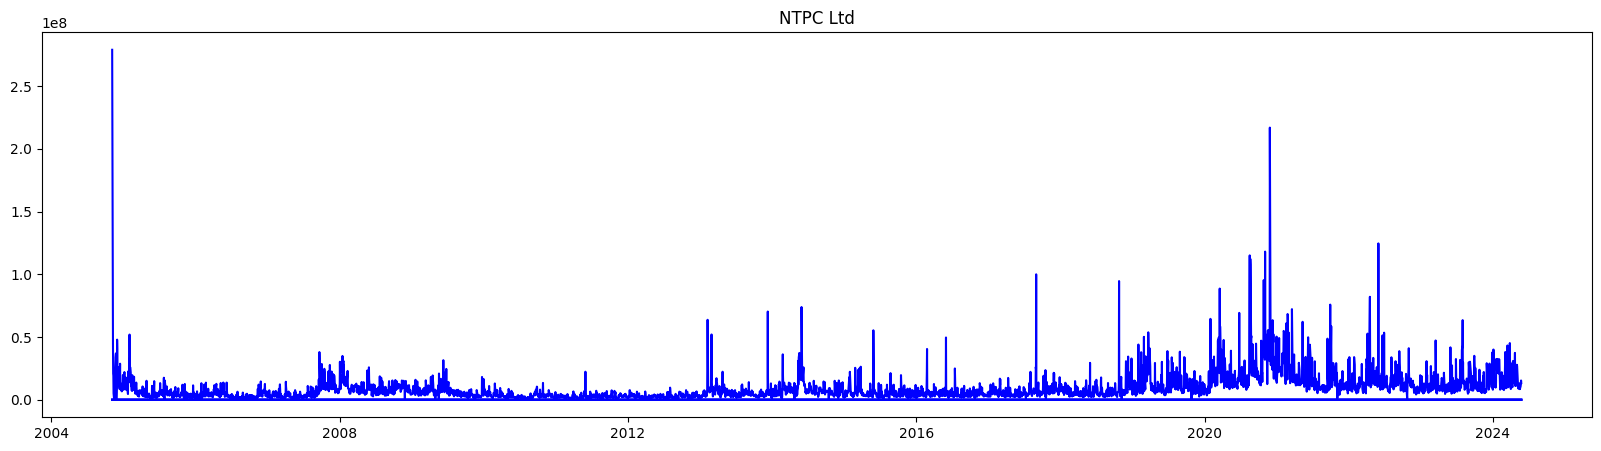

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


291/291 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 2.8270
Epoch 2/10
  7/291 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0317

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0249
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0207
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0224
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0182
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0176
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0198
Epoch 8/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0167
Epoch 9/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0168
Epoch 10/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0155
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


291/291 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.1266
Epoch 2/10
  7/291 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0382

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0206
Epoch 3/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0190
Epoch 4/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0156
Epoch 5/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0175
Epoch 6/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0150
Epoch 7/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0160
Epoch 8/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0168
Epoch 9/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0165
Epoch 10/10
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0162
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


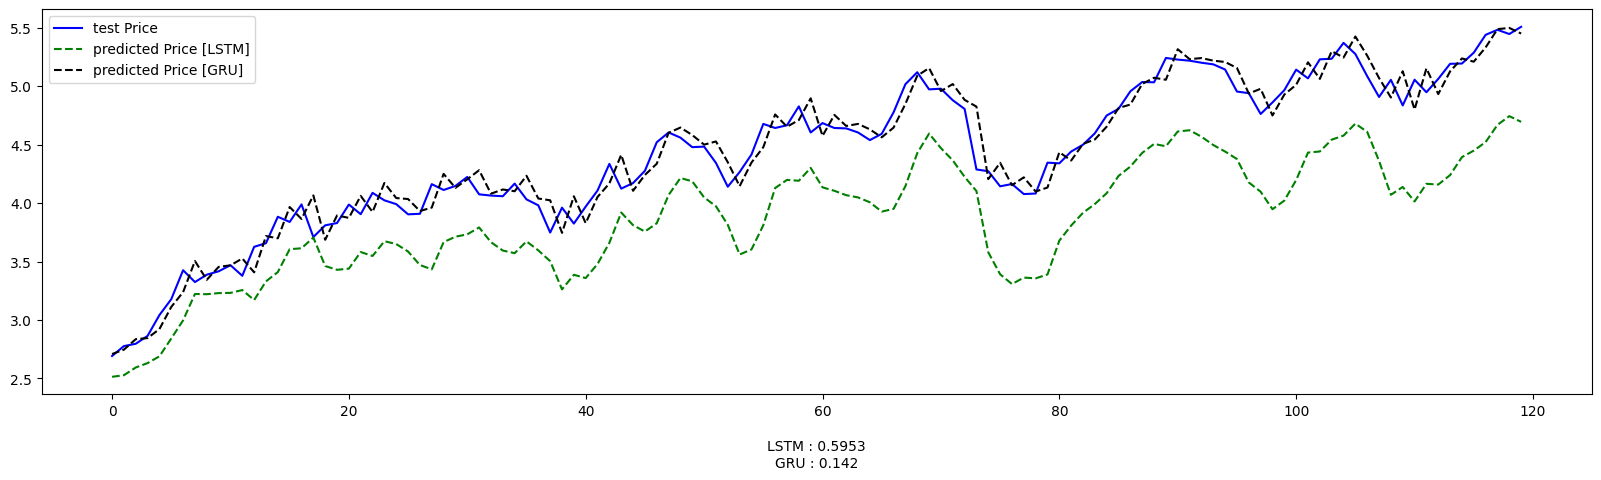

[*********************100%%**********************]  1 of 1 completed


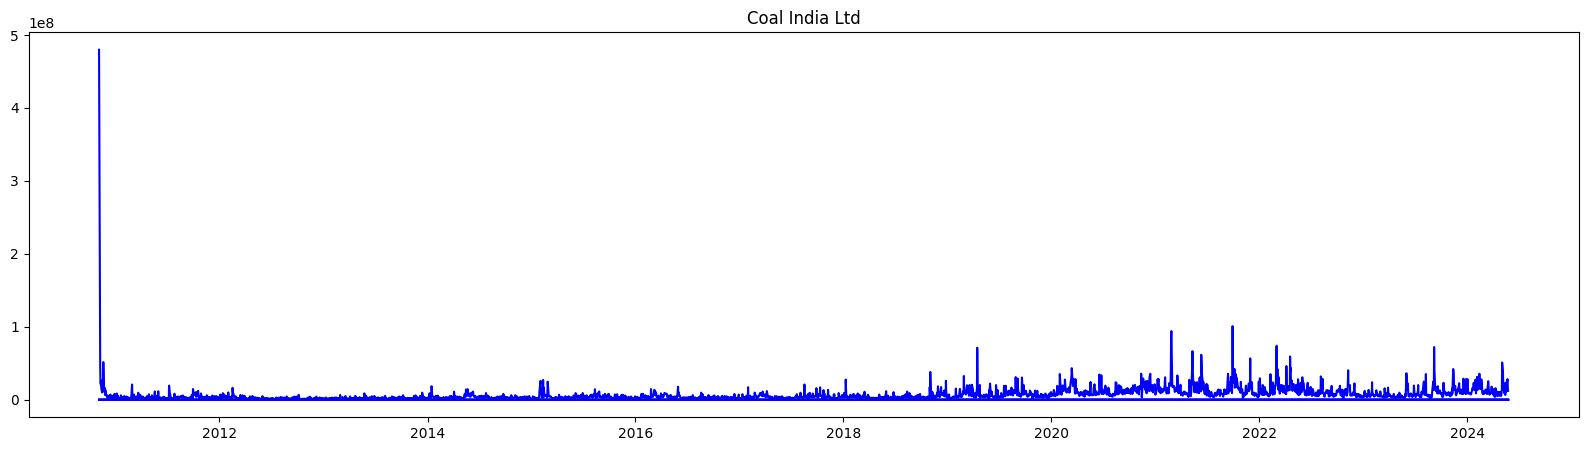

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 3.1072
Epoch 2/10
  7/198 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0324

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0380
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0365
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0345
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0315
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0308
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0290
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0298
Epoch 9/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.0276
Epoch 10/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0260
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.2585
Epoch 2/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


198/198 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0309
Epoch 3/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0267
Epoch 4/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0263
Epoch 5/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0286
Epoch 6/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0273
Epoch 7/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0287
Epoch 8/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0305
Epoch 9/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0275
Epoch 10/10
198/198 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


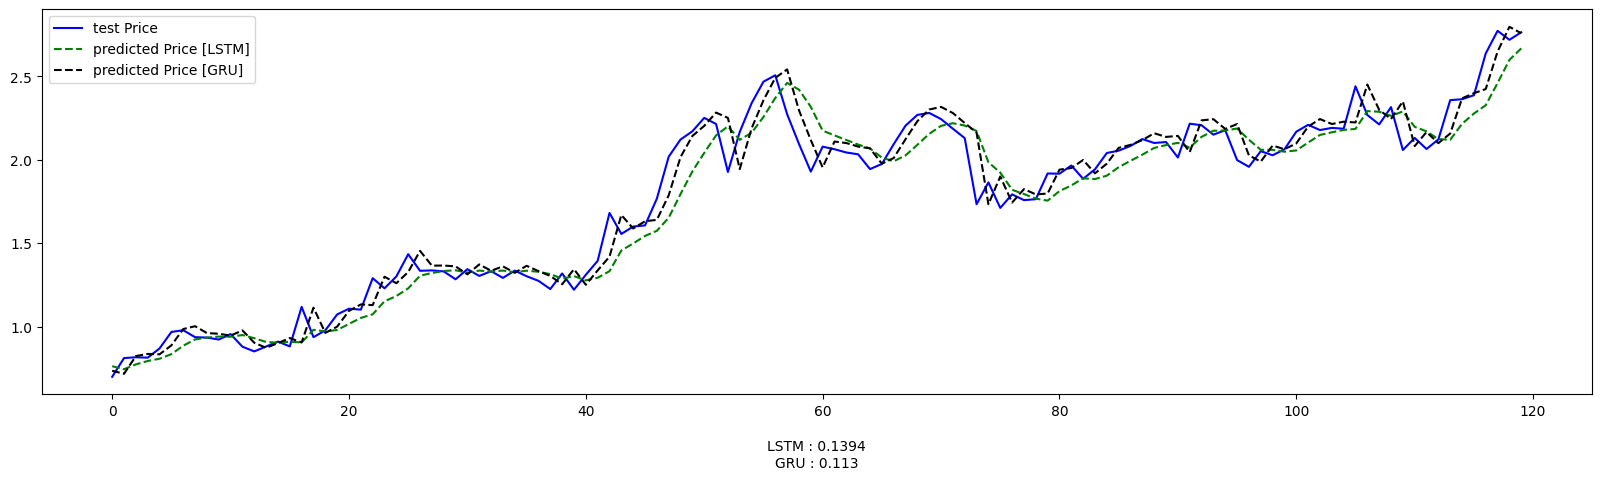

[*********************100%%**********************]  1 of 1 completed


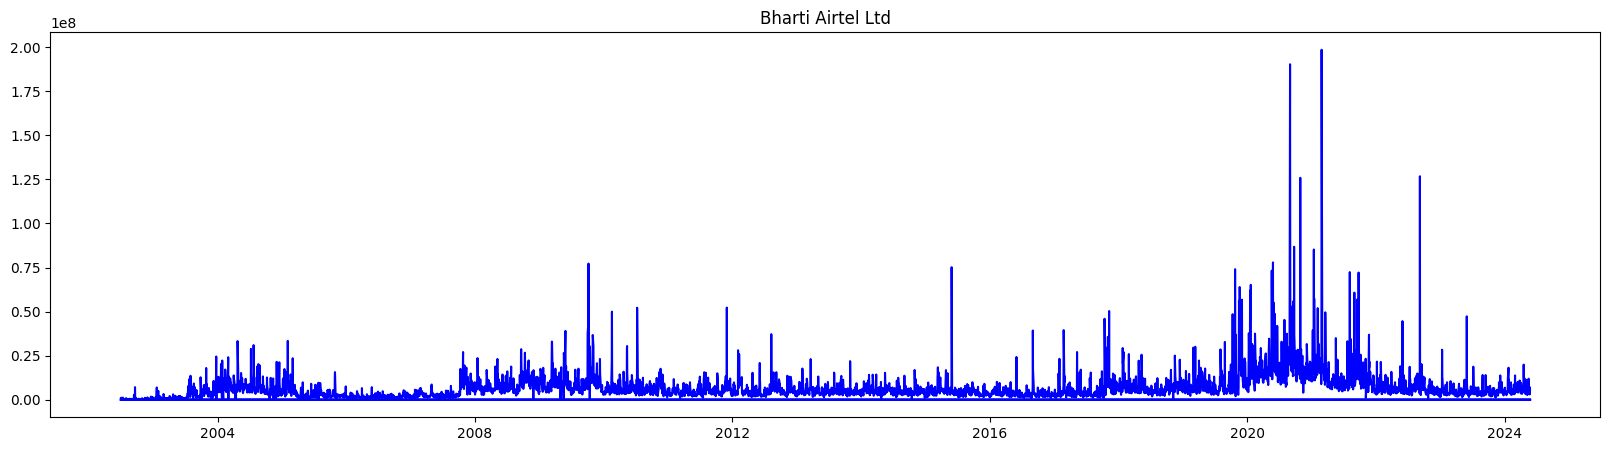

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 19ms/step - loss: 18.6382
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0150

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0269
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0223
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0216
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0209
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0210
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0194
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0187
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0184
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0178
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.1523
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0195

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0200
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0184
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0179
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0184
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0180
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0164
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0184
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0171
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0169
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


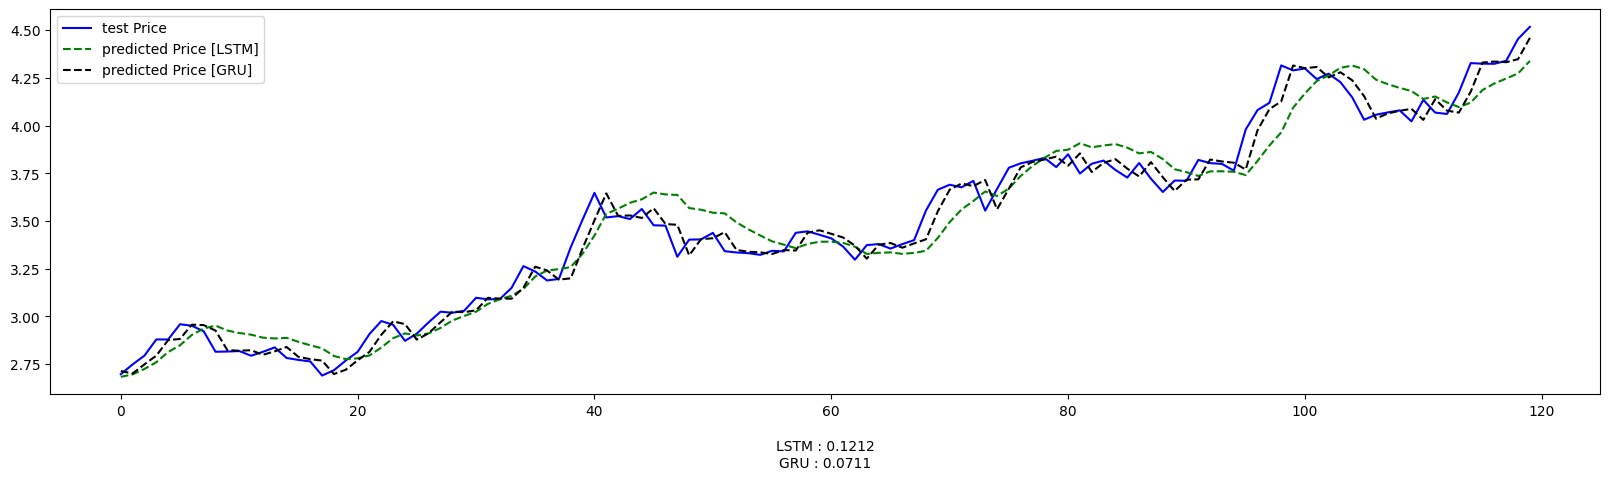

[*********************100%%**********************]  1 of 1 completed


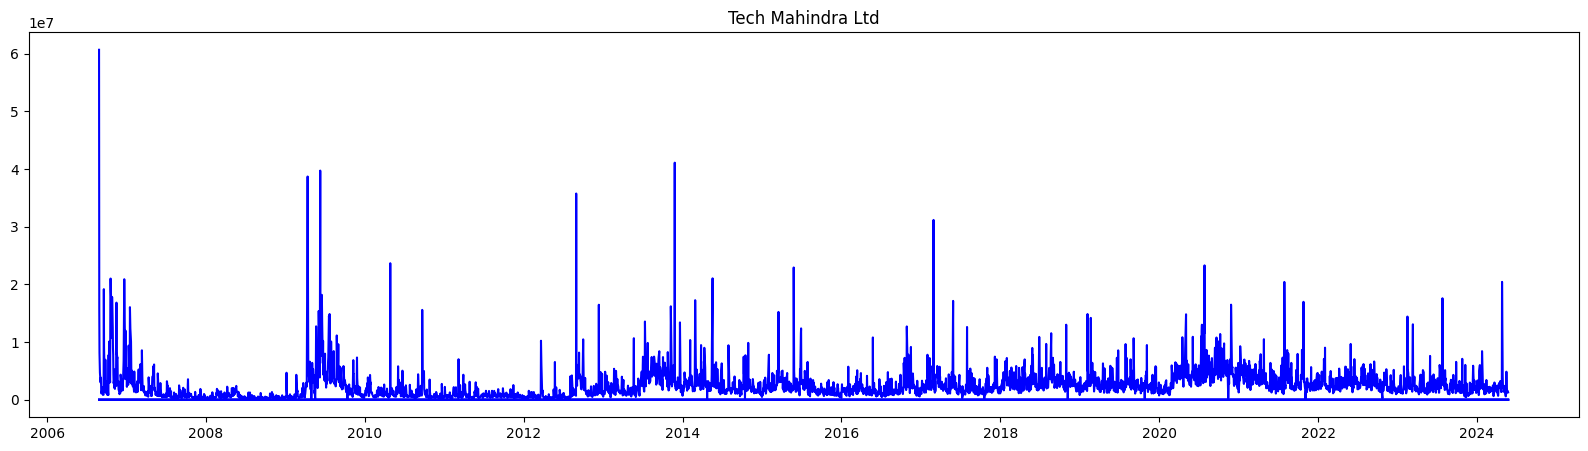

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 2.4013
Epoch 2/10
  7/263 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0266

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0253
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0233
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0225
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0256
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0209
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0219
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0224
Epoch 9/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0213
Epoch 10/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0230
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.2423
Epoch 2/10
  7/263 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0407

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0304
Epoch 3/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0222
Epoch 4/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0234
Epoch 5/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0249
Epoch 6/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0236
Epoch 7/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0219
Epoch 8/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0223
Epoch 9/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0236
Epoch 10/10
263/263 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0215
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


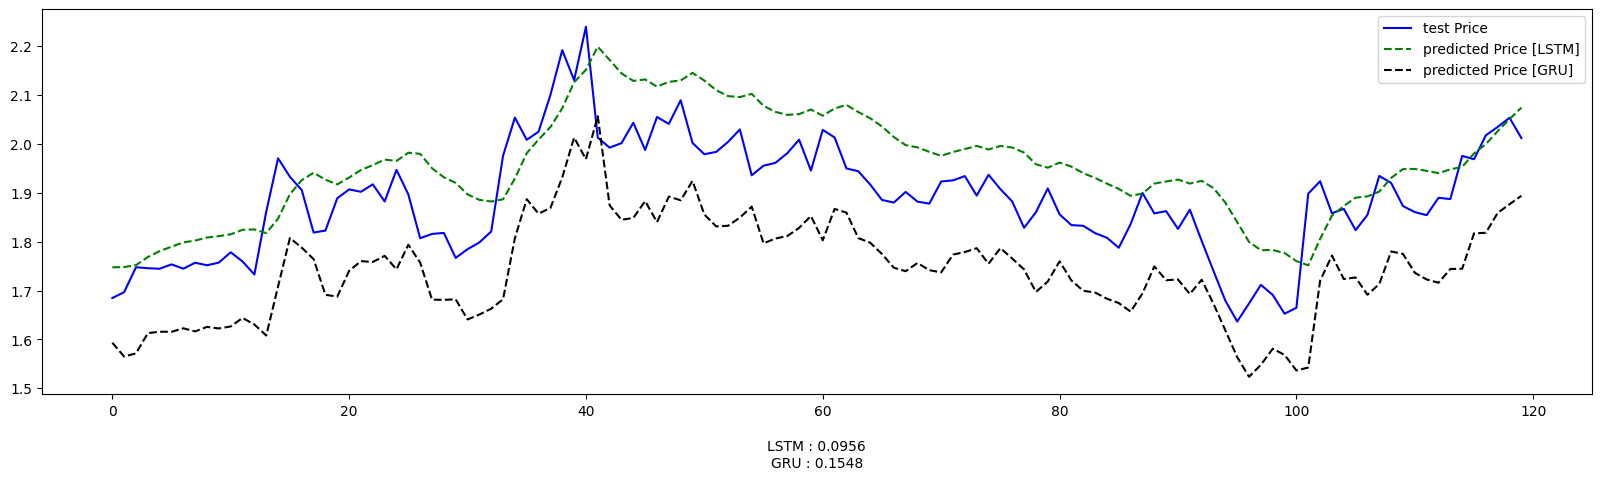

[*********************100%%**********************]  1 of 1 completed


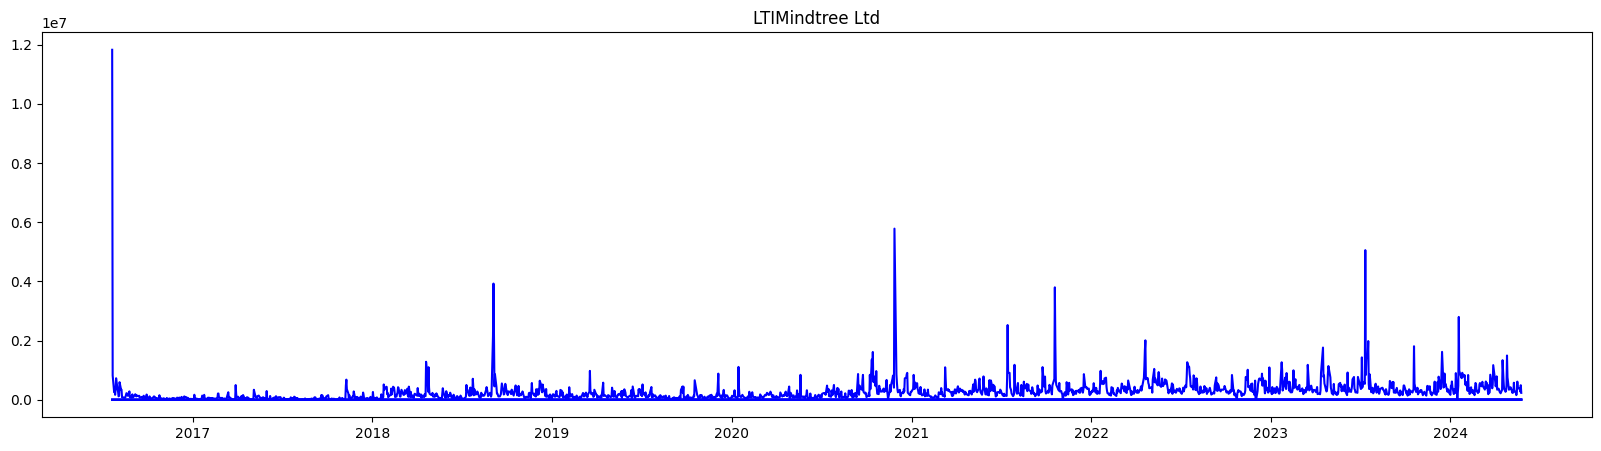

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.3174
Epoch 2/10
  7/110 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0202

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0317
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0298
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0346
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0246
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0257
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0265
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0256
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0229
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0251
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.3751
Epoch 2/10
  7/110 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0368

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0284
Epoch 3/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0237
Epoch 4/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0237
Epoch 5/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0254
Epoch 6/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0210
Epoch 7/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0188
Epoch 8/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0219
Epoch 9/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0249
Epoch 10/10
110/110 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0190
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


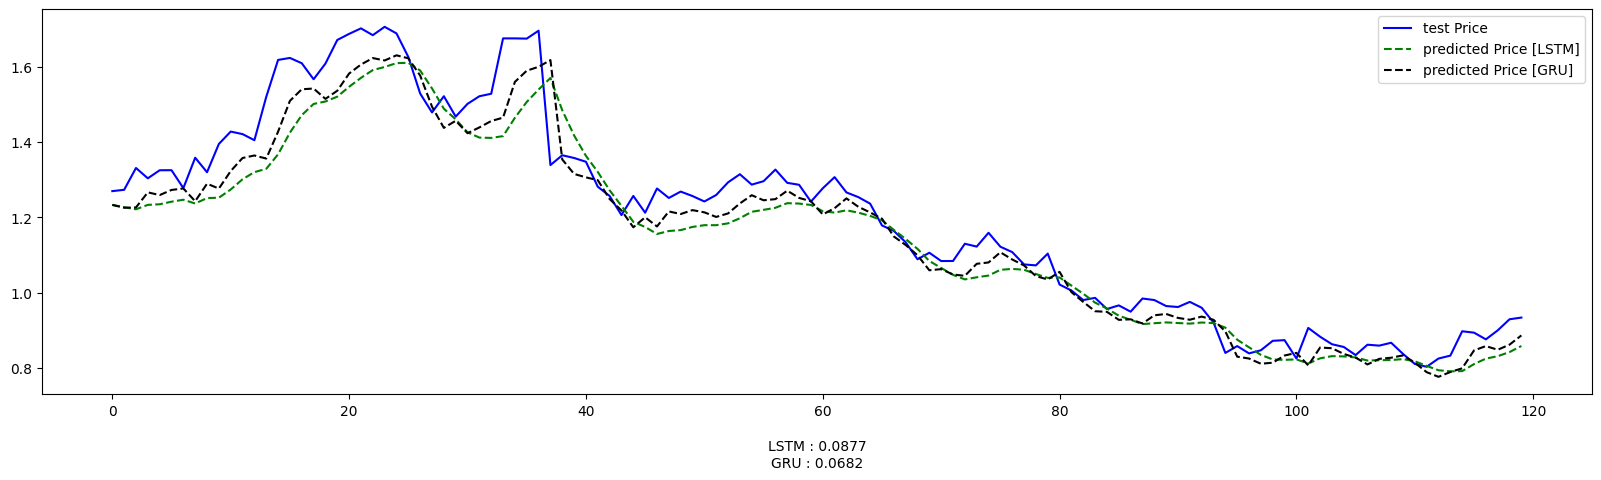

[*********************100%%**********************]  1 of 1 completed


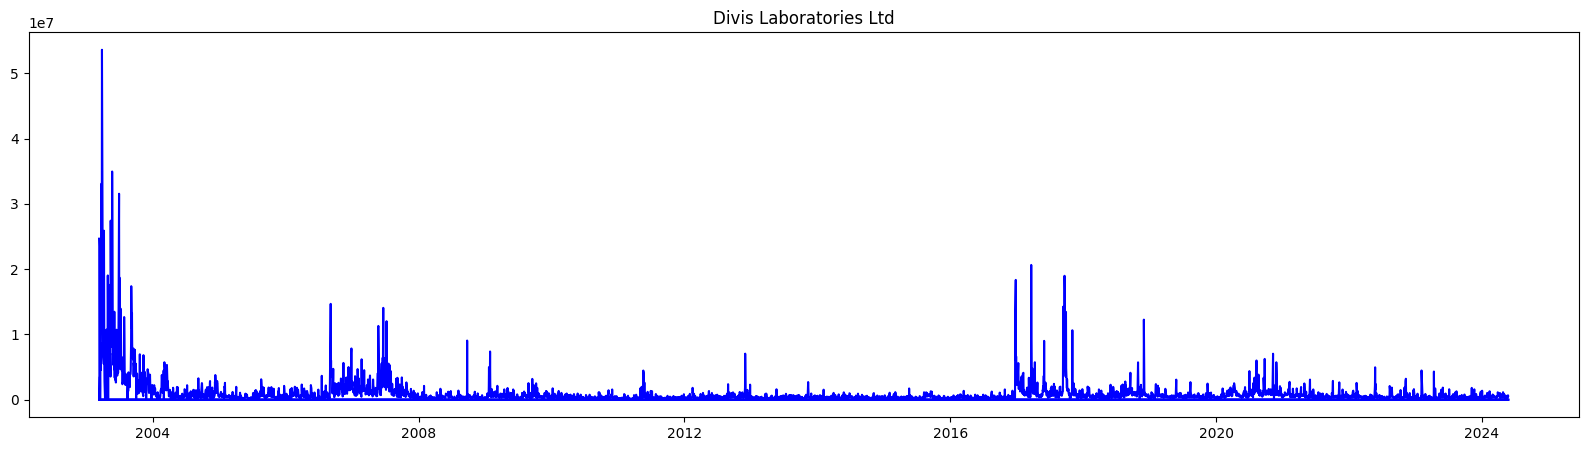

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


318/318 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.3480
Epoch 2/10
  7/318 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0205

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0235
Epoch 3/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0249
Epoch 4/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0233
Epoch 5/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0226
Epoch 6/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0210
Epoch 7/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0233
Epoch 8/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0186
Epoch 9/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0203
Epoch 10/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0193
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


318/318 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - loss: 0.2231
Epoch 2/10
  7/318 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0223

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0245
Epoch 3/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0186
Epoch 4/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0224
Epoch 5/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0208
Epoch 6/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0213
Epoch 7/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0170
Epoch 8/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0188
Epoch 9/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0184
Epoch 10/10
318/318 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0202
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


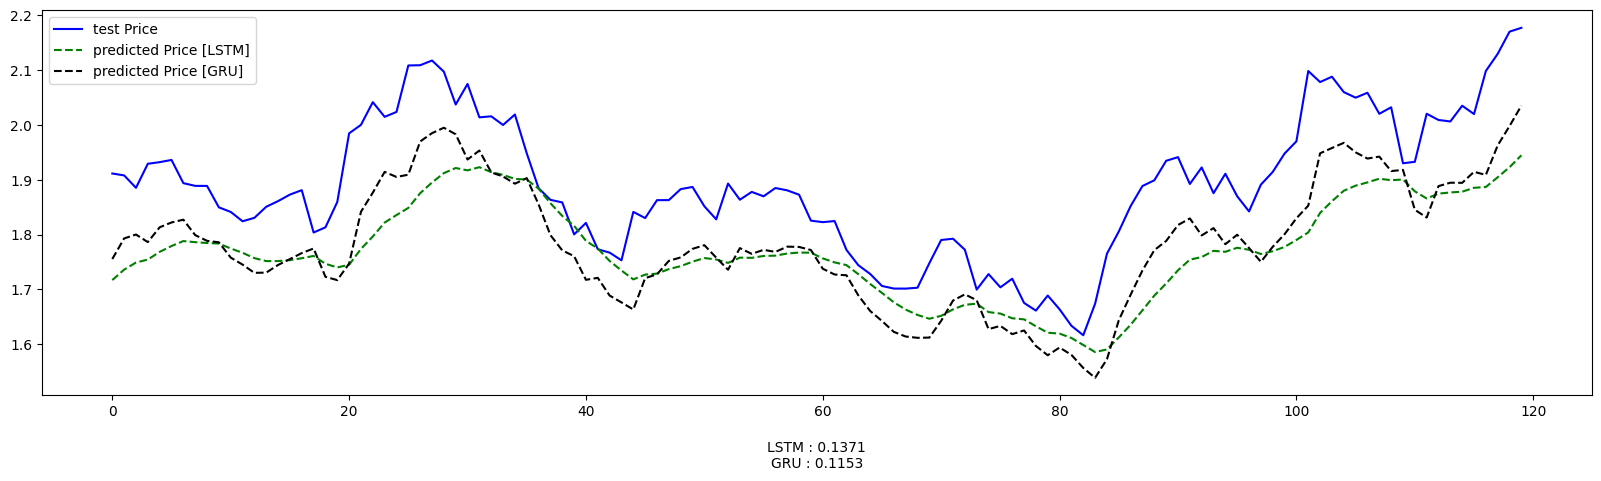

[*********************100%%**********************]  1 of 1 completed


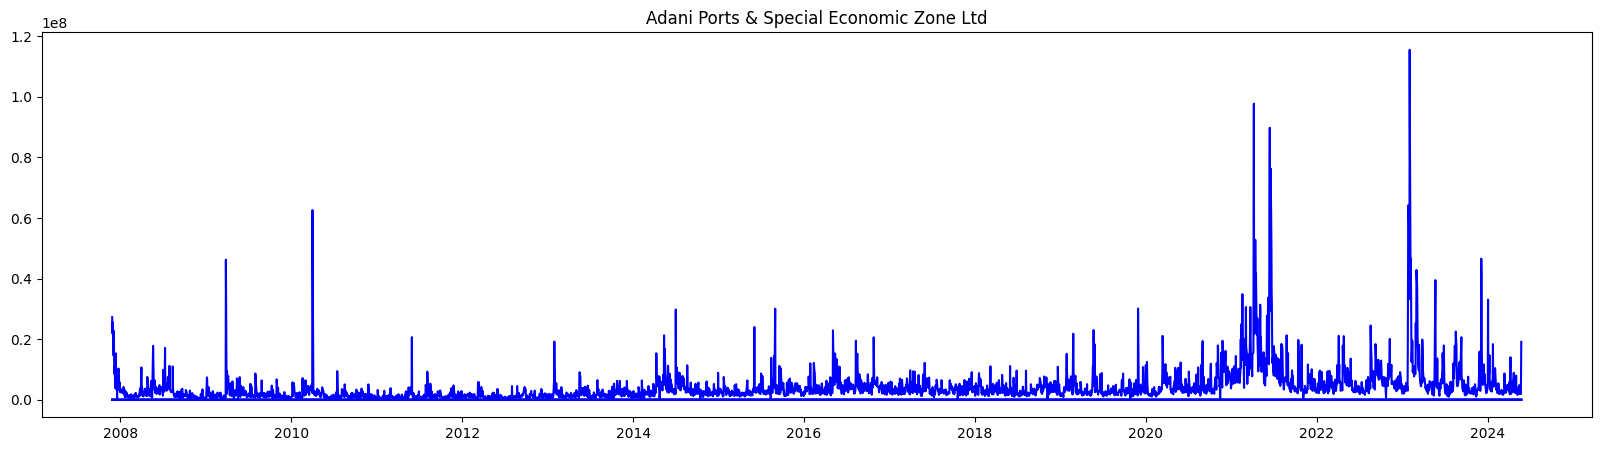

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


243/243 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.2888
Epoch 2/10
  7/243 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.0139

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0201
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0196
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0185
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0189
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0185
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0173
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0168
Epoch 9/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0169
Epoch 10/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.0158
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


243/243 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.2052
Epoch 2/10
  7/243 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0349

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0223
Epoch 3/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0170
Epoch 4/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0170
Epoch 5/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0172
Epoch 6/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0167
Epoch 7/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0172
Epoch 8/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0161
Epoch 9/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0167
Epoch 10/10
243/243 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 0.0165
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


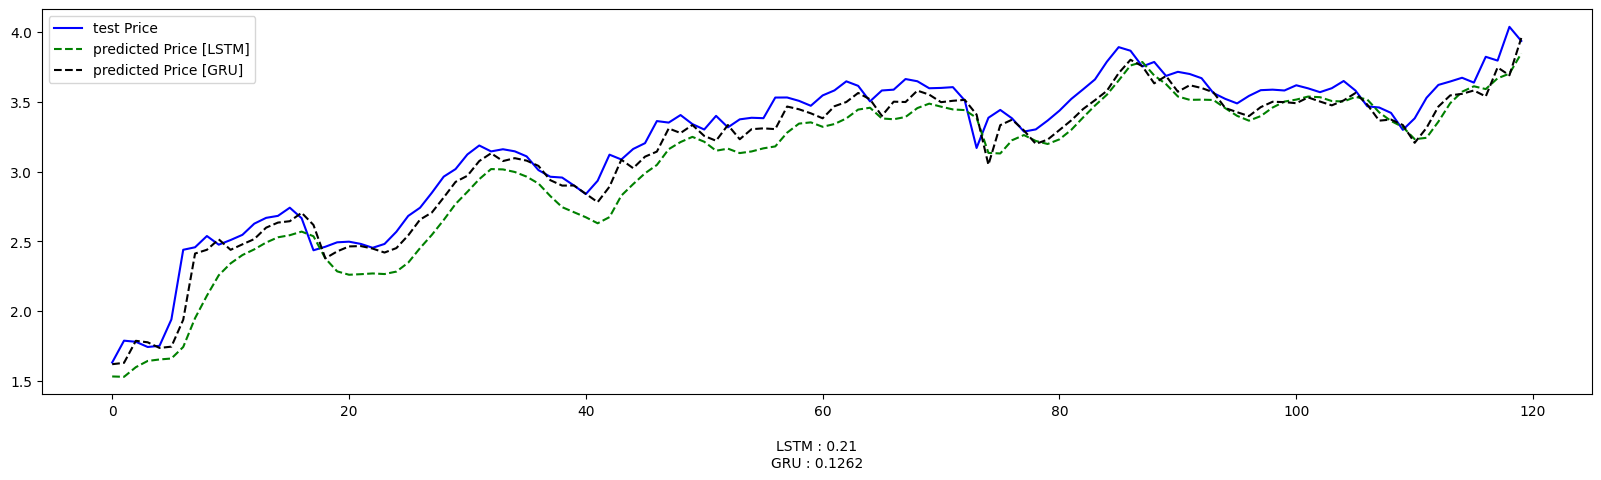

[*********************100%%**********************]  1 of 1 completed


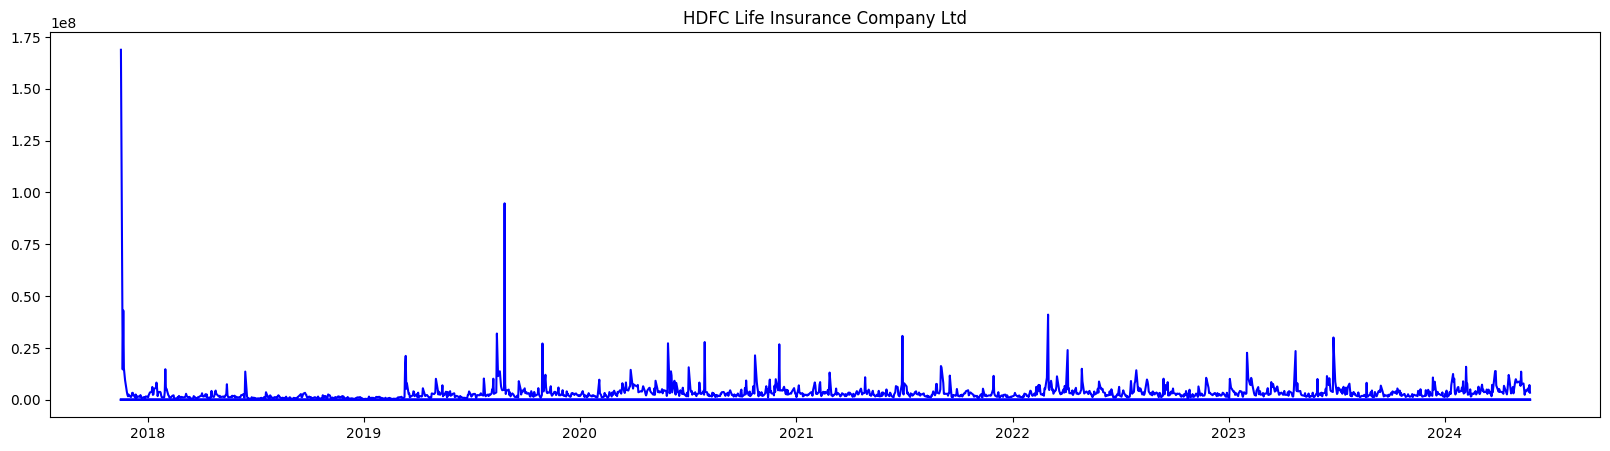

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.5137
Epoch 2/10
 7/90 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0504

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0614
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0534
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0459
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0445
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0454
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0405
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0372
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0372
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0392
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.4633
Epoch 2/10
 7/90 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0453

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0456
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0362
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0329
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0336
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0302
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0333
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0333
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0303
Epoch 10/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0325
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


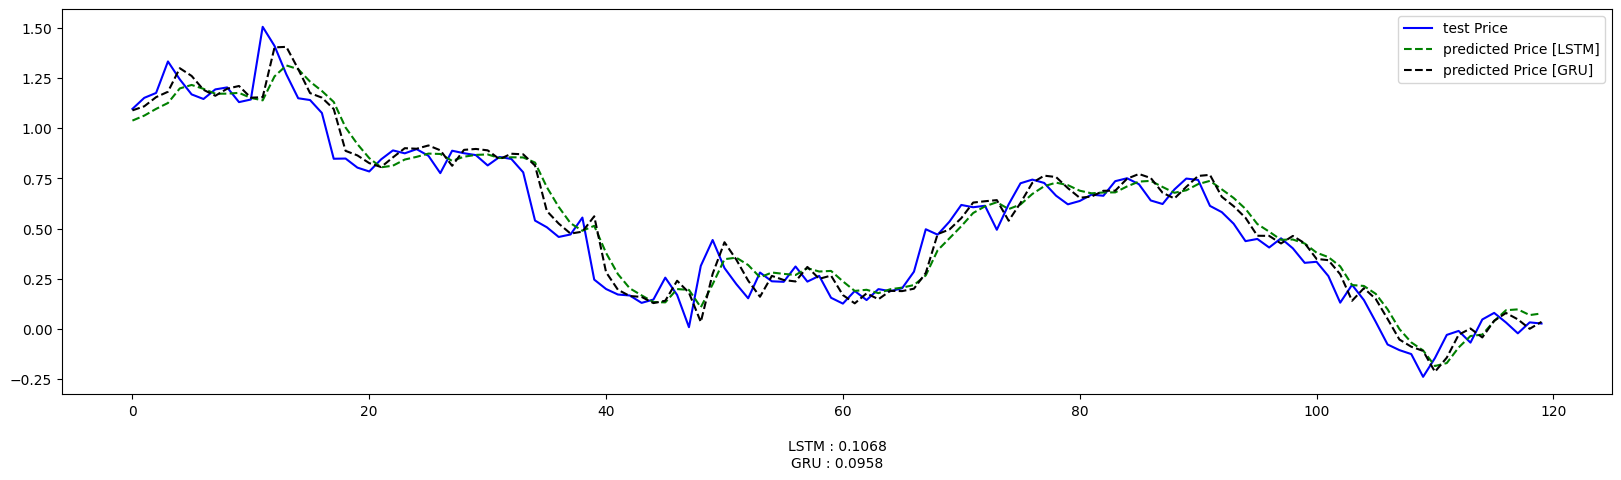

[*********************100%%**********************]  1 of 1 completed


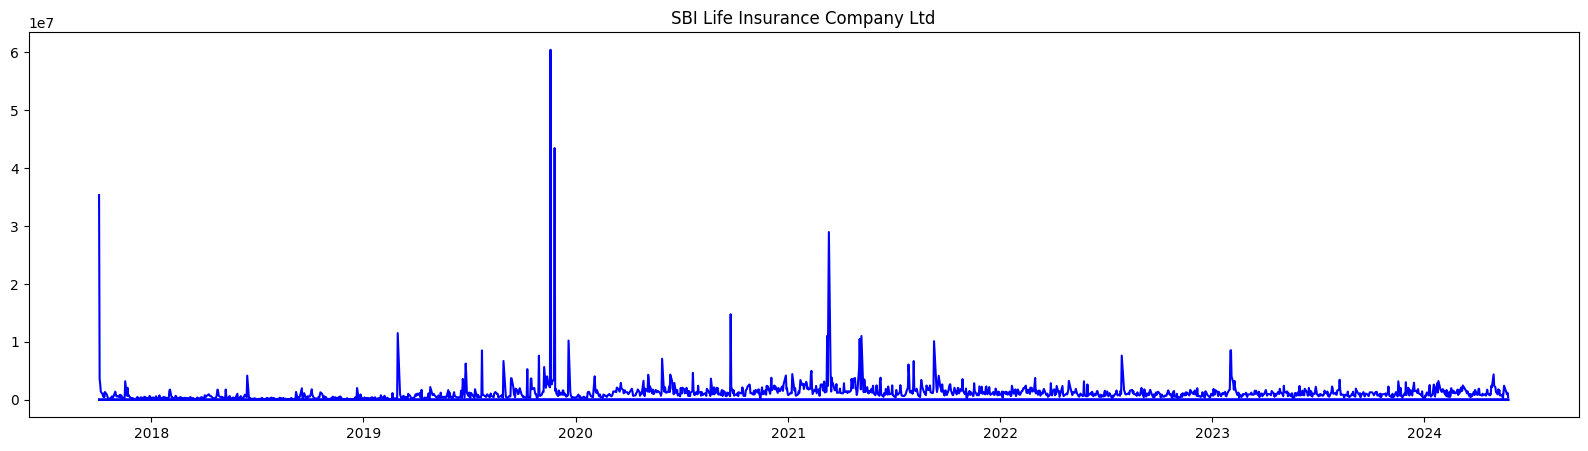

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 2.7828
Epoch 2/10
 8/92 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.3005

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.2107
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0835
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0475
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0398
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0384
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0335
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0317
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0312
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0334
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.4101
Epoch 2/10
 7/92 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0384

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0298
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0256
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0246
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0232
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0259
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0264
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0234
Epoch 9/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0199
Epoch 10/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0267
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


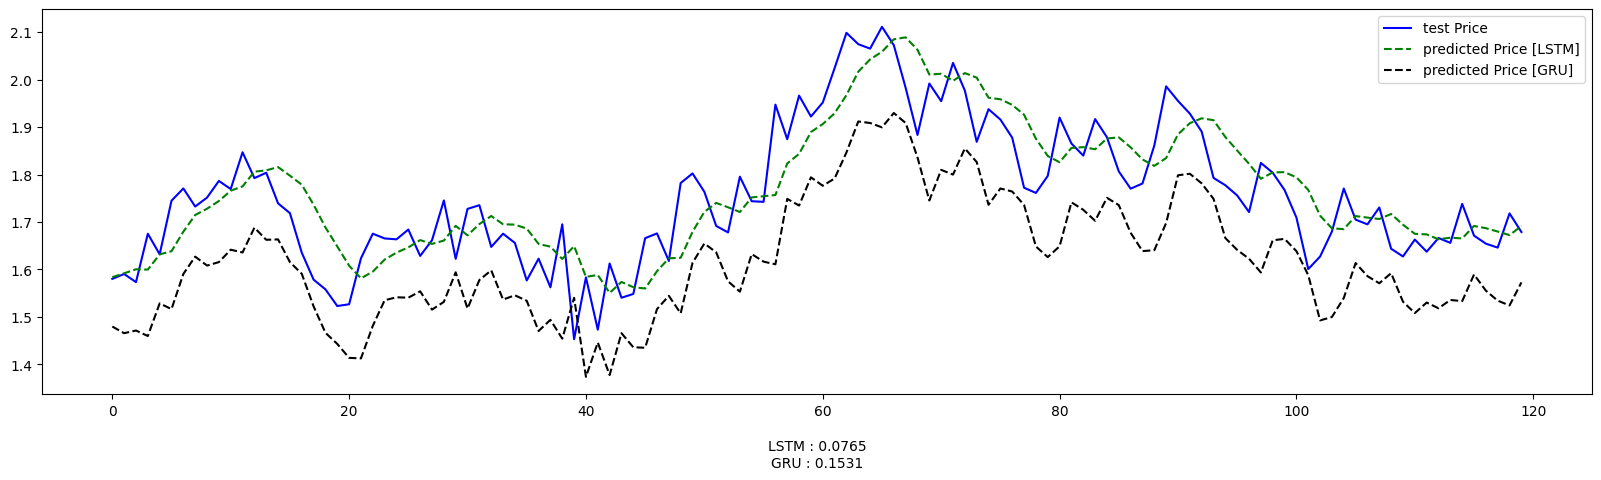

[*********************100%%**********************]  1 of 1 completed


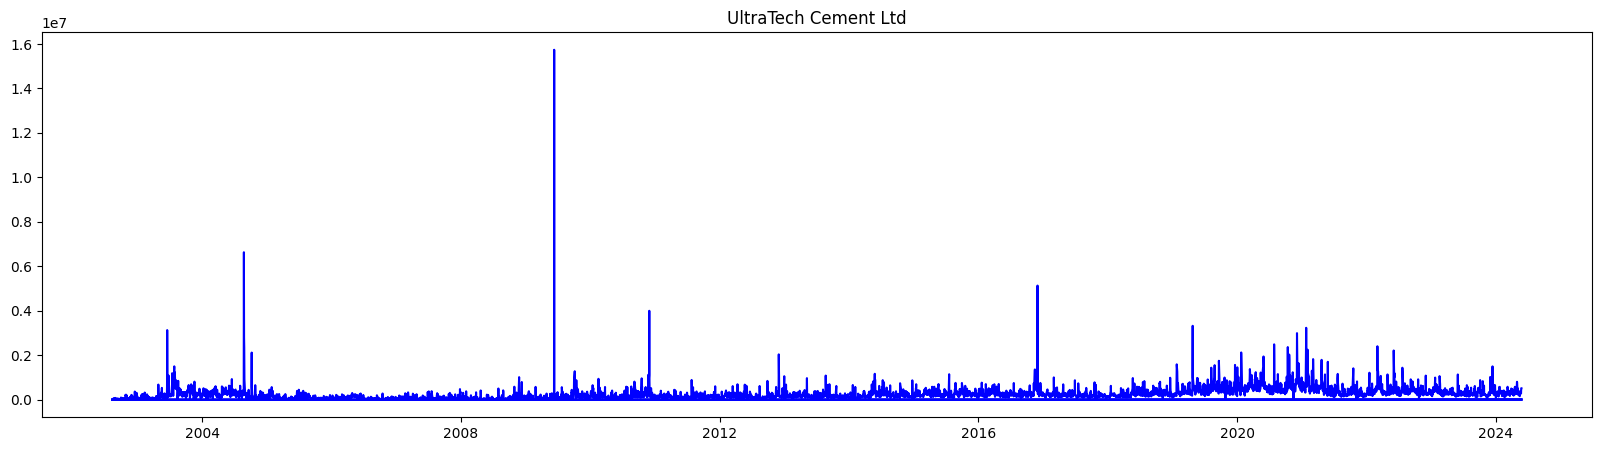

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 0.6821
Epoch 2/10
  8/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0200

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0251
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0244
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0230
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0232
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0229
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0207
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0214
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0197
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.1715
Epoch 2/10
  7/327 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0189

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0228
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0225
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0230
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0214
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0219
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0215
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0212
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0215
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0220
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


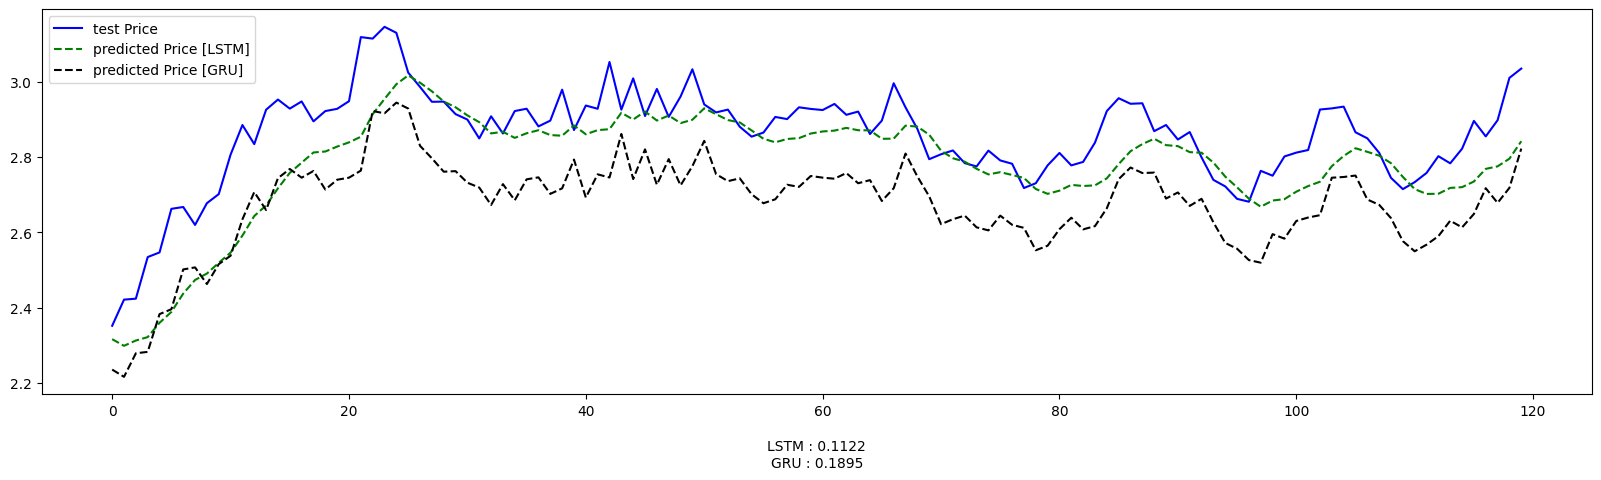

[*********************100%%**********************]  1 of 1 completed


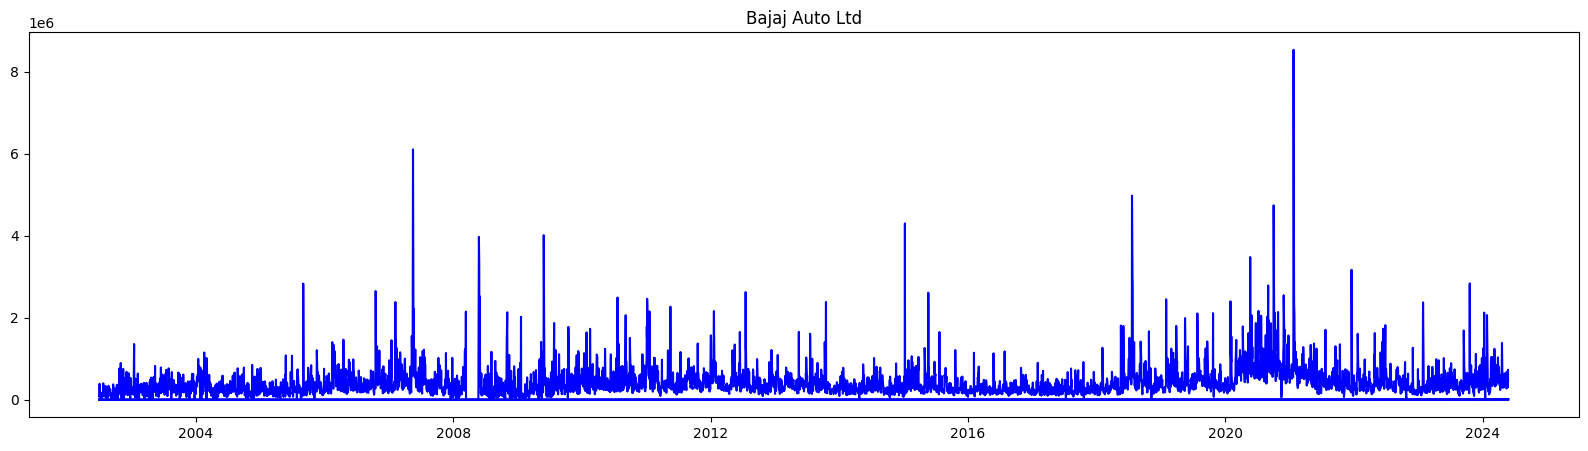

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 17ms/step - loss: 0.0843
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.0179

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0150
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0158
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0137
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0142
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0147
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0144
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0140
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0130
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.0133
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 0.1254
Epoch 2/10
  7/329 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - loss: 0.0170

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0169
Epoch 3/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.0164
Epoch 4/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0162
Epoch 5/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0171
Epoch 6/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0163
Epoch 7/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0158
Epoch 8/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0157
Epoch 9/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0158
Epoch 10/10
329/329 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0151
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


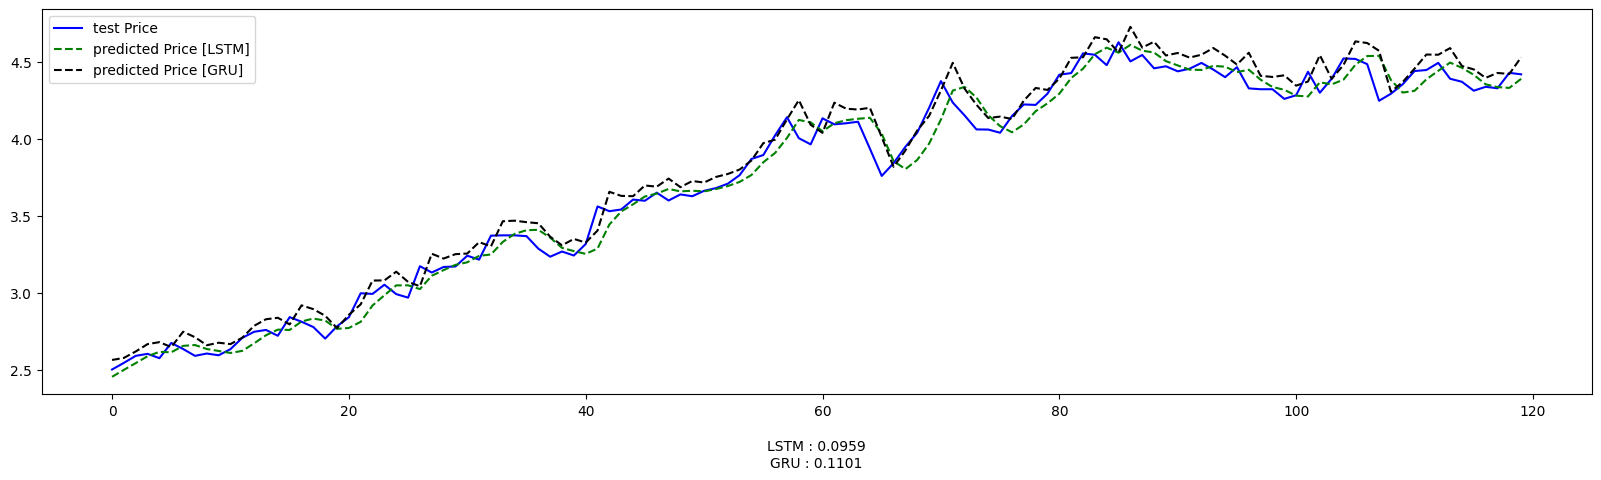

[*********************100%%**********************]  1 of 1 completed


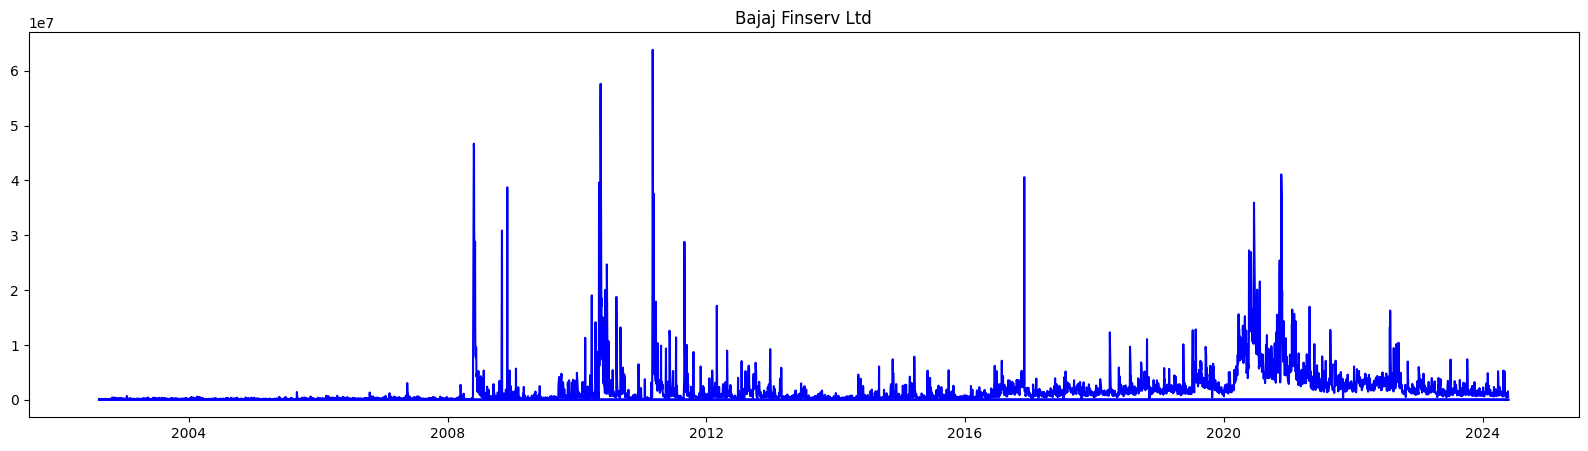

Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 8s 18ms/step - loss: 967.2983
Epoch 2/10
  7/327 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 0.0422

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0923
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0558
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0359
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0272
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0270
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0258
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0260
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0264
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 0.0248
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Epoch 1/10


C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - loss: 0.2173
Epoch 2/10
  7/327 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - loss: 0.0203

C:\Users\Surya\AppData\Roaming\Python\Python312\site-packages\keras\src\callbacks\early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  current = self.get_monitor_value(logs)


327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0266
Epoch 3/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0242
Epoch 4/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - loss: 0.0223
Epoch 5/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0239
Epoch 6/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0229
Epoch 7/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0228
Epoch 8/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0237
Epoch 9/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0253
Epoch 10/10
327/327 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 0.0265
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


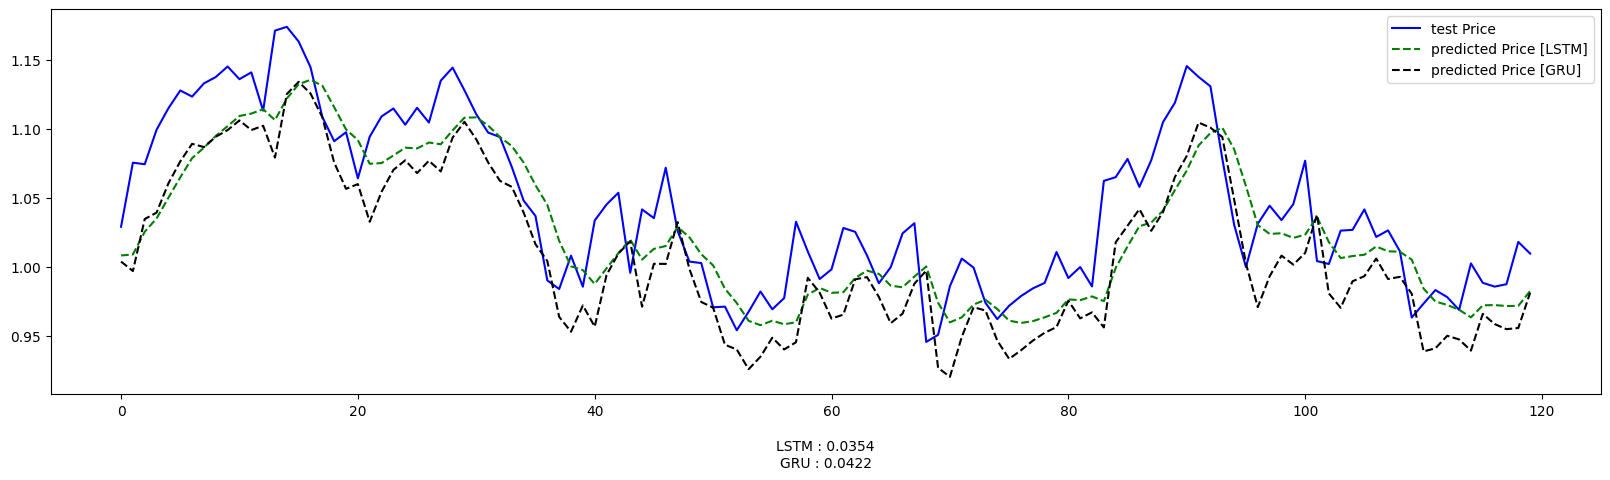

LSTM     GRU
COMPANY                                                  
Asian Paints Ltd                           0.1489  0.0364
Britannia Industries Ltd                   0.1504  0.1731
Cipla Ltd                                  0.1295  0.1156
Eicher Motors Ltd                          0.0747  0.1043
Nestle India Ltd                           0.0844  0.1816
Grasim Industries Ltd                      0.1463  0.0612
Hero MotoCorp Ltd                          0.1390  0.1221
Hindalco Industries Ltd                    0.4293  0.1178
Hindustan Unilever Ltd                     0.0914  0.0997
ITC Ltd                                    0.0668  0.0633
Larsen & Toubro Ltd                        0.1132  0.2279
Mahindra & Mahindra Ltd                    0.1619  0.1143
Reliance Industries Ltd                    0.0744  0.0753
Tata Consumer Products Ltd                 0.1498  0.1755
Tata Motors Ltd                            0.1668  0.1313
Tata Steel Ltd                             0.1227  0.0783
Wipro Ltd                                101.3720  0.0591
Apollo Hospitals Enterprise Ltd            0.1334  0.0643
Dr Reddys Laboratories Ltd                 0.1563  0.2234
Titan Company Ltd                          0.1970  0.1899
State Bank of India                        0.1047  0.0711
Bharat Petroleum Corporation Ltd           0.1785  0.0859
Kotak Mahindra Bank Ltd                    0.0704  0.0931
UPL Ltd                                    0.0684  0.0609
Infosys Ltd                                0.0803  0.0533
Bajaj Finance Ltd                          0.1031  0.1134
Adani Enterprises Ltd                      0.2866  0.1794
Sun Pharmaceuticals Industries Ltd        17.1807  0.0558
JSW Steel Ltd                              0.2424  0.0900
HDFC Bank Ltd                              0.0548  0.1105
Tata Consultancy Services Ltd              0.1179  0.0989
ICICI Bank Ltd                             0.1092  0.0514
Power Grid Corporation of India Ltd        0.2048  0.2099
Maruti Suzuki India Ltd                    0.0769  0.0503
IndusInd Bank Ltd                          0.0777  0.1662
Axis Bank Ltd                              0.0944  0.1881
HCL Technologies Ltd                       0.1719  0.0671
Oil & Natural Gas Corpn Ltd                0.1039  0.1395
NTPC Ltd                                   0.5953  0.1420
Coal India Ltd                             0.1394  0.1130
Bharti Airtel Ltd                          0.1212  0.0711
Tech Mahindra Ltd                          0.0956  0.1548
LTIMindtree Ltd                            0.0877  0.0682
Divis Laboratories Ltd                     0.1371  0.1153
Adani Ports & Special Economic Zone Ltd    0.2100  0.1262
HDFC Life Insurance Company Ltd            0.1068  0.0958
SBI Life Insurance Company Ltd             0.0765  0.1531
UltraTech Cement Ltd                       0.1122  0.1895
Bajaj Auto Ltd                             0.0959  0.1101
Bajaj Finserv Ltd                          0.0354  0.0422

In [5]:
for company,code in zip(nifty_list['COMPANY'],nifty_list['CODE']):
    X_train,X_test,Y_train,Y_test = dataPreprocessing(company,code,seq_len,n_future)
    pred_lstm , Y_test = trainLSTM(X_train,X_test,Y_train,Y_test,seq_len)
    pred_gru , Y_test = trainGRU(X_train,X_test,Y_train,Y_test,seq_len)
    
    result.loc[company, "LSTM"],result.loc[company, "GRU"] = plot_prediction(Y_test,pred_lstm,pred_gru)
result

In [6]:
result.to_csv('result.csv')